# Comparison of Events
Notebook useful to compare multiple simulations - also good for seeing where to look at individual model outcomes!

In [1]:
# Make plots interactive in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import os
import sys
import pickle
from glob import iglob
import matplotlib.cm as cm
import re
# import polars as pl
import gc

# Import QDYN wrapper and plotting library
from qdyn import qdyn
from qdyn import plot_functions as qdyn_plot

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # Seconds per year

/opt/cray/pe/python/3.9.13.1/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# open dict from file

# Instantiate the QDYN class object
p = qdyn()

# 1. Open output files (for models 1-20 dy)

In this case, I used a nested dictionary to store the outputs in the following manner:
The dictionary `models_dict` stores one model in each key. Inside of each key there are dictionaries. These dictionaries store:
- set_dict: dictionary with general input settings (equivalent to `p.set_dict`)
- mesh_dict: dictionary with general input settings (equivalent to `p.mesh_dict`)
- output vmax (created in this cell)
- ot_: dictionary with timeseries of element with the highest slip rate (equivalent to `p.ot`)
- ox: dictionary with snapshots (equivalent to `p.ox`)
- ot_fault: equivalent to `p.fault`

In [3]:
%reload_ext autoreload
%autoreload 2

script_dir = "/work/e820/e820/willpizii/run/comparison"
base_dir = "/work/e820/e820/willpizii/run/runmodels"
# script_dir = "/home/will/archer_work/run/comparison"
# base_dir = "/home/will/archer_work/run/runmodels"
dir_list = list() # list of directories with the models
name_list = list()
models_dict = {} # dictionary where outputs of the models will be stored


i = 1 # counter for name of the models

# create list with directories where the models are stored

def custom_sort_key(name):
    # Extract the part between '_XXXx_' and convert it to an integer
    match = re.search(r'_(\d+)x_', name)
    if match:
        return int(match.group(1))
    return float('inf')

for root, dirs, files in os.walk(base_dir, topdown=True):
    dirs.sort(key=custom_sort_key) # sort the directories
    # only use the directories with the models (IMPORTANT: change the suffix condition according to the set of models)
    for name in dirs:
        if name.endswith("0z") or name.startswith("mod_de"):
            dir_list.append(os.path.join(root, name))
            name_list.append(name)
            
print(dir_list)
print(f'found {len(dir_list)} models')
# for each model, extract output of vmax and store it in a dictionary
for directory in dir_list:
    # Instantiate the QDYN class object
    p = qdyn()
    
    print(i)
    os.chdir(directory) # change path to directory of the model
    filename_setdict = "setdict.pkl"
    filename_meshdict = "meshdict.pkl"
    
    if not any(file_name == filename_setdict for file_name in os.listdir(directory)):
        print("set_dict file not available")
        break
    if not any(file_name == filename_meshdict for file_name in os.listdir(directory)):
        print(" mesh_dict file not available")
        break    
        
    # stores mesh dict and set dict dictionaries
    keyword_dict = str(os.path.basename(directory))
    name_dict = str("s")
    models_dict[keyword_dict]={}
    
    for file in os.listdir(directory):
        # open the file with the model settings        
        
        if file.endswith(filename_setdict):
            path_dict=os.path.join(directory,file)
            dict_to_read = open(path_dict, "rb")

            # assign dictionary to p.mesh_dict
            p.set_dict = pickle.load(dict_to_read)
        
        if file.endswith(filename_meshdict):
            path_dict=os.path.join(directory,file)
            dict_to_read = open(path_dict, "rb")

            # assign dictionary to p.mesh_dict
            p.mesh_dict = pickle.load(dict_to_read)
            
        # find element of timeseries
        if file.startswith("output_ot"):
            element = file.split("_")[-1] #get index of the element from filename
            ot_element = "ot_" + str(element)
    
    #  assign dictionary with settings to dictionary storing models
    models_dict[keyword_dict]["mesh_dict"] = p.mesh_dict
    models_dict[keyword_dict]["set_dict"] = p.set_dict
    
    # Define split index (NOTE: assumes that model m19 and m20 is a model with one fault)
    if i !=18 and i!=19:
        models_dict[keyword_dict]["split"] = len(p.mesh_dict["X"]) // 2  # index of splitting point between the two faults
    else:
        models_dict[keyword_dict]["split"] = len(p.mesh_dict["X"]) # no splitting
        
    # print("N faults"+ str(p.set_dict["N_FAULTS"]))
        
    # read output and store vmax in a dictionary
    p.read_output(read_ot=True, read_ox=False, read_fault=True)  
    
    models_dict[keyword_dict]["vmax"] = p.ot_vmax
    
    
    #Store timeseries of elements in dictionary 
    models_dict[keyword_dict]["ot"] = {}
    
    # store timeseries of element of fault 1 in a dictionary
    
    models_dict[keyword_dict]["ot"][0] = p.ot[0]
    
    # store timeseries of element of fault 2 in a dictionary
    if os.path.basename(keyword_dict)!="mod_def" and os.path.basename(keyword_dict)!="mod_cone":
        models_dict[keyword_dict]["ot"][1] = p.ot[1]
    
    # models_dict[keyword_dict]["ot"]["fault"] = np.where(int(element)<=models_dict[keyword_dict]["split"], 1, 2) # assign fault to row depending on the index
    
    # store snapshots in a dictionary
    #models_dict[keyword_dict]["ox"] = p.ox
    
    # store timeseries of fault in a dictionary
    models_dict[keyword_dict]["ot_fault"] = p.fault
    
    # save dict as file

#     # define dictionary
#     dict_model = models_dict[keyword_dict]

#     # create a binary pickle file (output file)
#     file_name = "dict_output_" + keyword_dict + ".pkl"
#     f = open(file_name,"wb")

#     # write the python object (dict) to pickle file
#     pickle.dump(dict_model,f)

#     # close file
#     f.close()
    
    i=i+1

os.chdir(script_dir)

['/work/e820/e820/willpizii/run/runmodels/mod_0x_0y_3500z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_2000y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_400y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_0y_3000z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_100y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_750y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_500y_1500z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_300y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_0y_3100z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_1000y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_200y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_100y_1500z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_5000y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_0x_500y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_250x_300y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_500x_300y_0z', '/work/e820/e820/willpizii/run/runmodels/mod_500x_100y_

# 2. Plot information per fault

In [4]:
skip_big = True  # skip the big, slow plots

## 2.1. Plot information per fault 1st 10 models

In [5]:
## SORT the dictionary into a sensible order - by z, then y, then x separation

def sort_key(key):
    try:
        parts = key.split('_')
        # get numeric parts if format works
        third_number = int(parts[3][:-1])   # Remove the 'z'
        second_number = int(parts[2][:-1])  # Remove the 'y'
        first_number = int(parts[1][:-1])   # Remove the 'x'
        return (third_number, second_number, first_number)
    except:
        # otherwise, return a max-value
        return (float('inf'),float('inf'),float('inf'))

models_dict = dict(sorted(models_dict.items(), key=lambda item: sort_key(item[0])))

In [6]:
%matplotlib inline

if skip_big == False:

    n_models = int(len(models_dict))
    
    #generalised function for the list of models
    for name in models_dict:
        try:
            if name == 'mod_def':
                pass
            else:
                __try = re.search(r'_(\d+)x_', name).group(1),re.search(r'_(\d+)y_', name).group(1),re.search(r'_(\d+)z',name).group(1)
            
        except:
            print('error on ',name,'- check the format of the directory name is correct')
            
    models_list = [[re.search(r'_(\d+)x_', name).group(1),re.search(r'_(\d+)y_', name).group(1),re.search(r'_(\d+)z',name).group(1)] 
                   for name in models_dict if name != 'mod_def'] + ['single_fault']
    
    # Append suffix / prefix to strings in list label models
    label_models = ['dx='+sub[0]+'m,dy='+sub[1]+'m,dz='+sub[2]+'m' for sub in models_list[:-1] if sub != 'single_fault'] + ['single_fault']
    label_f1 = "F1"
    label_f2 = "F2"
    
    key_list = list(models_dict)[:n_models//3]
    
    col=0
    fil=0
    
    subdivide = 3
    if len(list(models_dict)) % subdivide != 0:
        print(f'subdivide factor {subdivide} is not a factor of the number of models {len(list(models_dict))}')
    else:
        print(f'creating {subdivide} figures...')
    
    for i in range(subdivide):
        
        fig, ax = plt.subplots(nrows=3,ncols=-(n_models//-subdivide), figsize=(45, 8), squeeze=False, sharey='row')
    
        key_list = list(models_dict)[(fil * n_models)//subdivide : ((fil+1) * n_models)//subdivide]
        lab_list = list(label_models)[(fil * n_models)//subdivide : ((fil+1) * n_models)//subdivide]
    
        col = 0
        
        for model_name in key_list:
        
            model_dict = models_dict[model_name] # dataframe with model output
            # cumulative slip
            if os.path.basename(model_name)=="mod_def":
                ax[0,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["slip"], label=label_f1)
            elif os.path.basename(model_name)=="mod_cone":
                ax[0,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["slip"], label=label_f2)
            else:
                ax[0,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["slip"], label=label_f1)
                ax[0,col].plot(model_dict["ot"][1]["t"]/t_yr, model_dict["ot"][1]["slip"], label=label_f2)
            ax[0,col].set_xlabel("t [years]")
            ax[0,col].set_ylabel("slip [m]")
            ax[0,col].set_title(lab_list[col])
            ax[0,col].legend()
        
            # slip rate
            if os.path.basename(model_name)=="mod_def":
                ax[1,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["v"], label=label_f1)
            elif os.path.basename(model_name)=="mod_cone":
                ax[1,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["v"], label=label_f2, c="orange")
            else:
                ax[1,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["v"], label=label_f1)
                ax[1,col].plot(model_dict["ot"][1]["t"]/t_yr, model_dict["ot"][1]["v"], label=label_f2)
            ax[1,col].set_xlabel("t [years]")
            ax[1,col].set_ylabel("slip rate [m/s]")
            ax[1,col].legend()
        
            # shear stress
            if os.path.basename(model_name)=="mod_def":
                ax[2,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["tau"], label=label_f1)
            elif os.path.basename(model_name)=="mod_cone":
                ax[2,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["tau"], label=label_f2, c="orange")
            else:
                ax[2,col].plot(model_dict["ot"][0]["t"]/t_yr, model_dict["ot"][0]["tau"], label=label_f1)
                ax[2,col].plot(model_dict["ot"][1]["t"]/t_yr, model_dict["ot"][1]["tau"], label=label_f2)
            ax[2,col].set_xlabel("t [years]")
            ax[2,col].set_ylabel("shear stress [MPa]")
            ax[2,col].legend()
        
        
        
            col+=1
        
        # ax[0,0].text(-0.3,0.3,"Slip", size=13, rotation=90, transform=ax[0,0].transAxes)
        # ax[1,0].text(-0.3,0.3,"Slip rate", size=12, rotation=90, transform=ax[1,0].transAxes)
        # ax[2,0].text(-0.3,0.3,"Shear stress", size=13, rotation=90, transform=ax[2,0].transAxes)
        fig.tight_layout()
    
        fil+=1
        
        try:
            fig.savefig(script_dir +f'/comparison_dy{fil}.pdf', bbox_inches="tight")
            print(f"Figure {fil} saved successfully.")
        except Exception as e:
            print("An error occurred while saving the figure:", str(e))


# 3. Compute event quantities
To compute the quantities per events we will work with the output `output_fault`. First we have to extract the time-steps with seismic events for each fault. To do so, we use the output `output_fault` to identify the time-steps where the element with highest slip rate exceeds a given threshold, in this case 0.01m/s. Then we use the `output_fault` to calculate the slip per event. This is set in the function `compute_events`  

*Note*: DataFrame with events of each fault can be accesed with the index=Fault_label

In [7]:
from qdyn.utils.post_processing.compute_events import compute_events

key_list = list(models_dict)

for i, model_name in enumerate(key_list):
    # empty dictionary to store events    
    models_dict[model_name]["ev"] = {} 
    models_dict[model_name]["seq"] = {} 
    models_dict[model_name]["vmax_ev"] = {}
    
    # get catalog
    model_dict_ev = compute_events(models_dict[model_name]["set_dict"], 
                                   models_dict[model_name]["mesh_dict"], 
                                   models_dict[model_name]["ot_fault"], 
                                   vmax=0.01,tmin=100,tmax=2000, 
                                   save_output=False)
    
    # save quantities in dictionary
    models_dict[model_name]["ev"] = model_dict_ev["ev"]
    models_dict[model_name]["vmax_ev"] = model_dict_ev["vmax_ev"]
    
    if os.path.basename(model_name)!="mod_def" and os.path.basename(model_name)!="mod_cone":
        # Exclude seq in models with individual faults F1 and F2
        models_dict[model_name]["seq"] = model_dict_ev["seq"]
    
    # remove events where cum_potency = 0
    models_dict[model_name]["ev"][1] =  models_dict[model_name]["ev"][1].drop(models_dict[model_name]["ev"][1][models_dict[model_name]["ev"][1]["cum_potency"] <= 0].index)
    
    if os.path.basename(model_name)!="mod_def" and os.path.basename(model_name)!="mod_cone":
        models_dict[model_name]["ev"][2] =  models_dict[model_name]["ev"][2].drop(models_dict[model_name]["ev"][2][models_dict[model_name]["ev"][2]["cum_potency"] <= 0].index)



## 3.1. Update DataFrames events
 - add info dx, dy, dz and missing fault labels
 - save catalog

In [8]:
###########
#For events
###########

### Add columns with dy offset to the event DataFrames

# array of y offsets (the value of 1 fault was set to 10000 and the value of  fault 2 was set to 1000000)
dvar = [[int(re.search(r'_(\d+)x_', name).group(1)),int(re.search(r'_(\d+)y_', name).group(1)),int(re.search(r'_(\d+)z', name).group(1))]
      for name in models_dict if name != 'mod_def'] + [[100000, 100000, 100000]]

for i, model_dict in enumerate(models_dict.values()):
    
    # Get the "ev" DataFrame from the current model_dict
    ev_df = model_dict["ev"]

    print(dvar[i])
    # Add a new column "dy" to the "ev" DataFrame with the corresponding value from dy
    ev_df[1]["dx"] = dvar[i][0] # for Fault 1
    ev_df[1]["dy"] = dvar[i][1]
    ev_df[1]["dz"] = dvar[i][2]
    
    # apply to all models except model with 1 fault (model n19 and n20, index i starts at 0)
    if 2 in ev_df:
        ev_df[2]["dx"] = dvar[i][0] # for Fault 1
        ev_df[2]["dy"] = dvar[i][1]
        ev_df[2]["dz"] = dvar[i][2]
    
    # Update the "ev" DataFrame in the current model_dict with the new "dy" column
    model_dict["ev"] = ev_df
    
# Combine the data from all the DataFrames into a single DataFrame
n = len(models_dict)

df1 = pd.concat([model_dict["ev"][1].assign(model_name=model_name) for model_name, model_dict in list(models_dict.items())])

# For fault 2, exclude the penultimate item (model 1 fault F1) from the dictionary
df2 = pd.concat([model_dict["ev"][2].assign(model_name=model_name)
                 for model_name, model_dict in list(models_dict.items())
                 if 2 in model_dict["ev"]])

# Join DataFrames
df_ev_all = pd.concat([df1,df2])

df_ev_all.to_csv("events.txt", sep=" ", index=False)
    
###############
# For sequences
###############

# array of yx offsets
dx_seq = [int(re.search(r'_(\d+)x_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dy_seq = [int(re.search(r'_(\d+)y_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dz_seq = [int(re.search(r'_(\d+)z', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]

for i, model_dict in enumerate(models_dict.values()):
    if 'seq' in model_dict:
        # Get the "seq" DataFrame from the current model_dict
        seq_df = model_dict["seq"]

        # Add a new column "dy" to the "seq" DataFrame with the corresponding value from dy
        if '1_2' in seq_df:
            seq_df['1_2']["dx"] = dvar[i][0] # for Fault 1
            seq_df['1_2']["dy"] = dvar[i][1]
            seq_df['1_2']["dz"] = dvar[i][2]

        # Update the "seq" DataFrame in the current model_dict with the new "dy" column
        model_dict["seq"] = seq_df

df_seq = pd.concat([model_dict["seq"]["1_2"].assign(model_name=model_name) for model_name, model_dict in list(models_dict.items()) if '1_2' in model_dict['seq']])

df_seq.to_csv("sequences.txt", sep=" ", index=False)

[0, 100, 0]
[500, 100, 0]
[1000, 100, 0]
[1500, 100, 0]
[2000, 100, 0]
[2500, 100, 0]
[3000, 100, 0]
[3500, 100, 0]
[3750, 100, 0]
[4000, 100, 0]
[4500, 100, 0]
[5000, 100, 0]
[5500, 100, 0]
[6000, 100, 0]
[6500, 100, 0]
[7000, 100, 0]
[7500, 100, 0]
[0, 200, 0]
[0, 300, 0]
[250, 300, 0]
[500, 300, 0]
[1000, 300, 0]
[1500, 300, 0]
[2000, 300, 0]
[2500, 300, 0]
[3000, 300, 0]
[3250, 300, 0]
[3500, 300, 0]
[4000, 300, 0]
[4500, 300, 0]
[0, 400, 0]
[0, 500, 0]
[500, 500, 0]
[750, 500, 0]
[1000, 500, 0]
[1250, 500, 0]
[1500, 500, 0]
[2000, 500, 0]
[2500, 500, 0]
[3000, 500, 0]
[3250, 500, 0]
[3500, 500, 0]
[4000, 500, 0]
[5000, 500, 0]
[6000, 500, 0]
[7000, 500, 0]
[0, 750, 0]
[500, 750, 0]
[750, 750, 0]
[1000, 750, 0]
[1500, 750, 0]
[1750, 750, 0]
[2000, 750, 0]
[2500, 750, 0]
[3000, 750, 0]
[3500, 750, 0]
[4000, 750, 0]
[5000, 750, 0]
[0, 1000, 0]
[1000, 1000, 0]
[2000, 1000, 0]
[3000, 1000, 0]
[3500, 1000, 0]
[4000, 1000, 0]
[4500, 1000, 0]
[5000, 1000, 0]
[6000, 1000, 0]
[7000, 1000, 0

## 3.2. Plot events per fault

In [9]:
if skip_big == False:
    n_models = len(models_dict)
    
    # Set the rc parameters for marker size and linewidth
    plt.rc('lines', markersize=4, linewidth=0.5)
    
    models_list = [[re.search(r'_(\d+)x_', name).group(1),re.search(r'_(\d+)y_', name).group(1),re.search(r'_(\d+)z',name).group(1)] 
                   for name in models_dict if name != 'mod_def'] + ['single_fault']
    
    # Append suffix / prefix to strings in list label models
    label_models = ['dx='+sub[0]+'m,dy='+sub[1]+'m,dz='+sub[2]+'m' for sub in models_list[:-1] if sub != 'single_fault'] + ['single_fault']
    
    # Labels
    lbl1 = "F1"
    lbl2 = "F2"
    
    col=0
    fil = 0 # initialise iterable variables
    
    subdivide = 3
    if len(list(models_dict)) % subdivide != 0:
        print(f'subdivide factor {subdivide} is not a factor of the number of models {len(list(models_dict))}')
    else:
        print(f'creating {subdivide} figures...')
    
    for i in range(subdivide):
    
        key_list = list(models_dict)[(fil * n_models)//subdivide : ((fil+1) * n_models)//subdivide]
        lab_list = list(label_models)[(fil * n_models)//subdivide : ((fil+1) * n_models)//subdivide]
    
        col = 0
    
        fig, ax = plt.subplots(nrows=6, ncols=-(n_models//-subdivide), figsize=(45, 16), squeeze=False, sharey='row')
        ax[0,0].text(-0.3,0.3,"Slip", size=13, rotation=90, transform=ax[0,0].transAxes)
        ax[1,0].text(-0.3,0.3,"peak velocity", size=12, rotation=90, transform=ax[1,0].transAxes)
        ax[2,0].text(-0.3,0.3,"Event duration", size=13, rotation=90, transform=ax[2,0].transAxes)
        ax[3,0].text(-0.3,0.3,"within fault", size=13, rotation=90, transform=ax[3,0].transAxes)
        ax[4,0].text(-0.3,0.3,"between faults", size=13, rotation=90, transform=ax[4,0].transAxes)
        ax[5,0].text(-0.3,0.3,"Mw", size=13, rotation=90, transform=ax[5,0].transAxes)
            
        for model_name in key_list:
        
            model_dict = models_dict[model_name]
    
        
            df_ev1 = model_dict["ev"][1]
            if 2 in model_dict['ev']:
                df_ev2 = model_dict["ev"][2]
                df_seq_model = model_dict["seq"]["1_2"]
    
    
            
            ## Plot quantities
            #Slip
            if model_name=="mod_def":
                ax[0, col].plot(df_ev1["t_event"]/t_yr, df_ev1["cum_slip"], label = lbl1, marker="o")
            else:
                ax[0, col].plot(df_ev1["t_event"]/t_yr, df_ev1["cum_slip"], label = lbl1, marker="o")
                ax[0, col].plot(df_ev2["t_event"]/t_yr, df_ev2["cum_slip"], label = lbl2, marker="o")
            ax[0, col].set_xlabel("t [yr]")
            ax[0, col].set_ylabel("slip [m]")
            ax[0, col].legend()
            ax[0,col].set_title(lab_list[col])
        
            # Peak slip rate
            if model_name=="mod_def":
                ax[1, col].plot(df_ev1["t_event"]/t_yr, df_ev1["peak_v"], label = lbl1, marker="o")
            else:
                ax[1, col].plot(df_ev1["t_event"]/t_yr, df_ev1["peak_v"], label = lbl1, marker="o")
                ax[1, col].plot(df_ev2["t_event"]/t_yr, df_ev2["peak_v"], label = lbl2, marker="o")
            ax[1, col].set_xlabel("t [yr]")
            ax[1, col].set_ylabel("slip rate [m/s]")
            ax[1, col].legend()
        
            # Event duration
            if model_name=="mod_def":
                ax[2, col].plot(df_ev1.index, df_ev1["dt_event"], label = lbl1, marker="o")
            else:
                ax[2, col].plot(df_ev1.index, df_ev1["dt_event"], label = lbl1, marker="o")
                ax[2, col].plot(df_ev2.index, df_ev2["dt_event"], label = lbl2, marker="o")
            ax[2, col].set_xlabel("n° event")
            ax[2, col].set_ylabel("t [s]")
            ax[2, col].legend()
        
            # Recurrence interval within fault
            if model_name=="mod_def":
                ax[3, col].plot(df_ev1.index, df_ev1["t_interevent_intrafault"]/t_yr, label = lbl1, marker="o")
            else:
                ax[3, col].plot(df_ev1.index, df_ev1["t_interevent_intrafault"]/t_yr, label = lbl1, marker="o")
                ax[3, col].plot(df_ev2.index, df_ev2["t_interevent_intrafault"]/t_yr, label = lbl2, marker="o")
            # ax[1, 1].plot(df_ev1["t_event"]/t_yr, df_ev1["t_interevent_intrafault"], label = lbl1, marker="o")
            # ax[1, 1].plot(df_ev2["t_event"]/t_yr, df_ev2["t_interevent_intrafault"], label = lbl2, marker="o")
            ax[3, col].set_xlabel("n° event")
            ax[3, col].set_ylabel("t [yr]")
            ax[3, col].legend()
        
            # Recurrence interval between faults
            if model_name!="mod_def":
                ax[4, col].scatter(df_seq_model.index, df_seq_model["t_interevent_interfault"]/t_yr, marker="o")
                ax[4, col].set_xlabel("n° of sequence")
                ax[4, col].set_ylabel("t [yr] (overall repeat time)")
        
            # Moment magnitude
            if model_name=="mod_def":
                markerline1, stemlines1, baseline1 = ax[5,col].stem(df_ev1["t_event"]/t_yr,df_ev1["Mw"], linefmt="#1f77b4",label = "F1", markerfmt='o', basefmt= 'C0')
                plt.setp(stemlines1, 'color', plt.getp(markerline1,'color'))
            else:
                markerline1, stemlines1, baseline1 = ax[5,col].stem(df_ev1["t_event"]/t_yr,df_ev1["Mw"], linefmt="#1f77b4",label = "F1", markerfmt='o', basefmt= 'C0')
                plt.setp(stemlines1, 'color', plt.getp(markerline1,'color'))
                markerline2, stemlines2, baseline2 = ax[5,col].stem(df_ev2["t_event"]/t_yr,df_ev2["Mw"], linefmt="orange",label = "F2", markerfmt='o', basefmt= 'C0')
                plt.setp(stemlines2, 'color', plt.getp(markerline2,'color'))
            ax[5, col].set_ylim(bottom=3.9, top=5.6)
            ax[5, col].set_xlabel("t [yr]")
            ax[5, col].set_ylabel("Mw")
            ax[5, col].legend()
        
            col=col+1
        
        
        fig.tight_layout()       
        fil+=1
        try:
            fig.savefig(script_dir +f'/comparison_ev{fil}.pdf', bbox_inches="tight")
            print(f"Figure {fil} saved successfully.")
        except Exception as e:
            print("An error occurred while saving the figure:", str(e))

# 4. Synchronicity

## 4.1. Compute synchronicity

In [10]:
###############
#SYNCHRONICITY
###############
## Calculate mean recurrence time for individual faults (works for dy)
#single fault F1
df_event_F1 = models_dict["mod_def"]["ev"][1]

# mean recurrence time single faults
tr1 = np.mean(df_event_F1['t_interevent_intrafault'])

mean_tr = tr1

for model_name in models_dict:
    
    # DO not consider the case of 1 fault
    if 2 in models_dict[model_name]["ev"]:
        df_ev1 = models_dict[model_name]["ev"][1]
        df_ev2 = models_dict[model_name]["ev"][2]

        # Concatenate DataFrames of events
        df_ev = pd.concat([df_ev1, df_ev2])

        # Reorder dataframe according to min_t of events
        df_ev = df_ev.sort_values(by="min_t")

        # Calculate the time difference between consecutive events
        df_ev['time_diff'] = df_ev['min_t'].diff()
        # Create a mask to identify when the fault changes
        fault_change_mask = df_ev['fault_label'].ne(df_ev['fault_label'].shift())

        # Apply the mask to get the time difference between faults
        df_ev['t_interevent_interfault'] = df_ev['time_diff'].where(fault_change_mask)

        # calculate synchronicity (shi et al. 2022)
        df_ev['synchronicity'] = abs(1 - 2*df_ev['t_interevent_interfault']/mean_tr)
        #     models_dict[model_name] = models_dict[model_name].with_columns(
        # df_ev.alias("ev_comb_faults"))
        
        models_dict[model_name]["ev_comb_faults"] = df_ev

## 4.2. Plot time-series of interevent time between faults 

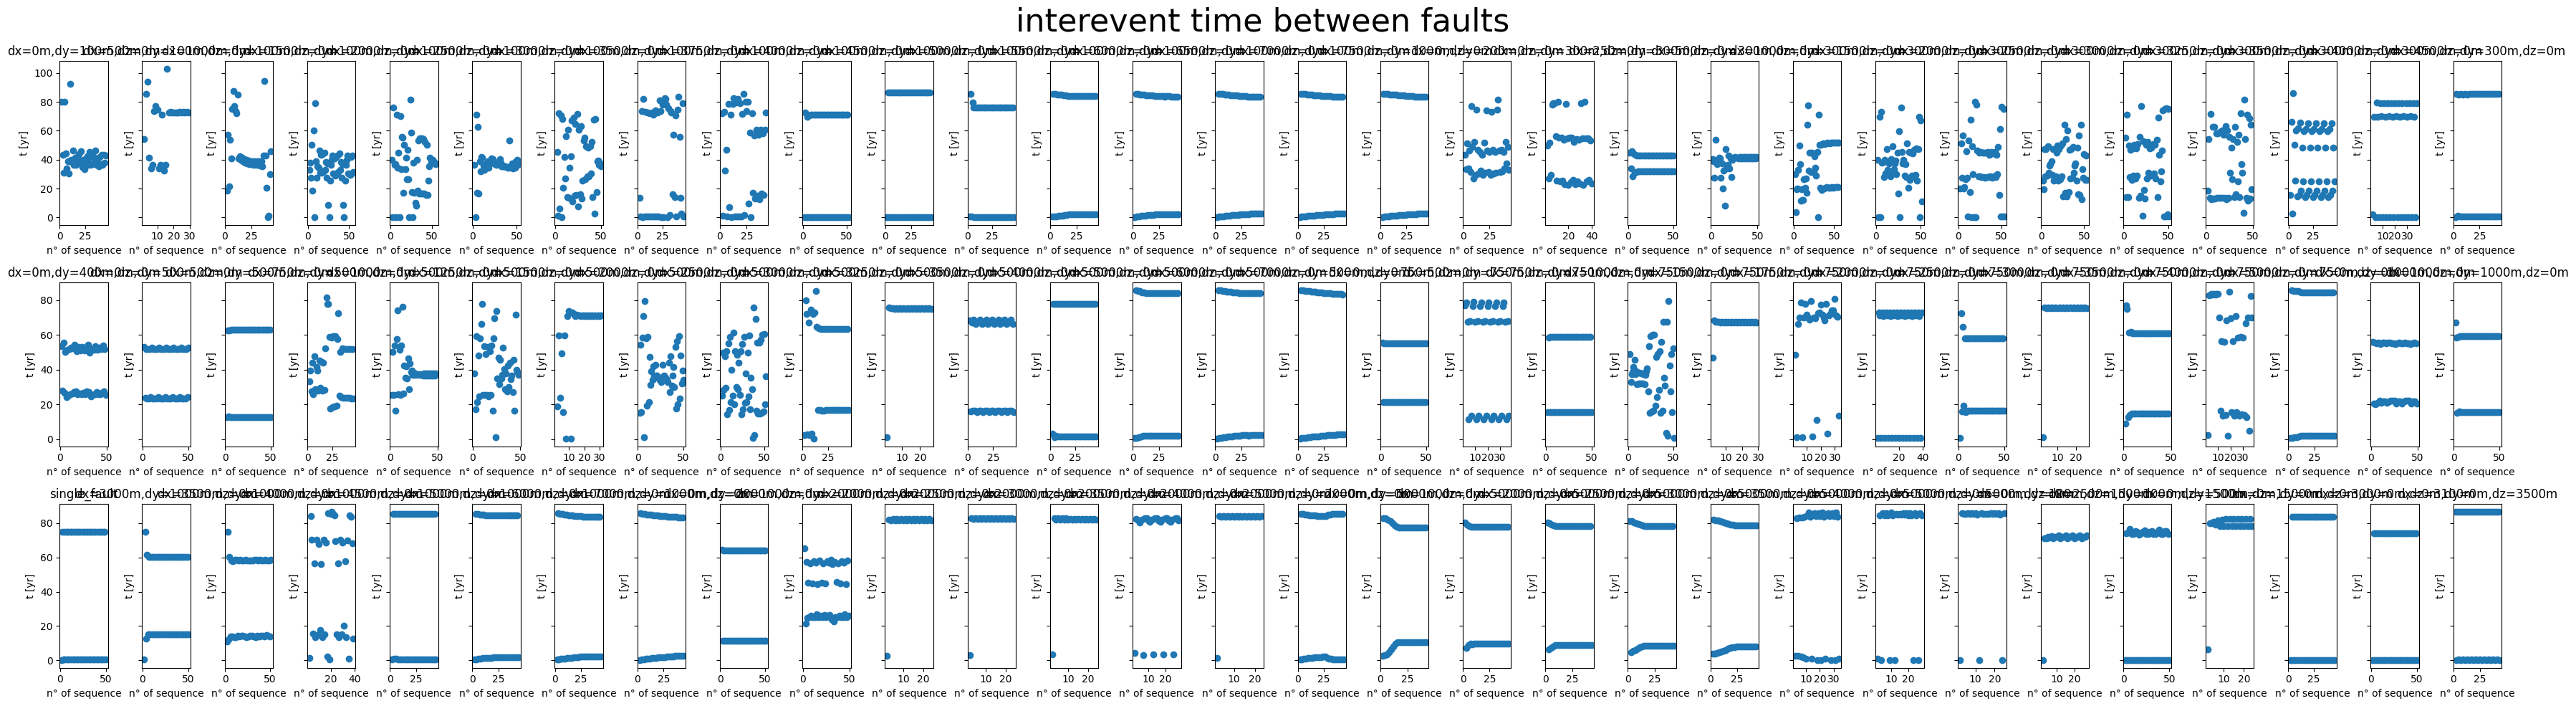

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Assuming you have the necessary variables defined already

n_models = len(models_dict) - 1
fig, ax = plt.subplots(nrows=3, ncols=n_models // 3, figsize=(35, 10), squeeze=False, sharey='row')
models_list = [[re.search(r'_(\d+)x_', name).group(1),re.search(r'_(\d+)y_', name).group(1),re.search(r'_(\d+)z',name).group(1)]
               for name in models_dict if name != 'mod_def'] + ['single_fault']

# Append suffix / prefix to strings in list label models
label_models = ['dx='+sub[0]+'m,dy='+sub[1]+'m,dz='+sub[2]+'m' for sub in models_list[:-1] if sub != 'single_fault'] + ['single_fault']

key_list = list(models_dict)

for i, model_name in enumerate(key_list):

    model_dict = models_dict[model_name]
    
    df_ev1 = model_dict["ev"][1]
    if 2 in model_dict['ev']:
        df_ev2 = model_dict["ev"][2]
        df_seq_model = model_dict["seq"]["1_2"]
        
    row = 0 if i < (n_models // 3) else 1 if i < 2 * (n_models // 3) else 2
    col = i % (n_models // 3)

    ax[row, col].set_title(label_models[i])
    
    # plot recurrence interval between faults
    # Recurrence interval between faults
    if 2 in model_dict['ev']:
        ax[row, col].scatter(df_seq_model.index, df_seq_model["t_interevent_interfault"] / t_yr, marker="o")
        ax[row, col].set_xlabel("n° of sequence")
        ax[row, col].set_ylabel("t [yr]")

fig.suptitle("interevent time between faults", fontsize=32)
fig.tight_layout()
plt.show()


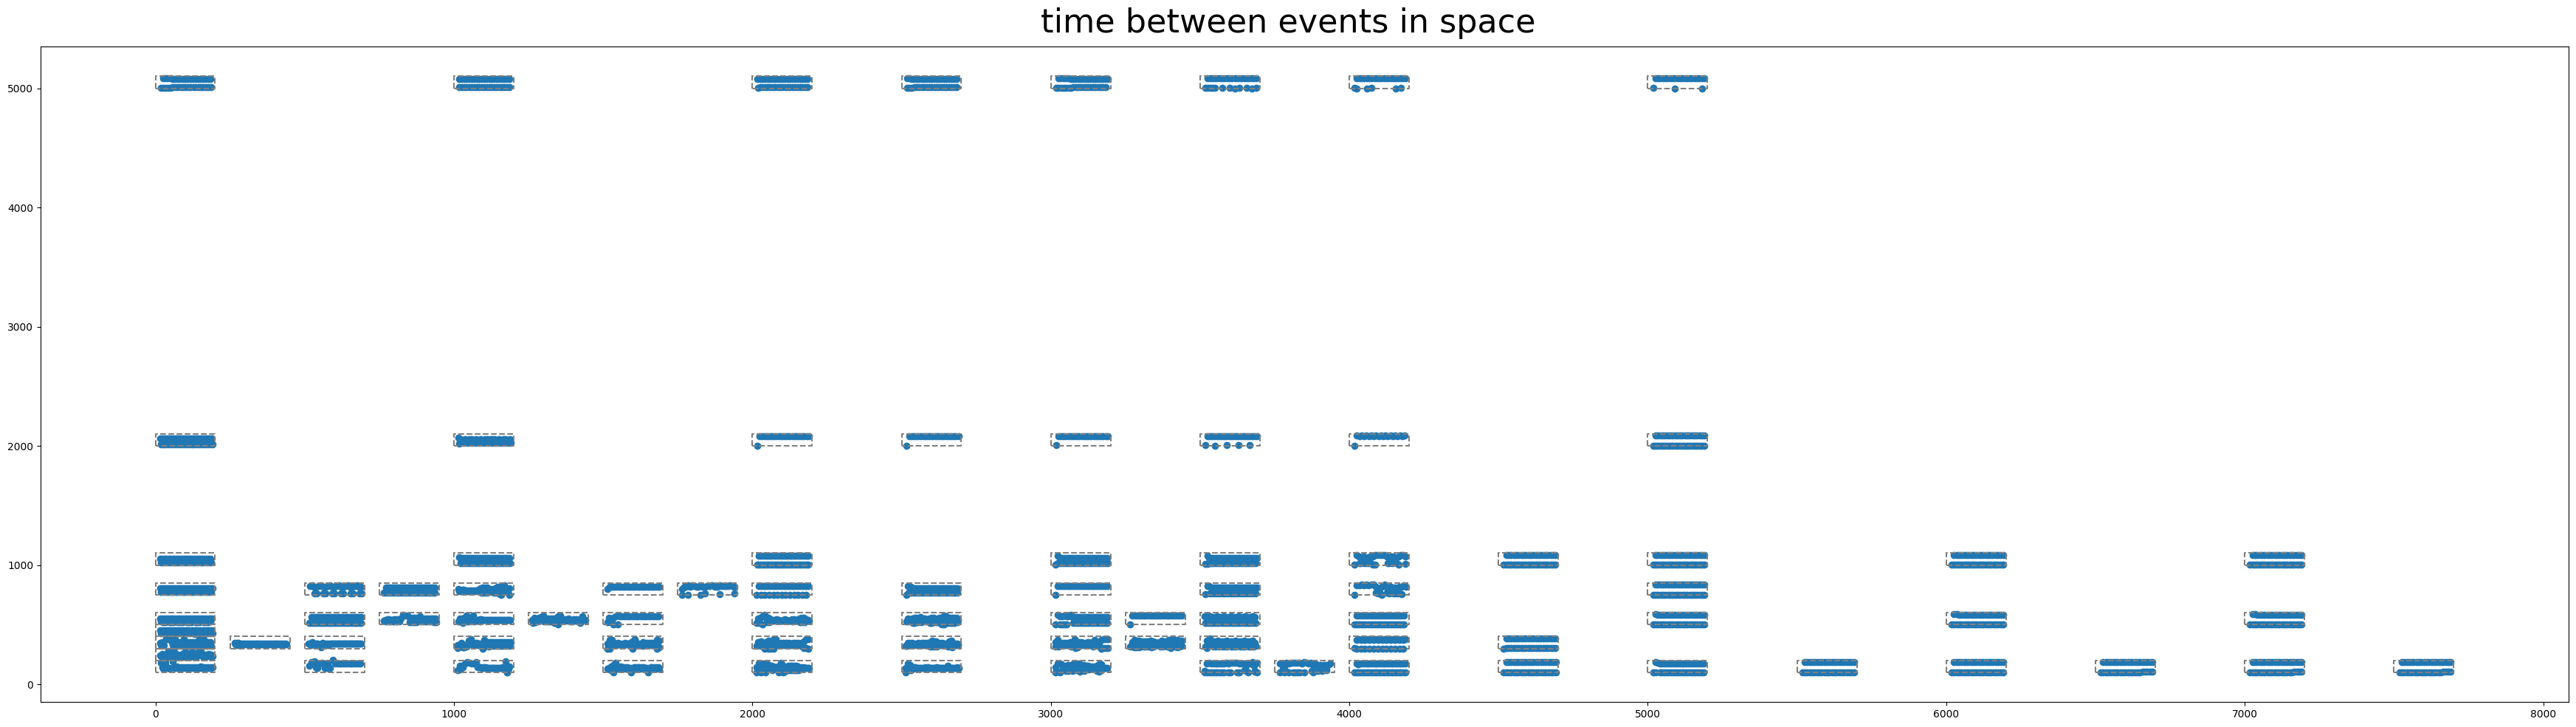

In [12]:
# synchro series in space

# plot time series synchronicity

# Assuming you have the necessary variables defined already

n_models = len(models_dict)
fig, ax = plt.subplots(figsize=(35, 10))
models_list = [[re.search(r'_(\d+)x_', name).group(1),re.search(r'_(\d+)y_', name).group(1),re.search(r'_(\d+)z',name).group(1)]
               for name in models_dict if name != 'mod_def'] + ['single_fault']

# Append suffix / prefix to strings in list label models
label_models = ['dx='+sub[0]+'m,dy='+sub[1]+'m,dz='+sub[2]+'m' for sub in models_list[:] if sub != 'single_fault'] + ['single_fault']

key_list = list(models_dict)

for i, model_name in enumerate(key_list):

    model_dict = models_dict[model_name]

    if "ev_comb_faults" in model_dict:
    
        df_ev = models_dict[model_name]["ev_comb_faults"]
        
        # ax[row, col].set_title(label_models[i])
        
        # plot recurrence interval between faults
        # Recurrence interval between faults

        df_ev1 = model_dict["ev"][1]
        if 2 in model_dict['ev']:
            df_ev2 = model_dict["ev"][2]
            df_seq_model = model_dict["seq"]["1_2"]

        if model_name != 'mod_def':
            try:
                name=model_name
                dx = int(re.search(r'_(\d+)x_', name).group(1))
                dy = int(re.search(r'_(\d+)y_', name).group(1))
                dz = int(re.search(r'_(\d+)z', name).group(1))
            except:
                print(f"error with name {model_name}")

            if dz == 0:
                if 2 in model_dict['ev']:
                    ax.scatter(df_seq_model['min_t'] / .33e9 + dx, df_seq_model["t_interevent_interfault"] / t_yr + dy, marker="o", color=f'C0')
                    ax.plot([dx, dx, dx+200, dx+200, dx],[dy, dy+100, dy+100, dy, dy],color='grey',ls='--')
                    

fig.suptitle("time between events in space", fontsize=32)

fig.tight_layout()
plt.show()

fig.savefig("intertime_space.pdf", bbox_inches='tight')

                      Location  Separation (m)  Overlap (m)   AR  \
291  Southern Apennines, Italy          6914.0       7690.0  1.1   
292  Southern Apennines, Italy          5144.0       6251.0  1.2   
293  Southern Apennines, Italy         14228.0       8523.0  0.6   
294  Southern Apennines, Italy         12044.0       8382.0  0.7   
295  Southern Apennines, Italy         11842.0      25391.0  2.1   

     Corrected Overlap (m)  Corrected AR  Total Length     CV Rock Type(s)  \
291                    NaN           NaN       50966.0  0.585          NaN   
292                    NaN           NaN       51248.0  0.631          NaN   
293                    NaN           NaN       33107.0  0.360          NaN   
294                    NaN           NaN       67095.0  0.582          NaN   
295                    NaN           NaN       81703.0  0.525          NaN   

    Fault Linkage  Data Type Data Sources Partial  
291           NaN  Fieldwork         QGIS       N  
292           NaN 

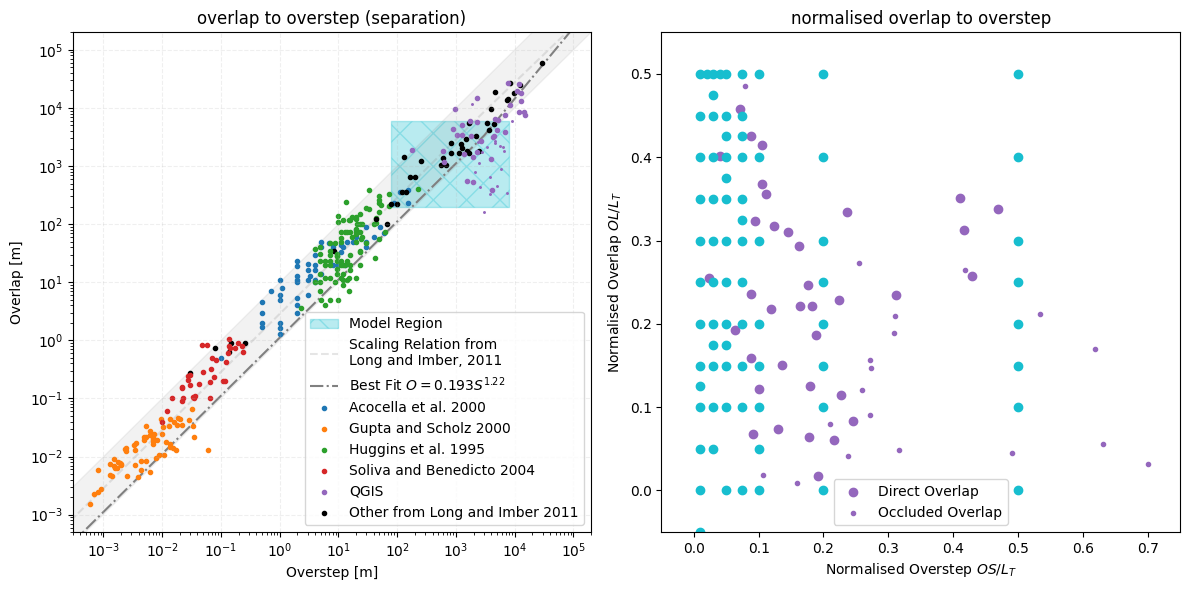

In [13]:
fig, axs=plt.subplots(ncols=2, figsize=(12,6))
ax = axs[0]
ax1 = axs[1]

for i, model_name in enumerate(key_list):

    model_dict = models_dict[model_name]

    if "ev_comb_faults" in model_dict:
    
        df_ev = models_dict[model_name]["ev_comb_faults"]
        
        # ax[row, col].set_title(label_models[i])
        
        # plot recurrence interval between faults
        # Recurrence interval between faults

        df_ev1 = model_dict["ev"][1]
        if 2 in model_dict['ev']:
            df_ev2 = model_dict["ev"][2]
            df_seq_model = model_dict["seq"]["1_2"]

        if model_name != 'mod_def':
            try:
                name=model_name
                dx = int(re.search(r'_(\d+)x_', name).group(1))
                dy = int(re.search(r'_(\d+)y_', name).group(1))
                dz = int(re.search(r'_(\d+)z', name).group(1))
            except:
                print(f"error with name {model_name}")

            if dz == 0:
                if 2 in model_dict['ev']:
                    # ax.scatter(dy,5000 - dx, marker=".", color=f'C9')
                    ax1.scatter(dy / 10000,(5000 - dx)/10000, marker="o", color=f'C9')


# ax.scatter(dy,5000 - dx, marker=".", color=f'C9', label='2 Fault Models')


space=np.linspace(0.,300000.,100)

ax.fill_between([80,8000],[6000,6000],[200,200],hatch='x', color='C9', alpha=0.3, zorder=0.3, label='Model Region')

ax.fill_between(space, 10 * space, 1 * space, color='grey', alpha=0.1, zorder=0.4)
# ax.fill_between(space, 0.22 * space ** 1.23, 0.16*space**1.21, color='grey', alpha=0.2, zorder=0.4)


ax.plot(space, 3.634 * space**0.97, color='grey', ls='--',zorder=0.5, alpha=0.2,label='Scaling Relation from \nLong and Imber, 2011')
ax.plot(space, 0.19 * space**1.22, color='grey', ls='-.',zorder=0.5, label=r'Best Fit $O = 0.193 S^{1.22}$')

litdata = pd.read_csv("Long.csv", sep=',', header=1)

for author in litdata['Data Sources'].unique():
    authordata = litdata[litdata['Data Sources'] == author]
    if len(authordata) >= 10 and author != 'QGIS':
        ax.scatter(authordata['Separation (m)'], authordata['Overlap (m)'], zorder=0.9, marker='.', label=f'{author}')
    elif author == 'QGIS':
        ax.scatter(authordata[authordata['Partial'] == 'N']['Separation (m)'], authordata[authordata['Partial'] == 'N']['Overlap (m)'],
                   zorder=0.9,color='C4', marker='.', label=f'{author}')
        ax.scatter(authordata[authordata['Partial'] == 'Y']['Separation (m)'], authordata[authordata['Partial'] == 'Y']['Overlap (m)'],
                   zorder=0.9,color='C4', marker='.', s=5)
    
    else:
        ax.scatter(authordata['Separation (m)'], authordata['Overlap (m)'], zorder=0.9, marker='.', color='k')

ax.scatter(dy,5000 - dx, marker=".", color='k', label='Other from Long and Imber 2011')

qgisdata = litdata[litdata['Data Sources'] == 'QGIS']

print(qgisdata.head())

ax1.scatter(qgisdata[qgisdata['Partial'] == 'N']['Separation (m)'] / (qgisdata[qgisdata['Partial'] == 'N']['Total Length']),
            qgisdata[qgisdata['Partial'] == 'N']['Overlap (m)'] / (qgisdata[qgisdata['Partial'] == 'N']['Total Length']), color='C4',zorder=0.9, label='Direct Overlap')

ax1.scatter(qgisdata[qgisdata['Partial'] == 'Y']['Separation (m)'] / (qgisdata[qgisdata['Partial'] == 'Y']['Total Length']),
            qgisdata[qgisdata['Partial'] == 'Y']['Overlap (m)'] / (qgisdata[qgisdata['Partial'] == 'Y']['Total Length']), color='C4',zorder=0.9, marker='.', label='Occluded Overlap')


ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Overstep [m]")
ax.set_ylabel("Overlap [m]")

ax1.set_xlabel(f"Normalised Overstep $OS/L_T$")
ax1.set_ylabel(f"Normalised Overlap $OL/L_T$")

ax.set_ylim(0.0005,200000)
ax.set_xlim(0.0003,200000)

ax.grid(visible=True, which='major', axis='both', zorder=0.1, alpha=0.2, ls='--')

ax.legend()
ax1.legend()

ax1.set_ylim(-0.05,0.55)
ax1.set_xlim(-0.05,0.75)

ax.set_title("overlap to overstep (separation)")
ax1.set_title("normalised overlap to overstep")

fig.tight_layout()
plt.show()

                      Location  Separation (m)  Overlap (m)   AR  \
291  Southern Apennines, Italy          6914.0       7690.0  1.1   
292  Southern Apennines, Italy          5144.0       6251.0  1.2   
293  Southern Apennines, Italy         14228.0       8523.0  0.6   
294  Southern Apennines, Italy         12044.0       8382.0  0.7   
295  Southern Apennines, Italy         11842.0      25391.0  2.1   

     Corrected Overlap (m)  Corrected AR  Total Length     CV Rock Type(s)  \
291                    NaN           NaN       50966.0  0.585          NaN   
292                    NaN           NaN       51248.0  0.631          NaN   
293                    NaN           NaN       33107.0  0.360          NaN   
294                    NaN           NaN       67095.0  0.582          NaN   
295                    NaN           NaN       81703.0  0.525          NaN   

    Fault Linkage  Data Type Data Sources Partial  
291           NaN  Fieldwork         QGIS       N  
292           NaN 

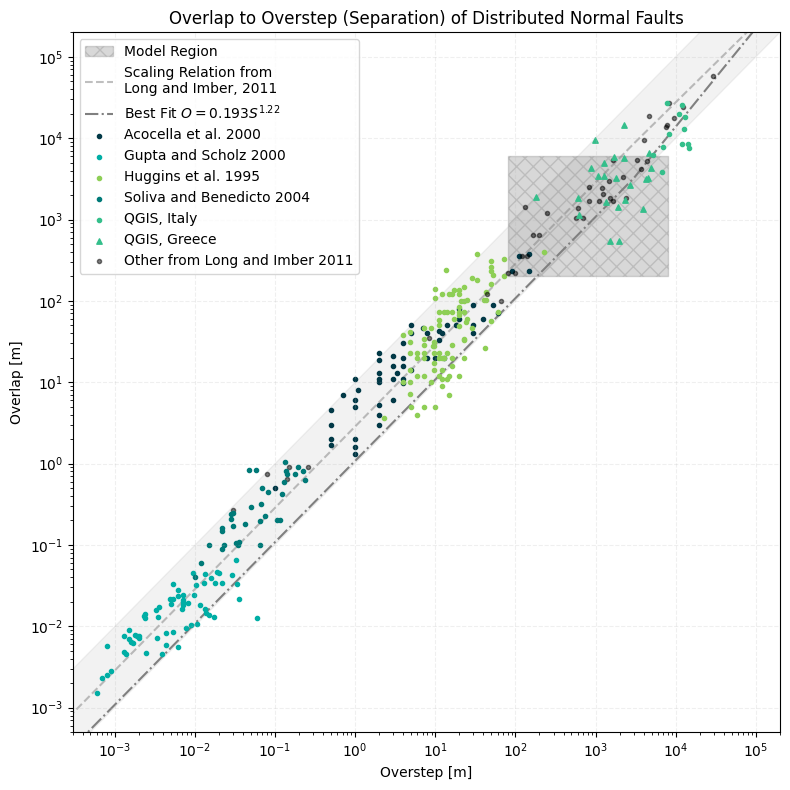

In [14]:
fig, axs=plt.subplots(figsize=(8,8))
ax = axs

space=np.linspace(0.,300000.,100)

ax.fill_between([80,8000],[6000,6000],[200,200],hatch='xx', color='grey', alpha=0.3, zorder=0.3, label='Model Region')

ax.fill_between(space, 10 * space, 1 * space, color='grey', alpha=0.1, zorder=0.4)
# ax.fill_between(space, 0.22 * space ** 1.23, 0.16*space**1.21, color='grey', alpha=0.2, zorder=0.4)

aries_colors = ["#023947","#00AEA5","#8ECF56","#007A78","#34BF8B"]

ax.plot(space, 3.634 * space**0.97, color='grey', ls='--',zorder=0.5, alpha=0.5,label='Scaling Relation from \nLong and Imber, 2011')
ax.plot(space, 0.20 * space**1.21, color='grey', ls='-.',zorder=0.5, label=r'Best Fit $O = 0.193 S^{1.22}$')

litdata = pd.read_csv("Long.csv", sep=',', header=1)
i=0

for author in litdata['Data Sources'].unique():
    authordata = litdata[litdata['Data Sources'] == author]
    if len(authordata) >= 10 and author != 'QGIS':
        ax.scatter(authordata['Separation (m)'], authordata['Overlap (m)'], zorder=0.9, marker='.', label=f'{author}', color=aries_colors[i])
        i+=1
    elif author == 'QGIS':
        italydata = authordata[(authordata['Partial'] == 'N') & (authordata['Location'] != 'Corinth Region, Greece') & (authordata['AR'] >= 0.25)]
        greecedata = authordata[(authordata['Partial'] == 'N') & (authordata['Location'] == 'Corinth Region, Greece') & (authordata['AR'] >= 0.25)]
        
        ax.scatter(italydata[italydata['Partial'] == 'N']['Separation (m)'], italydata[italydata['Partial'] == 'N']['Overlap (m)'],
                   zorder=0.9,color=aries_colors[-1], marker='.', label=f'{author}, Italy')

        ax.scatter(greecedata[greecedata['Partial'] == 'N']['Separation (m)'], greecedata[greecedata['Partial'] == 'N']['Overlap (m)'],
                   zorder=0.9,color=aries_colors[-1], marker='^',s=15, label=f'{author}, Greece')
        
    
        #ax.scatter(authordata[authordata['Partial'] == 'Y']['Separation (m)'], authordata[authordata['Partial'] == 'Y']['Overlap (m)'],
        #           zorder=0.9,color=aries_colors[-1], marker='.', s=5)
    
    else:
        ax.scatter(authordata['Separation (m)'], authordata['Overlap (m)'], zorder=0.9, marker='.', color='k',alpha=0.5)

ax.scatter(dy,5000 - dx, marker=".", color='k',alpha=0.5, label='Other from Long and Imber 2011')

qgisdata = litdata[litdata['Data Sources'] == 'QGIS']

print(qgisdata.head())

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Overstep [m]")
ax.set_ylabel("Overlap [m]")

ax.set_ylim(0.0005,200000)
ax.set_xlim(0.0003,200000)

ax.grid(visible=True, which='major', axis='both', zorder=0.1, alpha=0.2, ls='--')

ax.legend()

ax.set_title("Overlap to Overstep (Separation) of Distributed Normal Faults")

fig.tight_layout()
plt.show()

In [15]:
import numpy as np
from scipy.optimize import curve_fit
litdata = pd.read_csv("Long.csv", sep=',', header=1)
# Data
separation = np.array(litdata[(litdata['Partial'] != 'Y')  & (litdata['AR'] >= 0.25)]['Separation (m)'])  # fill in the separation data
overlap = np.array(litdata[(litdata['Partial'] != 'Y')  & (litdata['AR'] >= 0.25)]['Overlap (m)'])  # fill in the overlap data
length = np.array(qgisdata[(qgisdata['Partial'] != 'Y')  & (qgisdata['AR'] >= 0.25)]['Total Length'])  # fill in the overlap data

# Define the model
def model(x, a, b):
    return a * x ** b


# Fit the model to the data
params, covariance = curve_fit(model, separation, overlap, p0=(3.634,0.97), method='trf')

# Extract the coefficients
a, b = params

perr = np.sqrt(np.diag(covariance))

# Output the results
print(f"Fitted parameters:")
print(f"a = {a:.4e} ± {perr[0]:.4e}")
print(f"b = {b:.4e} ± {perr[1]:.4e}")

separation = np.array(qgisdata[(qgisdata['Partial'] != 'Y')  & (qgisdata['AR'] >= 0.25)]['Separation (m)'])  # fill in the overlap data
overlap = np.array(qgisdata[(qgisdata['Partial'] != 'Y')  & (qgisdata['AR'] >= 0.25)]['Overlap (m)'])  # fill in the overlap data

params, covariance = curve_fit(model, length, overlap)

# Extract the coefficients
a, b = params
perr = np.sqrt(np.diag(covariance))

# Output the results
print(f"Fitted parameters:")
print(f"a = {a:.4e} ± {perr[0]:.4e}")
print(f"b = {b:.4e} ± {perr[1]:.4e}")

params, covariance = curve_fit(model, length, separation)

# Extract the coefficients
a, b = params

perr = np.sqrt(np.diag(covariance))

# Output the results
print(f"Fitted parameters:")
print(f"a = {a:.4e} ± {perr[0]:.4e}")
print(f"b = {b:.4e} ± {perr[1]:.4e}")

Fitted parameters:
a = 1.9867e-01 ± 3.3339e-02
b = 1.2197e+00 ± 1.4821e-02
Fitted parameters:
a = 1.0094e-01 ± 1.9924e-01
b = 1.0765e+00 ± 1.7996e-01
Fitted parameters:
a = 3.4351e-01 ± 5.2820e-01
b = 9.3176e-01 ± 1.4074e-01


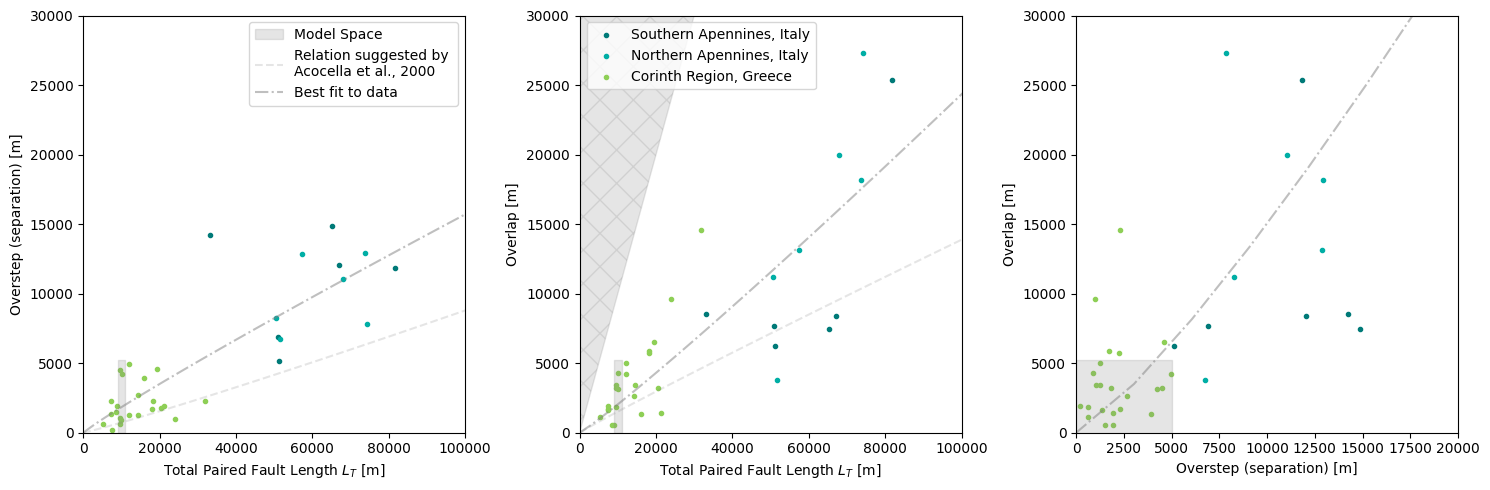

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(15,5))

for i, model_name in enumerate(key_list):

    model_dict = models_dict[model_name]

    if "ev_comb_faults" in model_dict:
    
        df_ev = models_dict[model_name]["ev_comb_faults"]
        
        # ax[row, col].set_title(label_models[i])
        
        # plot recurrence interval between faults
        # Recurrence interval between faults

        df_ev1 = model_dict["ev"][1]
        if 2 in model_dict['ev']:
            df_ev2 = model_dict["ev"][2]
            df_seq_model = model_dict["seq"]["1_2"]

        if model_name != 'mod_def':
            try:
                name=model_name
                dx = int(re.search(r'_(\d+)x_', name).group(1))
                dy = int(re.search(r'_(\d+)y_', name).group(1))
                dz = int(re.search(r'_(\d+)z', name).group(1))
            except:
                print(f"error with name {model_name}")

            if dz == 0:
                if 2 in model_dict['ev']:
                    #ax[0].scatter(10000,dy, marker=".", color=f'C9')
                    #ax[1].scatter(10000,5000-dx, marker=".", color=f'C9')
                    #ax[2].scatter(dy,5000-dx, marker=".", color=f'C9')
                    pass

colors = ['#007a78','#00aea5','#8ecf56']
ic = 0

for location in qgisdata['Location'].unique():
    loc_data = qgisdata[qgisdata['Location'] == location]
    ax[0].scatter(loc_data[(loc_data['Partial'] == 'N') & (loc_data['AR'] >= 0.25)]['Total Length'],
                  loc_data[(loc_data['Partial'] == 'N') & (loc_data['AR'] >= 0.25)]['Separation (m)'], marker='.',color=colors[ic])
    ax[1].scatter(loc_data[(loc_data['Partial'] == 'N') & (loc_data['AR'] >= 0.25)]['Total Length'],
                  loc_data[(loc_data['Partial'] == 'N') & (loc_data['AR'] >= 0.25)]['Overlap (m)'], marker='.', label=location,color=colors[ic])
    ax[2].scatter(loc_data[(loc_data['Partial'] == 'N') & (loc_data['AR'] >= 0.25)]['Separation (m)'],
                  loc_data[(loc_data['Partial'] == 'N') & (loc_data['AR'] >= 0.25)]['Overlap (m)'], marker='.',color=colors[ic])

    ic +=1

ax[0].fill_between([9000,11000],[5250,5250],[0,0],color='grey', alpha=0.2, label='Model Space')
ax[1].fill_between([9000,11000],[5250,5250],[0,0],color='grey', alpha=0.2)
ax[2].fill_between([0, 5000],[5250,5250],[-100,-100],color='grey', alpha=0.2)

ax[1].fill_between([0,1000000],[0,1000000],[1000000,1000000],color='grey',hatch='x', alpha=0.2)

ax[0].plot(space, 0.035*space**1.08, label='Relation suggested by \nAcocella et al., 2000',color='grey', alpha=0.2, ls='--')
ax[1].plot(space, 0.22*space**0.96,color='grey', alpha=0.2, ls='--')

ax[1].plot(space, 0.1009*space**1.0765, alpha=0.5, ls='-.',color='grey')
ax[0].plot(space, 0.3435*space**0.932,color='grey', alpha=0.5, ls='-.', label='Best fit to data')
ax[2].plot(space, 0.19867 * space**1.2197, color='grey', ls='-.',alpha=0.5)

log_ = False

min_ = 0
if log_:
    min_ = 100

ax[0].set_xlim(min_,100000)
ax[1].set_xlim(min_,100000)
ax[2].set_xlim(min_,20000)

ax[0].set_ylim(min_,30000)
ax[1].set_ylim(min_,30000)
ax[2].set_ylim(min_,30000)

ax[0].set_ylabel('Overstep (separation) [m]')
ax[1].set_ylabel('Overlap [m]')

ax[2].set_ylabel('Overlap [m]')

ax[0].set_xlabel(f'Total Paired Fault Length $L_T$ [m]')
ax[1].set_xlabel(f'Total Paired Fault Length $L_T$ [m]')

ax[2].set_xlabel('Overstep (separation) [m]')

ax[0].legend()
ax[1].legend()

if log_:
    ax[0].set_yscale("log")
    ax[0].set_xscale("log")
    
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

fig.tight_layout()

## 4.3. Plot mean and std of max and min interevent time between faults

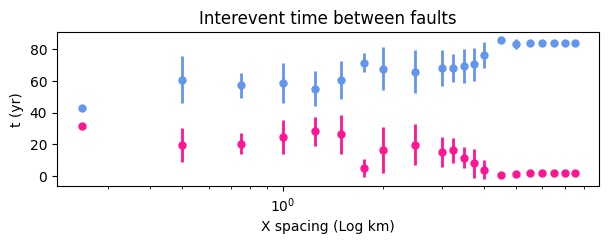

In [17]:
import matplotlib

# Filter the DataFrame to include only rows with "fault_label"==1 and "fault_label"==2
df_fault1 = df_ev_all[df_ev_all['fault_label'] == 1]
df_fault2 = df_ev_all[df_ev_all['fault_label'] == 2]

# Group the DataFrame by "dx"
grouped1 = df_fault1.groupby('dx')
grouped2 = df_fault2.groupby('dx')

# mean and standard deviation of sequences (t interevent interfault)

df_seq_max = df_seq[df_seq['t_interevent_interfault'] / t_yr >= 40]
df_seq_min = df_seq[df_seq['t_interevent_interfault'] / t_yr < 40]

grouped_max = df_seq_max.groupby('dx')
grouped_min = df_seq_min.groupby('dx')

mean_max = grouped_max['t_interevent_interfault'].mean()
std_max = grouped_max['t_interevent_interfault'].std()
mean_min = grouped_min['t_interevent_interfault'].mean()
std_min = grouped_min['t_interevent_interfault'].std()

data_max = pd.DataFrame({"mean":mean_max, "std": std_max}).reset_index()
data_min = pd.DataFrame({"mean":mean_min, "std": std_min}).reset_index()


# plot intervent time between faults
matplotlib.rcParams['pdf.fonttype'] = 42 

# Create a subplot with a size of (1, 1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 2), squeeze=False)

# Create a log-scale x-axis
for i, axi in enumerate(ax.flat):
    axi.set_xscale('log')
    
# Plot mean and std of intervent time for each dy
ax[0,0].errorbar(data_max["dx"] / 1000,data_max["mean"]/t_yr, data_max["std"]/t_yr, linestyle='None', marker='o', markersize=5, c= "cornflowerblue", elinewidth=2.0 )
ax[0,0].errorbar(data_min["dx"] / 1000,data_min["mean"]/t_yr, data_min["std"]/t_yr, linestyle='None', marker='o', markersize=5, c= "deeppink", elinewidth=2.0 )

# Add labels
ax[0,0].set_xlabel('X spacing (Log km)')
ax[0,0].set_ylabel('t (yr)')
ax[0,0].set_title('Interevent time between faults')
# ax[0,0].set_ylim(top=40)

fig.savefig("InterfaultTime_small_dy.pdf", bbox_inches='tight')

## 4.4. Plot time-series syncronicity 

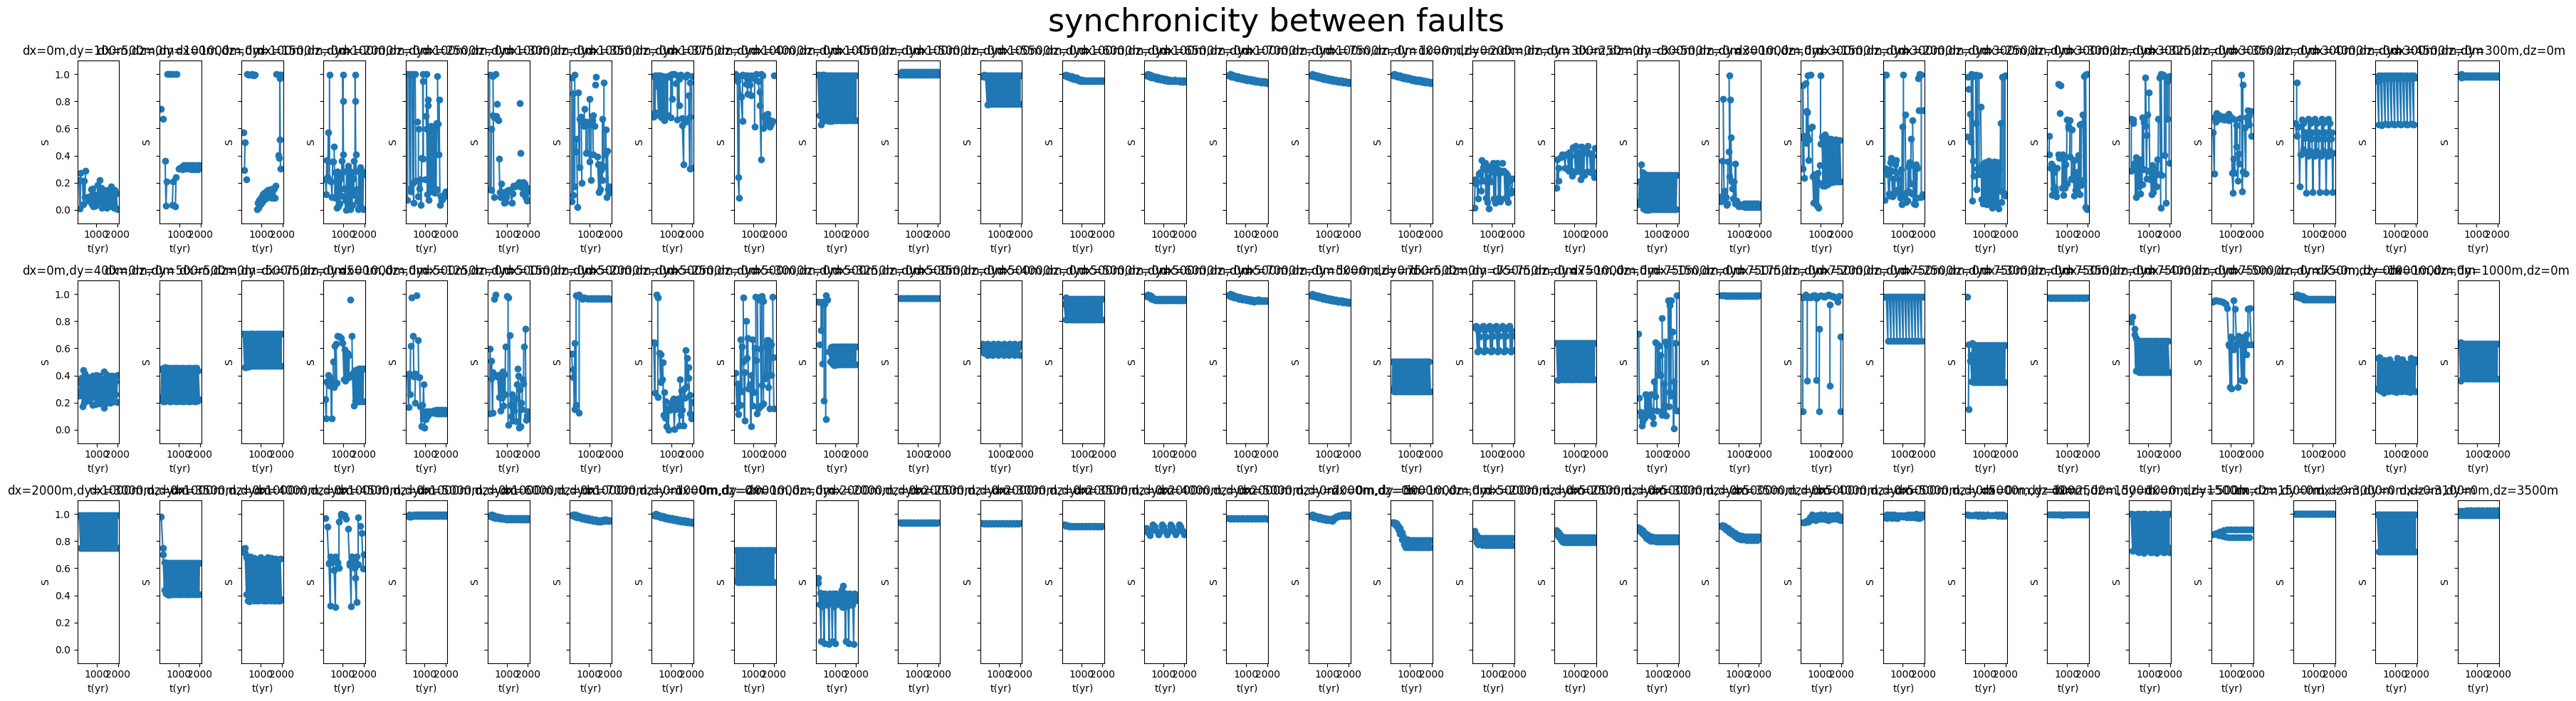

In [18]:
# plot time series synchronicity

# Assuming you have the necessary variables defined already

n_models = len(models_dict)
fig, ax = plt.subplots(nrows=3, ncols=n_models//3, figsize=(35, 10), squeeze=False, sharey='row')
models_list = [[re.search(r'_(\d+)x_', name).group(1),re.search(r'_(\d+)y_', name).group(1),re.search(r'_(\d+)z',name).group(1)]
               for name in models_dict if name != 'mod_def'] + ['single_fault']

# Append suffix / prefix to strings in list label models
label_models = ['dx='+sub[0]+'m,dy='+sub[1]+'m,dz='+sub[2]+'m' for sub in models_list[:] if sub != 'single_fault'] + ['single_fault']

key_list = list(models_dict)

for i, model_name in enumerate(key_list):

    model_dict = models_dict[model_name]

    if "ev_comb_faults" in model_dict:
    
        df_ev = models_dict[model_name]["ev_comb_faults"]
        row = 0 if i < n_models//3 else 1 if i < 2*n_models//3 else 2
        col = i % (n_models//3)
    
        ax[row, col].set_title(label_models[i])
        
        # plot recurrence interval between faults
        # Recurrence interval between faults
    
        ax[row, col].plot(df_ev["min_t"]/t_yr, df_ev["synchronicity"])
        ax[row, col].scatter(df_ev["min_t"]/t_yr, df_ev["synchronicity"], marker="o")
        ax[row, col].set_xlabel("t(yr)")
        ax[row, col].set_ylabel("S")
        ax[row, col].set_ylim(-0.1,1.1)

fig.suptitle("synchronicity between faults", fontsize=32)

fig.tight_layout()
plt.show()

fig.savefig("synchro_all.pdf", bbox_inches='tight')

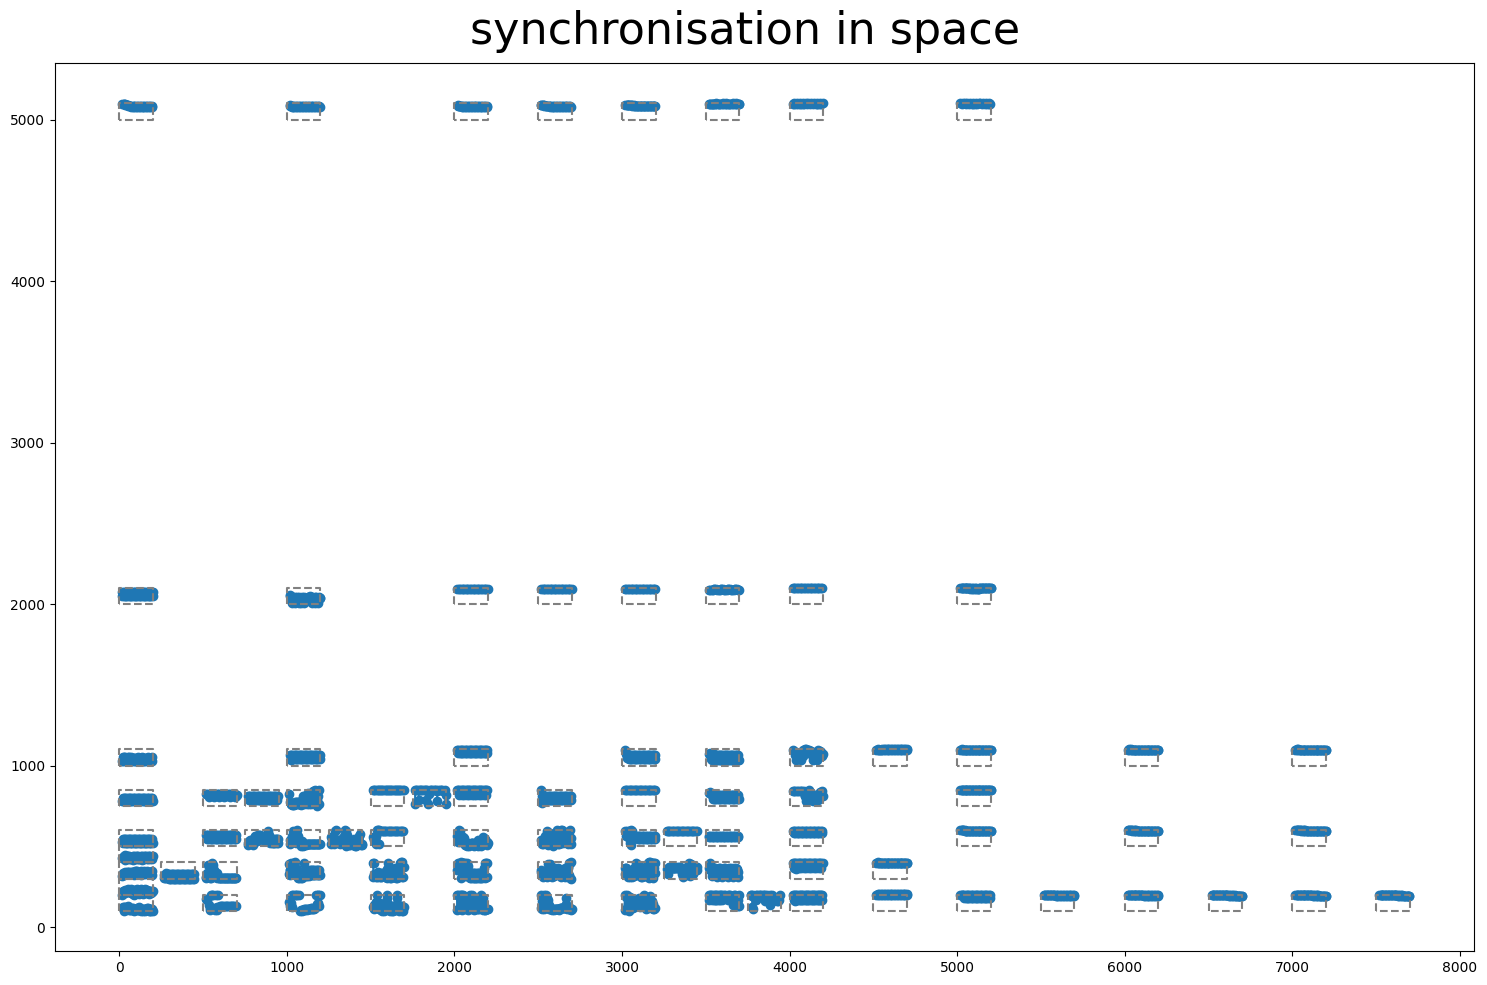

In [19]:
# synchro series in space

# plot time series synchronicity

# Assuming you have the necessary variables defined already

n_models = len(models_dict)
fig, ax = plt.subplots(figsize=(15, 10))
models_list = [[re.search(r'_(\d+)x_', name).group(1),re.search(r'_(\d+)y_', name).group(1),re.search(r'_(\d+)z',name).group(1)]
               for name in models_dict if name != 'mod_def'] + ['single_fault']

# Append suffix / prefix to strings in list label models
label_models = ['dx='+sub[0]+'m,dy='+sub[1]+'m,dz='+sub[2]+'m' for sub in models_list[:] if sub != 'single_fault'] + ['single_fault']

key_list = list(models_dict)

for i, model_name in enumerate(key_list):

    model_dict = models_dict[model_name]

    if "ev_comb_faults" in model_dict:
    
        df_ev = models_dict[model_name]["ev_comb_faults"]
        
        # ax[row, col].set_title(label_models[i])
        
        # plot recurrence interval between faults
        # Recurrence interval between faults

        if model_name != 'mod_def':
            try:
                name=model_name
                dx = int(re.search(r'_(\d+)x_', name).group(1))
                dy = int(re.search(r'_(\d+)y_', name).group(1))
                dz = int(re.search(r'_(\d+)z', name).group(1))
            except:
                print(f"error with name {model_name}")

            if dz == 0:
                
                ax.plot(df_ev["min_t"]/t_yr / 10 + dx, df_ev["synchronicity"] * 100 + dy, color=f'C0')
                ax.scatter(df_ev["min_t"]/t_yr / 10 + dx, df_ev["synchronicity"] * 100 + dy, marker="o", color=f'C0')

                ax.plot([dx, dx, dx+200, dx+200, dx],[dy, dy+100, dy+100, dy, dy],color='grey',ls='--')
        # ax.set_xlabel("t(yr)")
        # ax.set_ylabel("S")
        # ax.set_ylim(-0.1,1.1)

fig.suptitle("synchronisation in space", fontsize=32)

fig.tight_layout()
plt.show()

fig.savefig("synchro_space.pdf", bbox_inches='tight')

## 4.5. Plot mean and std Synchronicity for all offsets

(-0.1, 1.1)

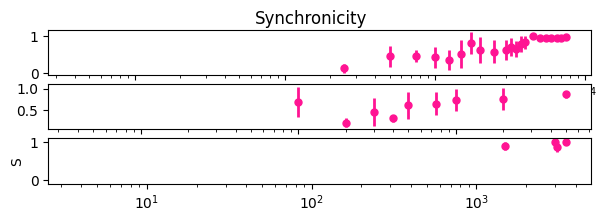

In [20]:
##############################
# For df events fault combined
##############################
# create DataFrame that hosts all the events from all simulations

# array of y offsets
dx_seq = [int(re.search(r'_(\d+)x_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dy_seq = [int(re.search(r'_(\d+)y_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dz_seq = [int(re.search(r'_(\d+)z', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]

for i, model_dict in enumerate(models_dict.values()):
    if 'ev_comb_faults' in model_dict:
        # Get the "seq" DataFrame from the current model_dict
        # comb_faults_df = model_dict["ev_comb_faults"]

        # Add a new column "dy" to the "seq" DataFrame with the corresponding value from dy
        # comb_faults_df["dy"] = dy_seq[i] # for Fault 1

        # Update the "seq" DataFrame in the current model_dict with the new "dy" column
        model_dict["ev_comb_faults"]["dx"] = dx_seq[i]
        model_dict["ev_comb_faults"]["dy"] = dy_seq[i]
        model_dict["ev_comb_faults"]["dz"] = dz_seq[i]

df_seq = pd.concat([model_dict["ev_comb_faults"].assign(model_name=model_name) for model_name, model_dict in list(models_dict.items()) if 'ev_comb_faults' in model_dict])

df_seq.to_csv("events_comb_faults.txt", sep=" ", index=False)

# calculate mean and std of synchronicity
# mean and standard deviation of sequences (t interevent interfault)



### plot synchronicity

# Create a subplot with a size of (1, 1)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7, 2))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')

# Plot mean and std of intervent time for each dy

grouped = df_seq.groupby('dx')

mean_s = grouped['synchronicity'].mean()
std_s = grouped['synchronicity'].std()

sync_stats = pd.DataFrame({"mean":mean_s, "std": std_s}).reset_index()

ax[0].errorbar(sync_stats["dx"],sync_stats["mean"], sync_stats["std"], linestyle='None', marker='o', markersize=5, c= "deeppink", elinewidth=2.0)

grouped = df_seq.groupby('dy')

mean_s = grouped['synchronicity'].mean()
std_s = grouped['synchronicity'].std()

sync_stats = pd.DataFrame({"mean":mean_s, "std": std_s}).reset_index()

ax[1].errorbar(sync_stats["dy"],sync_stats["mean"], sync_stats["std"], linestyle='None', marker='o', markersize=5, c= "deeppink", elinewidth=2.0)

grouped = df_seq.groupby('dz')

mean_s = grouped['synchronicity'].mean()
std_s = grouped['synchronicity'].std()

sync_stats = pd.DataFrame({"mean":mean_s, "std": std_s}).reset_index()

ax[2].errorbar(sync_stats["dz"],sync_stats["mean"], sync_stats["std"], linestyle='None', marker='o', markersize=5, c= "deeppink", elinewidth=2.0)

# Add labels
ax[0].set_xlabel('X, Y, Z offset (Log km)')
ax[2].set_ylabel('S')
fig.suptitle('Synchronicity')
ax[2].set_ylim(-0.1,1.1)

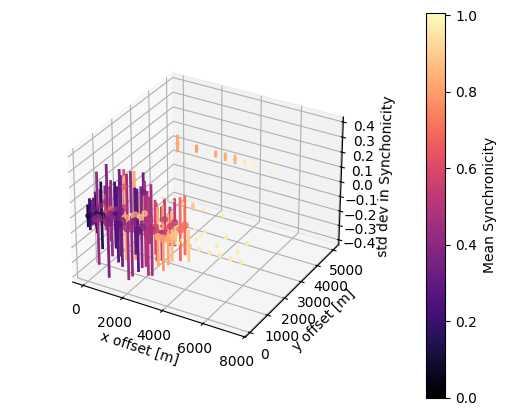

In [21]:
%matplotlib inline

grouped = df_seq.groupby('model_name')

mean_s = grouped['synchronicity'].mean()
std_s = grouped['synchronicity'].std()

sync_stats = pd.DataFrame({"mean":mean_s, "std": std_s}).reset_index()

syncs = sync_stats[:].copy()
syncs['location'] = [[] for _ in range(len(syncs))]
syncs['location'] = syncs.model_name.apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                        ])
mask = syncs['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
syncs = syncs[mask]

import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=syncs['mean'].max())
cmap = plt.get_cmap('magma')

colors = cmap(norm(syncs['mean']))

fig = plt.figure(figsize=(8,5))

ax0 = fig.add_subplot(111, projection='3d')

sc = ax0.scatter(np.array(syncs['location'].apply(lambda loc: loc[0])),
           np.array(syncs['location'].apply(lambda loc: loc[1])),
           np.array(syncs['location'].apply(lambda loc: loc[2])),
           s=syncs['std']*100 + 2,c=syncs['mean'], cmap='magma', vmin=0, vmax=syncs['mean'].max())

for i in range(len(syncs)):
    ax0.errorbar(
        np.array(syncs['location'].apply(lambda loc: loc[0]))[i],
        np.array(syncs['location'].apply(lambda loc: loc[1]))[i],
        np.array(syncs['location'].apply(lambda loc: loc[2]))[i],
        syncs["std"].iloc[i],
        linestyle='None', marker=None,
        color=colors[i], elinewidth=2.0
    )

cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0)
cbar.set_label("Mean Synchronicity")

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")
ax0.set_zlabel("std dev in Synchonicity")
ax0.set_box_aspect(aspect=None, zoom=0.8)

ax0.set_xticks([0,2000,4000,6000,8000],[0,2000,4000,6000,8000])

plt.savefig('3d_synchronicity.png', bbox_inches='tight')


plt.show()

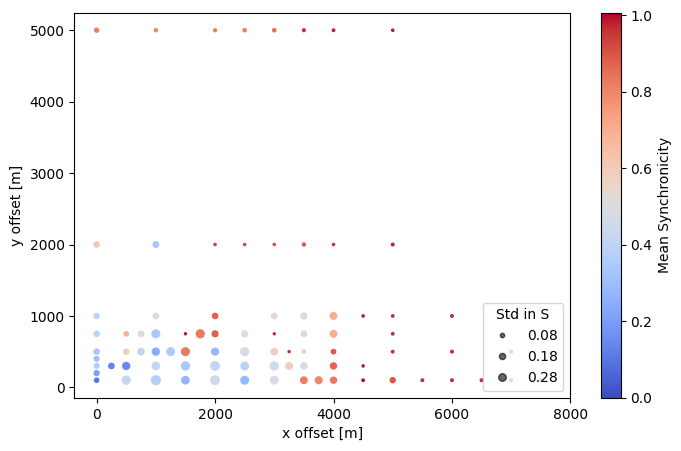

In [22]:
%matplotlib inline

grouped = df_seq.groupby('model_name')

mean_s = grouped['synchronicity'].mean()
std_s = grouped['synchronicity'].std()

sync_stats = pd.DataFrame({"mean":mean_s, "std": std_s}).reset_index()

syncs = sync_stats[:].copy()
syncs['location'] = [[] for _ in range(len(syncs))]
syncs['location'] = syncs.model_name.apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                        ])
mask = syncs['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
syncs = syncs[mask]

import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=syncs['mean'].max())
cmap = plt.get_cmap('coolwarm')

colors = cmap(norm(syncs['mean']))

fig = plt.figure(figsize=(8,5))

ax0 = fig.add_subplot(111)

sc = ax0.scatter(np.array(syncs['location'].apply(lambda loc: loc[0])),
           np.array(syncs['location'].apply(lambda loc: loc[1])),
           s=syncs['std']*100 + 2,c=syncs['mean'], cmap='coolwarm', vmin=0, vmax=syncs['mean'].max())


cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0)
cbar.set_label("Mean Synchronicity")

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")

ax0.set_xticks([0,2000,4000,6000,8000],[0,2000,4000,6000,8000])

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=4)
labels = [int(label.split('{')[1].split('}')[0]) for label in labels]  # Extract numeric part
labels = [(label - 2) / 100 for label in labels]  # Adjust labels
legend = plt.legend(handles, labels, loc="lower right", title="Std in S")

plt.savefig('2d_synchronicity.png', bbox_inches='tight')


plt.show()

### 4.6 Unique Values of Synchronisation

A reasonable way of quantifying the chaos in the synchronicity?

Plots the number of unique values in the synchronisation series, when rounded to 2DP - such that locations with a 'high' CV but predictable resonant behaviour with a constant synchronisation series will have a low number of unique values

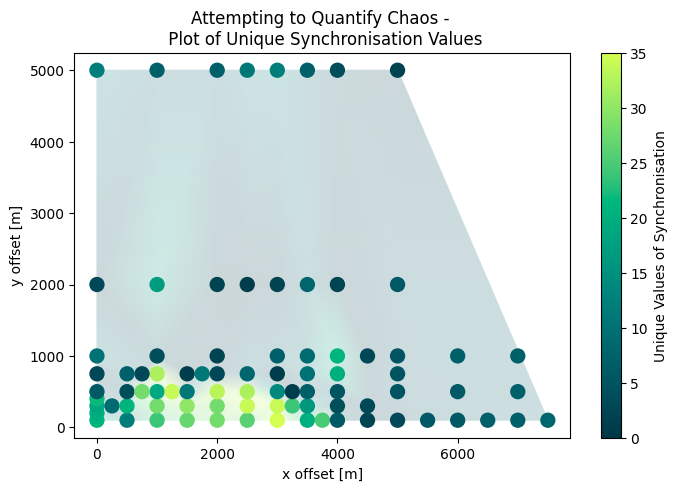

In [23]:
## PLOT of unique values of synchronicity
%matplotlib inline

from matplotlib.colors import LinearSegmentedColormap
import colorspacious as cs

# Define the RGB colors to interpolate between
color1 = [2/255,56/255,70/255]  # dark blue
color2 = [213/255,254/255,82/255]    # Green

# Convert RGB to Lch
lch_start = cs.cspace_convert(color1, "sRGB1", "CIELCh")
lch_end = cs.cspace_convert(color2, "sRGB1", "CIELCh")

# Interpolate in Lch space
num_points = 256
lch_interp = np.linspace(lch_start, lch_end, num_points)

# Convert back to RGB
rgb_interp = np.clip(cs.cspace_convert(lch_interp, "CIELCh", "sRGB1"), 0, 1)

# Create the colormap
aries_cmap = LinearSegmentedColormap.from_list("lch_cmap", rgb_interp)

grouped = df_seq.groupby('model_name')

unique_counts = grouped['synchronicity'].apply(lambda x: x.round(2).nunique())

std_s = grouped['synchronicity'].std()

sync_stats = pd.DataFrame({"unique":unique_counts, "std": std_s}).reset_index()

syncs = sync_stats[:].copy()
syncs['location'] = [[] for _ in range(len(syncs))]
syncs['location'] = syncs.model_name.apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                        ])
mask = syncs['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
syncs = syncs[mask]

from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=syncs['unique'].max())
cmap = plt.get_cmap(aries_cmap)

colors = cmap(norm(syncs['unique']))

fig = plt.figure(figsize=(8,5))

ax0 = fig.add_subplot(111)

ax0.scatter(np.array(syncs['location'].apply(lambda loc: loc[0])),
           np.array(syncs['location'].apply(lambda loc: loc[1])),
           s=100,c=syncs['unique'], cmap=aries_cmap, vmin=0, vmax=syncs['unique'].max())


cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0)
cbar.set_label("Unique Values of Synchronisation")

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")

ax0.set_xticks([0,2000,4000,6000,8000],[0,2000,4000,6000,8000])

alpha=0.2
cls = plt.get_cmap(aries_cmap)(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax0c = ax0.tripcolor(np.array(syncs['location'].apply(lambda loc: loc[0])),
               np.array(syncs['location'].apply(lambda loc: loc[1])),
               np.array(syncs['unique']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none',zorder=-0)


plt.savefig('2d_synchronicity_uniques.png', bbox_inches='tight')

plt.title("Attempting to Quantify Chaos - \n Plot of Unique Synchronisation Values")

plt.show()

In [24]:
'''qc = [3,1,2,4,3,2,5,2,0,0,0,0,0,0,0,0,0,0,2,3,5,3,5,4,0,1,0,0,0,0,0,2,0,1,4,5,1,0,0,0,0,0,0,0,0,3,0,0,0,1,0,1,3,0,1,0,0,0,1,4,0,0,0,0,0,0,0,0,0]

from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors

norm = mcolors.Normalize(vmin=0, vmax=np.array(qc).max())
cmap = plt.get_cmap('magma')

colors = cmap(norm(np.array(qc)))

fig = plt.figure(figsize=(8,5))

ax0 = fig.add_subplot(111)

ax0.scatter(np.array(syncs['location'].apply(lambda loc: loc[0])),
           np.array(syncs['location'].apply(lambda loc: loc[1])),
           s=100,c=qc, cmap='magma', vmin=0, vmax=np.array(qc).max())


cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0)
cbar.set_label("Unique Values of Synchronisation")

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")

ax0.set_xticks([0,2000,4000,6000,8000],[0,2000,4000,6000,8000])

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax0c = ax0.tripcolor(np.array(syncs['location'].apply(lambda loc: loc[0])),
               np.array(syncs['location'].apply(lambda loc: loc[1])),
               qc, cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none',zorder=-0)


# plt.savefig('2d_synchronicity_uniques.png', bbox_inches='tight')

plt.title("Subjective Chaos Quantification")'''


'qc = [3,1,2,4,3,2,5,2,0,0,0,0,0,0,0,0,0,0,2,3,5,3,5,4,0,1,0,0,0,0,0,2,0,1,4,5,1,0,0,0,0,0,0,0,0,3,0,0,0,1,0,1,3,0,1,0,0,0,1,4,0,0,0,0,0,0,0,0,0]\n\nfrom matplotlib.colors import ListedColormap\nimport matplotlib.colors as mcolors\n\nnorm = mcolors.Normalize(vmin=0, vmax=np.array(qc).max())\ncmap = plt.get_cmap(\'magma\')\n\ncolors = cmap(norm(np.array(qc)))\n\nfig = plt.figure(figsize=(8,5))\n\nax0 = fig.add_subplot(111)\n\nax0.scatter(np.array(syncs[\'location\'].apply(lambda loc: loc[0])),\n           np.array(syncs[\'location\'].apply(lambda loc: loc[1])),\n           s=100,c=qc, cmap=\'magma\', vmin=0, vmax=np.array(qc).max())\n\n\ncbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax0)\ncbar.set_label("Unique Values of Synchronisation")\n\nax0.set_xlabel("x offset [m]")\nax0.set_ylabel("y offset [m]")\n\nax0.set_xticks([0,2000,4000,6000,8000],[0,2000,4000,6000,8000])\n\nalpha=0.2\ncls = plt.get_cmap(\'plasma\')(np.linspace(0,1,256))\ncls = (1-alpha) + alpha*cls\ncmap

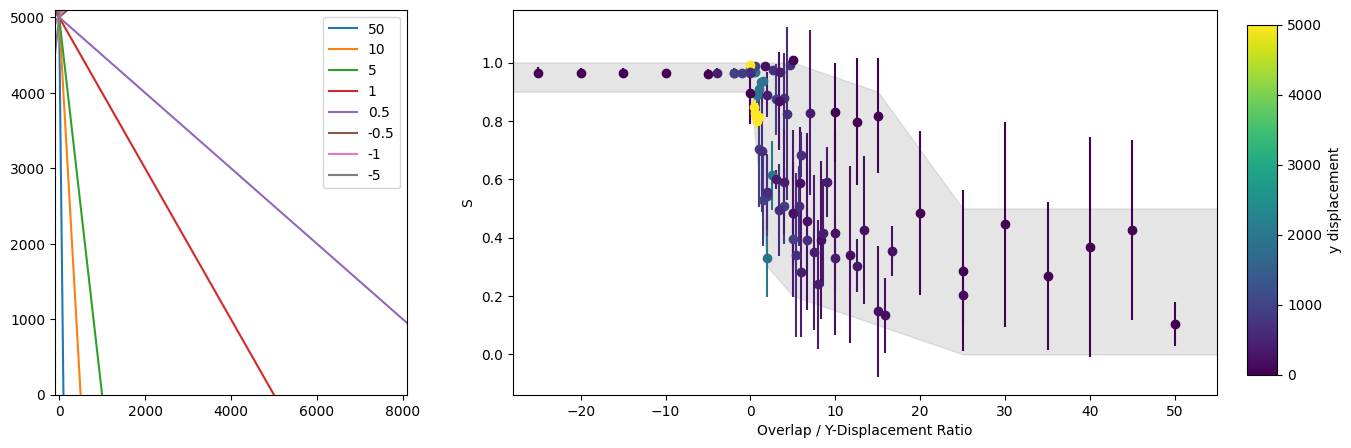

In [25]:
import matplotlib.gridspec as gridspec

# Create a figure
fig = plt.figure(figsize=(15,5))  # Adjust the figure size as needed

# Create a gridspec with 1 row and 3 columns, the first subplot takes 1 column, the second takes 2 columns
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Create the first subplot, which occupies the first column
axS = fig.add_subplot(gs[0])

# Create the second subplot, which occupies the second and third columns (twice as wide as the first)
ax0 = fig.add_subplot(gs[1:])


grouped = df_seq.groupby('model_name')

mean_s = grouped['synchronicity'].mean()
std_s = grouped['synchronicity'].std()

sync_stats = pd.DataFrame({"mean":mean_s, "std": std_s}).reset_index()

syncs = sync_stats[:].copy()
syncs['location'] = [[] for _ in range(len(syncs))]
syncs['location'] = syncs.model_name.apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                        ])
mask = syncs['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
syncs = syncs[mask]

from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

syncs['xyratio'] = (5000 - np.array(syncs['location'].apply(lambda loc: loc[0]))) / (np.array(syncs['location'].apply(lambda loc: loc[1])))

norm = mcolors.Normalize(vmin=min(syncs['location'].apply(lambda loc: loc[1])), 
                         vmax=max(syncs['location'].apply(lambda loc: loc[1])))


# Apply colormap
colors = cm.viridis(norm(syncs['location'].apply(lambda loc: loc[1])))

# Plot each point individually with its color
for i in range(len(syncs)):
    ax0.errorbar(syncs['xyratio'].iloc[i], syncs['mean'].iloc[i], yerr=syncs['std'].iloc[i], 
                 linestyle='None', marker='o', color=colors[i])
ax0.set_xlabel("Overlap / Y-Displacement Ratio")
ax0.set_ylabel("S")

ax0.fill_between([-30,0,2,5,15,25,55],[1,1,1,1,0.9,0.5,0.5],[0.9,0.9,0.3,0.2,0.1,0.,0.],color='grey',alpha=0.2,zorder=-0)
ax0.set_xlim(-28,55)

norm = mcolors.Normalize(vmin=0, vmax=5000)
cmap = plt.get_cmap('viridis')

from mpl_toolkits.axes_grid1 import make_axes_locatable

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('y displacement')

axS.set_xlim(-100,8100)
axS.set_ylim(0,5100)

space = np.linspace(0,8000,100)

# ratio = (5000 - x) / y

axS.plot((5000-space)/50, space, label='50')
axS.plot((5000-space)/10, space, label='10')
axS.plot((5000-space)/5, space, label='5')
axS.plot((5000-space)/1, space, label='1')
axS.plot((5000-space)/0.5, space, label='0.5')
axS.plot((5000-space)/-0.5, space, label='-0.5')
axS.plot((5000-space)/-1, space, label='-1')
axS.plot((5000-space)/-5, space, label='-5')
axS.legend()

# fig.tight_layout()

plt.show()

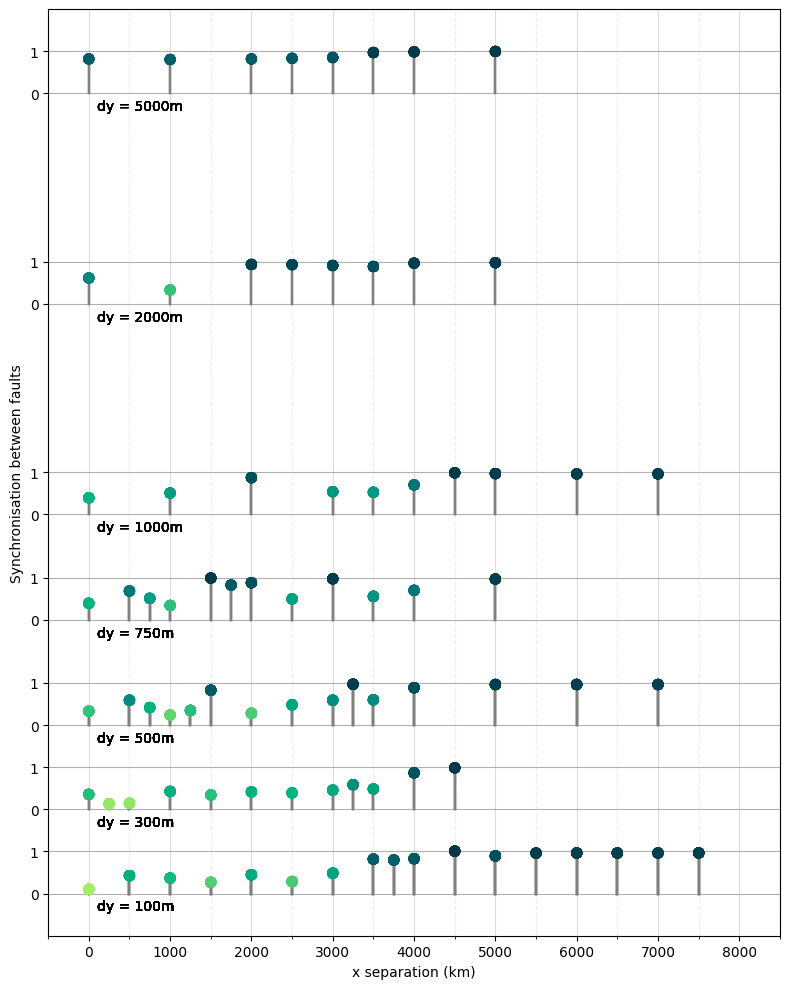

In [26]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

dy_values_ =syncs.copy()
dy_values = dy_values_.query("model_name != 'mod_def'").copy()
def_values = dy_values_.query("model_name == 'mod_def'").copy()
# print(dy_values)
dy_values['location'] = [[] for _ in range(len(dy_values))]
dy_values['location'] = dy_values['model_name'].apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

aries_cmap_rev = aries_cmap.reversed()

ydff = [100, 300, 500, 750, 1000, 2000, 5000] # OVERRIDE to block out the one event rows
ydff_placement = [100, 300, 500, 750, 1000, 1500, 2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10),dpi=100)


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
ydff_p_back = ydff_placement[::-1]
# Apply the function to the 'location' column
for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]  
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['location'].apply(lambda loc: loc[1] == dy_value[1])].dropna()
        
        ax.scatter(np.array(filtered_df['location'].apply(lambda loc: loc[0])),
                np.array(filtered_df['mean'])*100 + ydff_p_back[j],c= np.array(filtered_df['mean']),
                   cmap=aries_cmap_rev, vmin=0, vmax=1, s=50, zorder=1.1)

        for i, row in filtered_df.iterrows():
            ax.plot([row['location'][0],row['location'][0]],
            [row['mean']*100 + ydff_p_back[j],ydff_p_back[j]],c='grey', zorder=1)
            
        from matplotlib.ticker import ScalarFormatter
        for axis in [ax.xaxis]:
            axis.set_major_formatter(ScalarFormatter())
            
        # Grid lines
        ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
        ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
        ax.grid(axis='y')
        ax.set_axisbelow(True)    
    
        # ax.set_ylim(0,100)
        
        # Label modifications
        # ax.set_xticklabels(new_labels)
        ax.annotate(f'dy = {ydff_back[j]}m', xy=(100,ydff_p_back[j]-40))
        
    # Median
    ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
    ax.set_xticks(ticks)
    ax.set_xlim(-500,8500)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('x separation (km)')
    ax.set_ylabel('Synchronisation between faults')
    
    
    
    ax.set_yticks(np.array([[x,x+100] for x in ydff_placement]).flatten(),[0,1]*len(ydff_placement))
    ax.set_ylim(0,ydff_placement[-1]+200) 
    ax.xaxis.set_minor_locator(plt.MultipleLocator(500))  # Adjust the interval as needed
    
    # Draw gridlines for minor ticks only with linestyle '--'
    ax.grid(True, which='major', linestyle='-')  # Disable major gridlines
    ax.grid(True, which='minor', linestyle='--', linewidth=0.9)
    plt.tight_layout()
    

# 5. Periodicity

## 5.1. Calculate CV

In [27]:
display(df_seq)

# function to calculate CV
def calc_cv(x):
    mean_val = x.mean()
    std_dev = x.std()
    if std_dev != 0:
        return std_dev / mean_val
    else:
        return 0  # Handle the case where std_dev is zero

df_seq1 = df_seq[df_seq["fault_label"]==1]
df_seq2 = df_seq[df_seq["fault_label"]==2]


# Group the DataFrame by the "dy" column
grouped1 = df_seq1.groupby("model_name")
grouped2 = df_seq2.groupby("model_name")
grouped = df_seq.groupby("model_name")

# Calculate CV for each "dy" group
cv_values1 = grouped1["t_interevent_intrafault"].apply(calc_cv)
cv_values2 = grouped2["t_interevent_intrafault"].apply(calc_cv)
cv_values = grouped["t_interevent_intrafault"].apply(calc_cv)
if 'mod_def' in models_dict:
    cv_valueF1 = calc_cv(models_dict["mod_def"]["ev"][1]["t_interevent_intrafault"]) #CV F1
elif 'mod_cone' in models_dict:
    cv_valueF2 = calc_cv(models_dict["mod_cone"]["ev"][1]["t_interevent_intrafault"]) #CV F2


### save all data in a DataFrame

# Create an empty DataFrame with columns "cv,"
df_periodicity1 = pd.DataFrame(columns=["cv"])
# Assign values from the Series to the corresponding columns
df_periodicity1["cv"] = cv_values1

df_periodicity1.loc[2000, "cv"] = cv_valueF1 # add manually Value of F1 in position dy=2000
df_periodicity1.loc[3000, "cv"] = np.nan # add manually Value of F1 in position dy=3000

# Create an empty DataFrame with columns "cv,"
df_periodicity2 = pd.DataFrame(columns=["cv"])
# Assign values from the Series to the corresponding columns
df_periodicity2["cv"] = cv_values2

df_periodicity2.loc[3000, "cv"] = cv_valueF1 # add manually Value of F2 in position dy=3000
df_periodicity2.loc[2000, "cv"] = np.nan # add manually Value of F2 in position dy=2000


# Create an empty DataFrame with columns "cv,"
df_periodicity = pd.DataFrame(columns=["cv"])
# Assign values from the Series to the corresponding columns
df_periodicity["cv"] = cv_values

df_periodicity.loc[2000, "cv"] = np.nan # add manually Value of F1 in position dy=2000
df_periodicity.loc[3000, "cv"] = np.nan # add manually Value of F1 in position dy=3000

df_periodicity.to_csv("cv_val.txt", sep=" ", index=True)

min_t         max_t  cum_slip  cum_potency    peak_v  \
n_event                                                                
1        3.946989e+09  3.946989e+09  0.059223    1539309.0  1.747498   
2        5.409775e+09  5.409775e+09  0.064052    1664834.0  1.506440   
1        6.468212e+09  6.468212e+09  0.058264    1514399.0  1.963423   
3        7.829378e+09  7.829378e+09  0.059534    1547400.0  1.730296   
2        8.812346e+09  8.812346e+09  0.056525    1469190.0  1.838097   
...               ...           ...       ...          ...       ...   
20       5.533974e+10  5.533974e+10  0.069075    1795380.0  1.762540   
20       5.807386e+10  5.807386e+10  0.066270    1722490.0  1.689047   
21       5.808537e+10  5.808537e+10  0.067957    1766340.0  1.752127   
21       6.082187e+10  6.082187e+10  0.066251    1722000.0  1.671546   
22       6.083273e+10  6.083273e+10  0.069123    1796640.0  1.761618   

         dt_event       t_event  t_interevent_intrafault        Mw  \
n_event                                                              
1        7.606200  3.946989e+09                      NaN  5.049631   
2        6.174000  5.409775e+09             1.462786e+09  5.072328   
1        6.585900  6.468212e+09                      NaN  5.044908   
3        6.614300  7.829378e+09             2.419604e+09  5.051149   
2        9.305201  8.812346e+09             2.344134e+09  5.036133   
...           ...           ...                      ...       ...   
20       6.112999  5.533974e+10             2.747359e+09  5.094185   
20       5.618004  5.807386e+10             2.744987e+09  5.082185   
21       5.984001  5.808537e+10             2.745634e+09  5.089464   
21       5.652000  6.082187e+10             2.748006e+09  5.082103   
22       6.112999  6.083273e+10             2.747359e+09  5.094388   

         fault_label  dx   dy    dz     time_diff  t_interevent_interfault  \
n_event                                                                      
1                  1   0  100     0           NaN                      NaN   
2                  1   0  100     0  1.462786e+09                      NaN   
1                  2   0  100     0  1.058438e+09             1.058438e+09   
3                  1   0  100     0  1.361166e+09             1.361166e+09   
2                  2   0  100     0  9.829676e+08             9.829676e+08   
...              ...  ..  ...   ...           ...                      ...   
20                 1   0    0  3500  1.086383e+07             1.086383e+07   
20                 2   0    0  3500  2.734123e+09             2.734123e+09   
21                 1   0    0  3500  1.151147e+07             1.151147e+07   
21                 2   0    0  3500  2.736495e+09             2.736495e+09   
22                 1   0    0  3500  1.086383e+07             1.086383e+07   

         synchronicity       model_name  
n_event                                  
1                  NaN   mod_0x_100y_0z  
2                  NaN   mod_0x_100y_0z  
1             0.216529   mod_0x_100y_0z  
3             0.007554   mod_0x_100y_0z  
2             0.272394   mod_0x_100y_0z  
...                ...              ...  
20            0.991958  mod_0x_0y_3500z  
20            1.023836  mod_0x_0y_3500z  
21            0.991479  mod_0x_0y_3500z  
21            1.025592  mod_0x_0y_3500z  
22            0.991958  mod_0x_0y_3500z  

[4687 rows x 17 columns]

## 5.2. Plot 'map' of cv values over x-y space

In [28]:
df_p1 = df_periodicity1[:-2].copy()
df_p1['location'] = [[] for _ in range(len(df_p1))]
df_p1['location'] = df_p1.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = df_p1['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)

# Apply the mask to filter the DataFrame
df_p1 = df_p1[mask]

df_p2 = df_periodicity2[:-2].copy()
df_p2['location'] = [[] for _ in range(len(df_p2))]
df_p2['location'] = df_p2.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = df_p2['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)

# Apply the mask to filter the DataFrame
df_p2 = df_p2[mask]

df_p = df_periodicity[:-2].copy()
df_p['location'] = [[] for _ in range(len(df_p))]
df_p['location'] = df_p.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = df_p['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
# Apply the mask to filter the DataFrame
df_p = df_p[mask]

df_p['cv'] = df_p['cv'].fillna(0)
df_p1['cv'] = df_p1['cv'].fillna(0)
df_p2['cv'] = df_p2['cv'].fillna(0)


cvmax = pd.concat([df_p2, df_p1, df_p], ignore_index=True)['cv'].max()

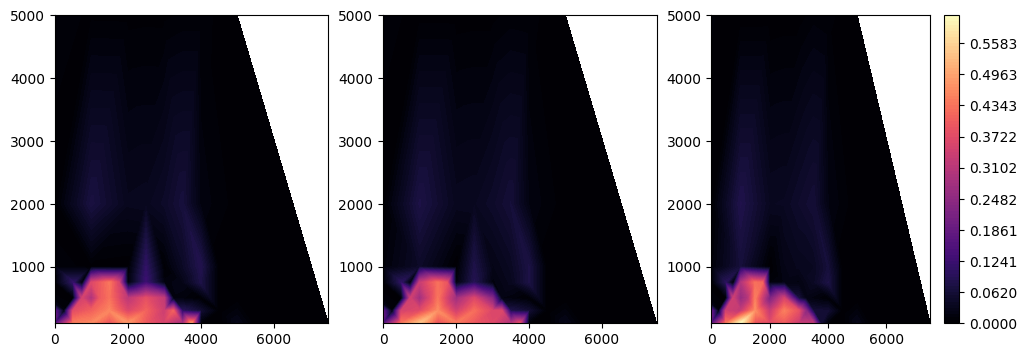

In [29]:
%matplotlib inline

fig, ax = plt.subplots(ncols = 3, figsize=(12,4))

# Create the plot
ax[0].tricontourf(np.array(df_p1['location'].apply(lambda loc: loc[0])), np.array(df_p1['location'].apply(lambda loc: loc[1])),
               np.array(df_p1['cv']),  levels=np.linspace(0, cvmax, 100), cmap='magma')
ax[1].tricontourf(np.array(df_p['location'].apply(lambda loc: loc[0])),  np.array(df_p['location'].apply(lambda loc: loc[1])),
               np.array(df_p['cv']),   levels=np.linspace(0, cvmax, 100), cmap='magma')
axs = ax[2].tricontourf(np.array(df_p2['location'].apply(lambda loc: loc[0])),  np.array(df_p2['location'].apply(lambda loc: loc[1])),
               np.array(df_p2['cv']),   levels=np.linspace(0, cvmax, 100), cmap='magma')

plt.colorbar(axs, ax=ax[2])

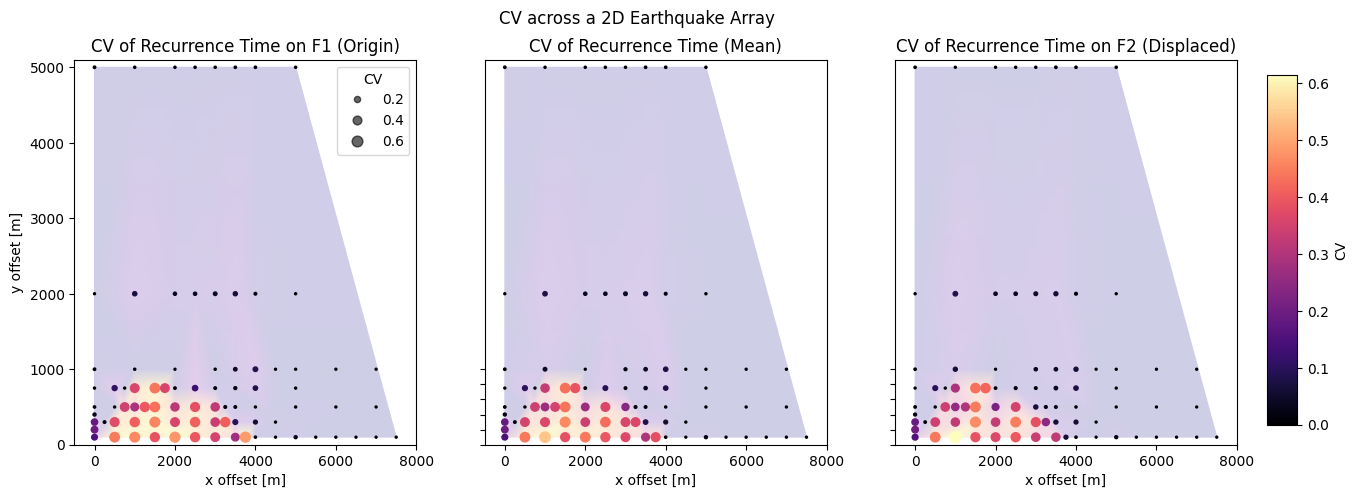

In [30]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)


from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax0c = ax0.tripcolor(np.array(df_p1['location'].apply(lambda loc: loc[0])),
               np.array(df_p1['location'].apply(lambda loc: loc[1])),
               np.array(df_p1['cv']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none')
ax1c = ax1.tripcolor(np.array(df_p['location'].apply(lambda loc: loc[0])),
               np.array(df_p['location'].apply(lambda loc: loc[1])),
               np.array(df_p['cv']), cmap=cmap, antialiased=True, shading='gouraud' , edgecolors='none')
ax2c = ax2.tripcolor(np.array(df_p2['location'].apply(lambda loc: loc[0])),
               np.array(df_p2['location'].apply(lambda loc: loc[1])),
               np.array(df_p2['cv']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none')

ax0.scatter(np.array(df_p1['location'].apply(lambda loc: loc[0])),
           np.array(df_p1['location'].apply(lambda loc: loc[1])),
           s=df_p1['cv']*100 + 2,c=df_p1['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")

ax1.scatter(np.array(df_p['location'].apply(lambda loc: loc[0])),
           np.array(df_p['location'].apply(lambda loc: loc[1])),
           s=df_p['cv']*100 + 2,c=df_p['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax1.set_xlabel("x offset [m]")

sc = ax2.scatter(np.array(df_p2['location'].apply(lambda loc: loc[0])),
           np.array(df_p2['location'].apply(lambda loc: loc[1])),
           s=df_p2['cv']*100 + 2,c=df_p2['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax2.set_xlabel("x offset [m]")

ax0.set_title("CV of Recurrence Time on F1 (Origin)")
ax1.set_title("CV of Recurrence Time (Mean)")
ax2.set_title("CV of Recurrence Time on F2 (Displaced)")

ax0.set_ylim([0,5100])
ax1.set_ylim([0,5100])
ax2.set_ylim([0,5100])

ax0.set_xlim([-500,8000])
ax1.set_xlim([-500,8000])
ax2.set_xlim([-500,8000])

ax1.set_yticks([0,200,400,600,800,1000],[])
ax2.set_yticks([0,200,400,600,800,1000],[])

from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mcolors.Normalize(vmin=0, vmax=cvmax)
cmap = plt.get_cmap('magma')

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('CV')

plt.suptitle("CV across a 2D Earthquake Array")

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=4)
labels = [int(label.split('{')[1].split('}')[0]) for label in labels]  # Extract numeric part
labels = [label/100 for label in labels]  # Adjust labels
handles = [handle for handle in handles]
legend = ax0.legend(handles, labels, loc="upper right", title="CV")

plt.show()

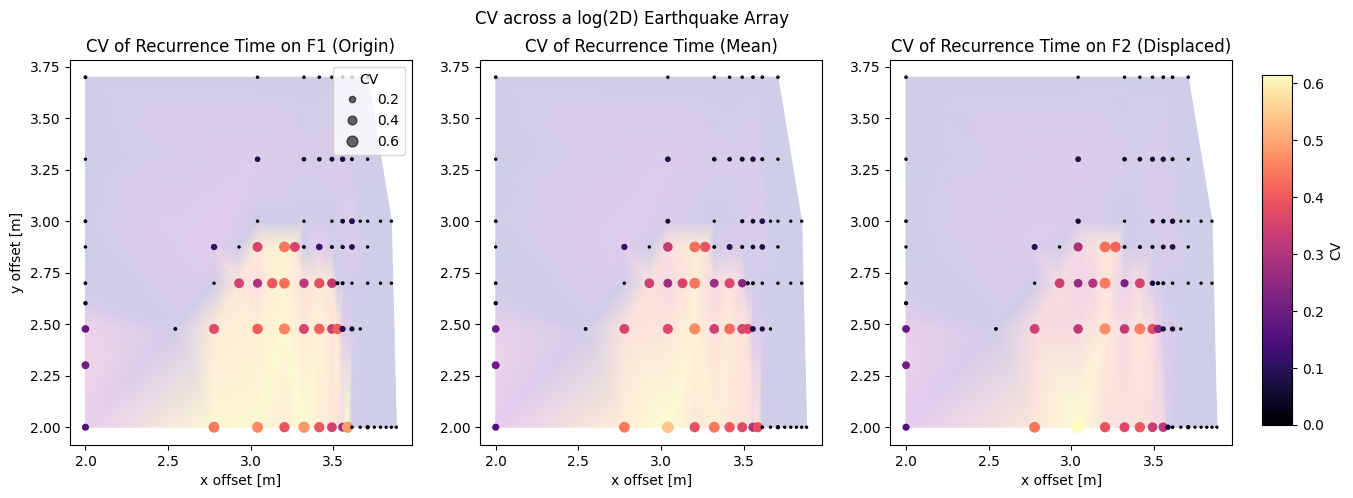

In [31]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)


from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax0c = ax0.tripcolor(np.log10(np.array(df_p1['location'].apply(lambda loc: loc[0]))+100),
               np.log10(np.array(df_p1['location'].apply(lambda loc: loc[1]))),
               np.array(df_p1['cv']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none')
ax1c = ax1.tripcolor(np.log10(np.array(df_p1['location'].apply(lambda loc: loc[0]))+100),
               np.log10(np.array(df_p1['location'].apply(lambda loc: loc[1]))),
               np.array(df_p['cv']), cmap=cmap, antialiased=True, shading='gouraud' , edgecolors='none')
ax2c = ax2.tripcolor(np.log10(np.array(df_p1['location'].apply(lambda loc: loc[0]))+100),
               np.log10(np.array(df_p1['location'].apply(lambda loc: loc[1]))),
               np.array(df_p2['cv']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none')

ax0.scatter(np.log10(np.array(df_p1['location'].apply(lambda loc: loc[0]))+100),
               np.log10(np.array(df_p1['location'].apply(lambda loc: loc[1]))),
           s=df_p1['cv']*100 + 2,c=df_p1['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")

ax1.scatter(np.log10(np.array(df_p1['location'].apply(lambda loc: loc[0]))+100),
               np.log10(np.array(df_p1['location'].apply(lambda loc: loc[1]))),
           s=df_p['cv']*100 + 2,c=df_p['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax1.set_xlabel("x offset [m]")

sc = ax2.scatter(np.log10(np.array(df_p1['location'].apply(lambda loc: loc[0]))+100),
               np.log10(np.array(df_p1['location'].apply(lambda loc: loc[1]))),
           s=df_p2['cv']*100 + 2,c=df_p2['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax2.set_xlabel("x offset [m]")

ax0.set_title("CV of Recurrence Time on F1 (Origin)")
ax1.set_title("CV of Recurrence Time (Mean)")
ax2.set_title("CV of Recurrence Time on F2 (Displaced)")

# ax0.set_ylim([0,5100])
#ax1.set_ylim([0,5100])
# ax2.set_ylim([0,5100])

# ax0.set_xlim([-500,8000])
#ax1.set_xlim([-500,8000])
# ax2.set_xlim([-500,8000])

# ax1.set_yticks([0,200,400,600,800,1000],[])
# ax2.set_yticks([0,200,400,600,800,1000],[])

from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mcolors.Normalize(vmin=0, vmax=cvmax)
cmap = plt.get_cmap('magma')

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('CV')

plt.suptitle("CV across a log(2D) Earthquake Array")

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=4)
labels = [int(label.split('{')[1].split('}')[0]) for label in labels]  # Extract numeric part
labels = [label/100 for label in labels]  # Adjust labels
handles = [handle for handle in handles]
legend = ax0.legend(handles, labels, loc="upper right", title="CV")


# ax0.set_yscale('log')
# ax0.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xscale('log')
# ax2.set_yscale('log')
# ax2.set_xscale('log')

plt.show()

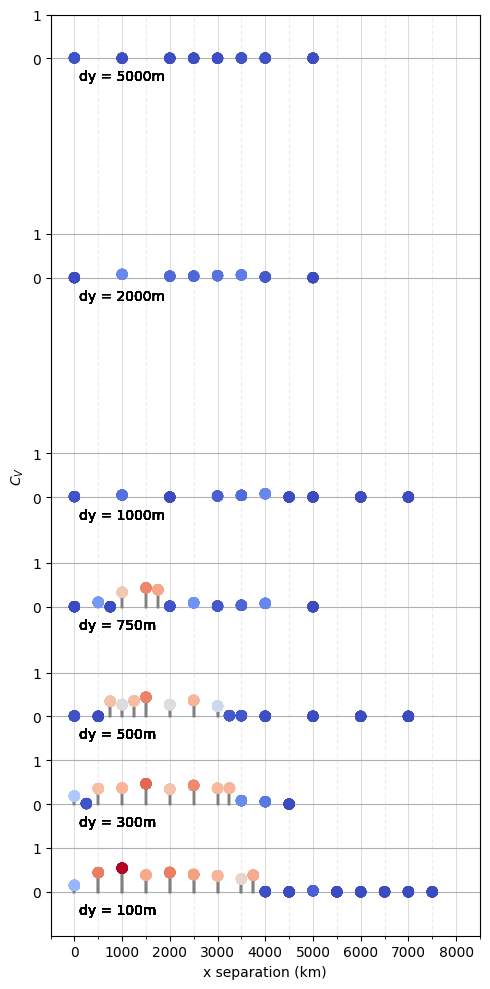

In [32]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

dy_values=df_p.copy()
# print(dy_values)

mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

ydff = [100, 300, 500, 750, 1000, 2000, 5000] # OVERRIDE to block out the one event rows
ydff_placement = [100, 300, 500, 750, 1000, 1500, 2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,10))


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
ydff_p_back = ydff_placement[::-1]
# Apply the function to the 'location' column

cvmax_m = df_p['cv'].max()

for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]  
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['location'].apply(lambda loc: loc[1] == dy_value[1])].dropna()
        
        ax.scatter(np.array(filtered_df['location'].apply(lambda loc: loc[0])),
                np.array(filtered_df['cv'])*100 + ydff_p_back[j],c=filtered_df['cv'], cmap='coolwarm', vmin=0, vmax=cvmax_m, s=50, zorder=1.1)

        for i, row in filtered_df.iterrows():
            ax.plot([row['location'][0],row['location'][0]],
            [row['cv']*100 + ydff_p_back[j],ydff_p_back[j]],c='grey', zorder=1)
            
        from matplotlib.ticker import ScalarFormatter
        for axis in [ax.xaxis]:
            axis.set_major_formatter(ScalarFormatter())
            
        # Grid lines
        ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
        ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
        ax.grid(axis='y')
        ax.set_axisbelow(True)    
    
        # ax.set_ylim(0,100)
        
        # Label modifications
        # ax.set_xticklabels(new_labels)
        ax.annotate(f'dy = {ydff_back[j]}m', xy=(100,ydff_p_back[j]-50))
        
    # Median
    ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
    ax.set_xticks(ticks)
    ax.set_xlim(-500,8500)
    ax.set_xticklabels(ticks)
    ax.set_xlabel('x separation (km)')
    ax.set_ylabel(f'$C_V$')
    
    ax.set_ylim(0,ydff_placement[-1]) 
    
    ax.set_yticks(np.array([[x,x+100] for x in ydff_placement]).flatten(),[0,1]*len(ydff_placement))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(500))  # Adjust the interval as needed
    
    # Draw gridlines for minor ticks only with linestyle '--'
    ax.grid(True, which='major', linestyle='-')  # Disable major gridlines
    ax.grid(True, which='minor', linestyle='--', linewidth=0.9)
    plt.tight_layout()


# CV TREES

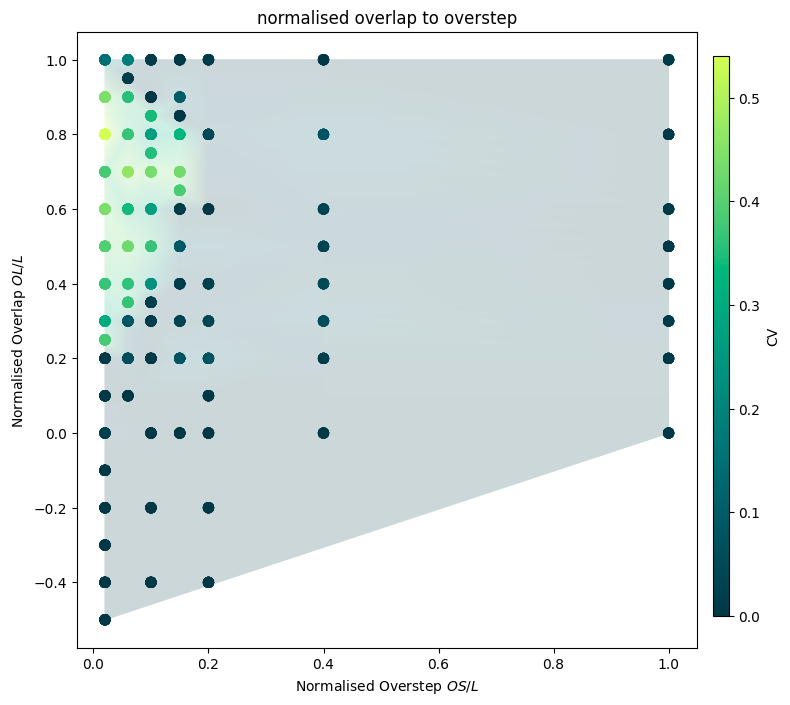

In [33]:
fig, axs=plt.subplots(ncols=1, figsize=(8,8))

ax1 = axs

for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]  
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['location'].apply(lambda loc: loc[1] == dy_value[1])].dropna()
        
        ax.scatter(np.array(filtered_df['location'].apply(lambda loc: loc[1])),
                   5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0])),
                   c=filtered_df['cv'], cmap=aries_cmap, vmin=0, vmax=cvmax_m, s=50, zorder=1.1, marker = 'o')
        # ax1.scatter(dy / 5000,(5000 - dx)/5000, marker="o", color=f'C0')
        ax1.scatter(np.array(filtered_df['location'].apply(lambda loc: loc[1])) / 5000,
                    (5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0]))) / 5000,
                    c=filtered_df['cv'], cmap=aries_cmap, vmin=0, vmax=cvmax_m, s=50, zorder=1.1, marker = 'o')


ax.scatter(dy,5000 - dx, marker="o", color=f'C0', label='2 Fault Models')

space=np.linspace(0.,300000.,100)

ax.fill_between(space, 10 * space, 1 * space, color='grey', alpha=0.1, zorder=0.4)
ax.plot(space, 3.634 * space**0.97, color='grey', ls='--',zorder=0.5, label='Scaling Relation from \nLong and Imber, 2011')

  
cls = plt.get_cmap('coolwarm')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Overstep [m]")
ax.set_ylabel("Overlap [m]")

ax1.set_xlabel(f"Normalised Overstep $OS/L$")
ax1.set_ylabel(f"Normalised Overlap $OL/L$")

x = np.array(dyv['location'].apply(lambda loc: loc[1])) / 5000
y = np.array(5000 - dyv['location'].apply(lambda loc: loc[0])) / 5000
cv = np.array(dyv['cv'])

alpha=0.2
cls = plt.get_cmap(aries_cmap)(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax1c = ax1.tripcolor(x, y, cv, cmap=cmap, vmin=0, vmax=cvmax_m, antialiased=True, shading='gouraud', edgecolors='none', zorder=-0.5)


ax.set_ylim(100,100000)
ax.set_xlim(50,30000)

ax.grid(visible=True, which='major', axis='both', zorder=0.1)

ax.legend()

# ax1.set_ylim(-0.05,1.05)
# ax1.set_xlim(-0.05,1.05)

ax.set_title("overlap to overstep (separation)")
ax1.set_title("normalised overlap to overstep")

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = mcolors.Normalize(vmin=0, vmax=cvmax_m)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=aries_cmap), cax=cax, orientation='vertical')
cbar.set_label('CV')

# fig.tight_layout()
plt.show()

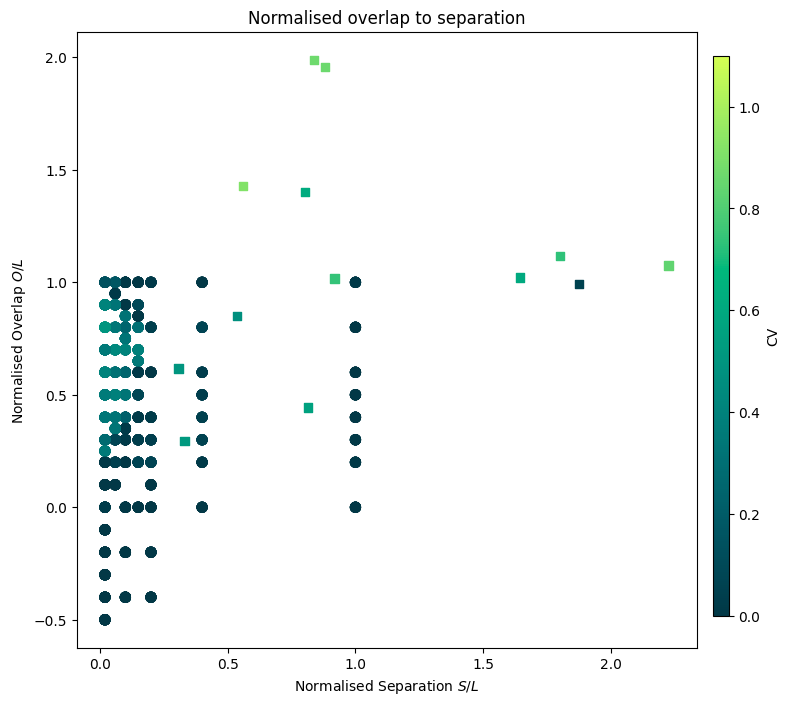

In [34]:
fig, axs=plt.subplots(ncols=1, figsize=(8,8))

ax1 = axs

for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]  
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['location'].apply(lambda loc: loc[1] == dy_value[1])].dropna()
        
        ax.scatter(np.array(filtered_df['location'].apply(lambda loc: loc[1])),
                   5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0])),
                   c=filtered_df['cv'], cmap=aries_cmap, vmin=0, vmax=1.2, s=50, zorder=1.1, marker = 'o', label='Two-Fault Model')
        # ax1.scatter(dy / 5000,(5000 - dx)/5000, marker="o", color=f'C0')
        ax1.scatter(np.array(filtered_df['location'].apply(lambda loc: loc[1])) / 5000,
                    (5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0]))) / 5000,
                    c=filtered_df['cv'], cmap=aries_cmap, vmin=0, vmax=1.2, s=50, zorder=1.1, marker = 'o')


ax.scatter(dy,5000 - dx, marker="o", color=f'C0', label='2 Fault Models')

space=np.linspace(0.,300000.,100)

ax.fill_between(space, 10 * space, 1 * space, color='grey', alpha=0.1, zorder=0.4)
ax.plot(space, 3.634 * space**0.97, color='grey', ls='--',zorder=0.5, label='Scaling Relation from \nLong and Imber, 2011')

s_app_o = [0.444088533,
0.993635309,
1.022012462,
0.616694663,
0.850116236,
0.294460086]

s_app_s = [0.81435569,
1.875311586,
1.644344534,
0.307402604,
0.536573646,
0.330773863]

s_app_cv = [0.60584481,
0.063944385,
0.655640913,
0.542187559,
0.507790461,
0.564821182]

n_app_o = np.array([1.402042004,
1.016467545,
1.1178469,
1.074044123,
1.989522215,
1.426757444,
1.958439096])

n_app_s = np.array([0.802461992,
0.918493194,
1.801429301,
2.225014365,
0.838023993,
0.55955335,
0.881282723])

n_app_cv = np.array([0.670184452,
0.810290793,
0.799380529,
0.912415622,
0.946072512,
0.994215029,
0.940834967])
    

# qgisdata = litdata[litdata['Data Sources'] == 'QGIS']
# ax.scatter(qgisdata['Separation (m)'], qgisdata['Overlap (m)'], c=qgisdata['CV'], cmap=aries_cmap, vmin=0, vmax=cvmax_m, zorder=0.9, marker='v', label='Fault Pairs from Apennines')
# ax1.scatter(qgisdata['Separation (m)'] / (qgisdata['Total Length']/2), qgisdata['Overlap (m)'] / (qgisdata['Total Length']/2), c=qgisdata['CV'], marker='v',
#             cmap=aries_cmap, vmin=0, vmax=cvmax_m, zorder=0.9)

# zerocv = qgisdata[qgisdata['CV'] == 0]
# ax.scatter(zerocv['Separation (m)'], zerocv['Overlap (m)'], color='k', marker='s')
# ax1.scatter(zerocv['Separation (m)'] / (zerocv['Total Length']/2), zerocv['Overlap (m)'] / (zerocv['Total Length']/2), color='k', marker='s',
#             )


ax1.scatter(n_app_s, n_app_o, c=n_app_cv, cmap=aries_cmap, vmin=0, vmax=1.2, marker='s', label='Italy Model')
ax1.scatter(s_app_s, s_app_o, c=s_app_cv, cmap=aries_cmap, vmin=0, vmax=1.2, marker='s')

cls = plt.get_cmap('coolwarm')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("Overstep [m]")
ax.set_ylabel("Overlap [m]")

ax1.set_xlabel(f"Normalised Separation $S/L$")
ax1.set_ylabel(f"Normalised Overlap $O/L$")

ax.set_ylim(100,100000)
ax.set_xlim(50,30000)

ax.grid(visible=True, which='major', axis='both', zorder=0.1)

ax.legend()

# ax1.set_ylim(-0.05,1.05)
# ax1.set_xlim(-0.05,1.05)

ax.set_title("overlap to separation")
ax1.set_title("Normalised overlap to separation")

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
norm = mcolors.Normalize(vmin=0, vmax=1.1)
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=aries_cmap), cax=cax, orientation='vertical')
cbar.set_label('CV')

# fig.tight_layout()
plt.show()

672.4370742153966
672.4370742153966


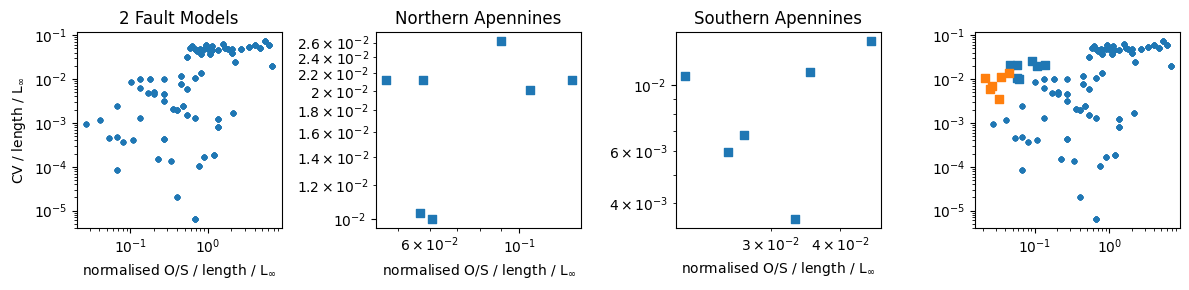

In [35]:
fig, ax = plt.subplots(ncols=4,figsize=(12,3))

for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]  
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['location'].apply(lambda loc: loc[1] == dy_value[1])].dropna()
        
        ax[0].scatter(((5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0]))) / np.array(filtered_df['location'].apply(lambda loc: loc[1]))) 
                   / (5000/(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))), # normalised O/S / length / Linf
                   np.array(filtered_df['cv'])/ (5000/(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))),
                   color='C0',marker = '.')

        ax[3].scatter(((5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0]))) / np.array(filtered_df['location'].apply(lambda loc: loc[1]))) 
                   / (5000/(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))), # normalised O/S / length / Linf
                   np.array(filtered_df['cv'])/ (5000/(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))),
                   color='C0',marker = '.')


ax[1].scatter([0.06077215,
0.056773068,
0.057796767,
0.04660033,
0.106190499,
0.090319958,
0.13499469],
           [0.009980042,0.010319133,0.021193399,0.021174736,0.020060685,0.026195291,0.021260081],marker='s')

ax[2].scatter([0.035306397,
0.033165099,
0.04542411,
0.026874954,
0.025120195,
0.021025498],
              [0.011018364,
0.003542062,
0.014015319,
0.006794774,
0.005948196,
0.01067599],marker='s')

print(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))

ax[3].scatter([0.06077215,
0.056773068,
0.057796767,
0.04660033,
0.106190499,
0.090319958,
0.13499469],
           [0.009980042,0.010319133,0.021193399,0.021174736,0.020060685,0.026195291,0.021260081],marker='s')

ax[3].scatter([0.035306397,
0.033165099,
0.04542411,
0.026874954,
0.025120195,
0.021025498],
              [0.011018364,
0.003542062,
0.014015319,
0.006794774,
0.005948196,
0.01067599],marker='s')

print(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))

#ax[0].set_xlim(0.0,0.0015)
# ax[1].set_xlim(0,5.5e-6)

#ax[0].set_xticks([0,0.0005,0.001,0.0015],[0,0.0005,0.001,0.0015])

ax[0].set_xlabel(r"normalised O/S / length / L$_{\infty}$")
ax[1].set_xlabel(r"normalised O/S / length / L$_{\infty}$")
ax[2].set_xlabel(r"normalised O/S / length / L$_{\infty}$")

ax[0].set_ylabel(r"CV / length / L$_{\infty}$")
#ax[1].set_ylabel(r"CV / length / L$_{\infty}$")
#ax[2].set_ylabel(r"CV / length / L$_{\infty}$")

ax[0].set_title("2 Fault Models")
ax[1].set_title("Northern Apennines")
ax[2].set_title("Southern Apennines")


#ax[0].set_xlim(0,)
#ax[1].set_xlim(0,)
#ax[2].set_xlim(0,)

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[3].set_xscale("log")

ax[0].set_yscale("log")
ax[1].set_yscale("log")
ax[2].set_yscale("log")
ax[3].set_yscale("log")

fig.tight_layout()

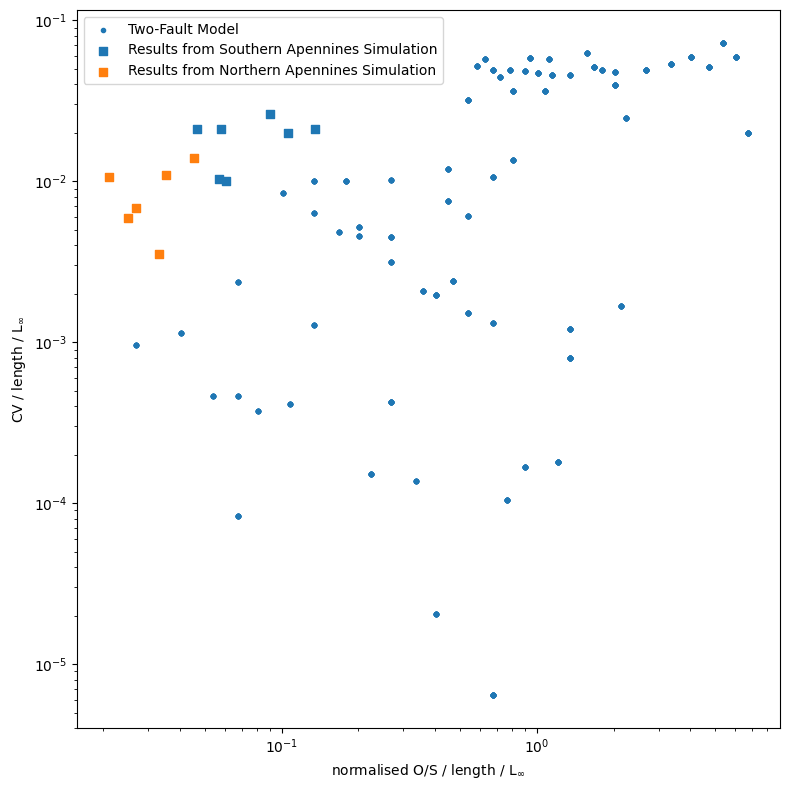

In [36]:
fig, ax = plt.subplots(ncols=1,figsize=(8,8))

for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]  
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['location'].apply(lambda loc: loc[1] == dy_value[1])].dropna()
        
        ax.scatter(((5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0]))) / np.array(filtered_df['location'].apply(lambda loc: loc[1]))) 
                   / (5000/(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))), # normalised O/S / length / Linf
                   np.array(filtered_df['cv'])/ (5000/(32000000000*0.01*0.014/(3.14*50e6*np.sin(np.radians(60))*(0.014-0.007)**2))),
                   color='C0',marker = '.')


ax.scatter(-10000000,-10000000,color='C0',marker = '.', label='Two-Fault Model')

ax.scatter([0.06077215,
0.056773068,
0.057796767,
0.04660033,
0.106190499,
0.090319958,
0.13499469],
           [0.009980042,0.010319133,0.021193399,0.021174736,0.020060685,0.026195291,0.021260081],marker='s', label='Results from Southern Apennines Simulation')

ax.scatter([0.035306397,
0.033165099,
0.04542411,
0.026874954,
0.025120195,
0.021025498],
              [0.011018364,
0.003542062,
0.014015319,
0.006794774,
0.005948196,
0.01067599],marker='s', label='Results from Northern Apennines Simulation')


#ax[0].set_xlim(0.0,0.0015)
# ax[1].set_xlim(0,5.5e-6)

#ax[0].set_xticks([0,0.0005,0.001,0.0015],[0,0.0005,0.001,0.0015])

ax.set_xlabel(r"normalised O/S / length / L$_{\infty}$")

ax.set_ylabel(r"CV / length / L$_{\infty}$")
#ax[1].set_ylabel(r"CV / length / L$_{\infty}$")
#ax[2].set_ylabel(r"CV / length / L$_{\infty}$")

#ax[0].set_xlim(0,)
#ax[1].set_xlim(0,)
#ax[2].set_xlim(0,)

ax.legend()

ax.set_xscale("log")

ax.set_yscale("log")

fig.tight_layout()

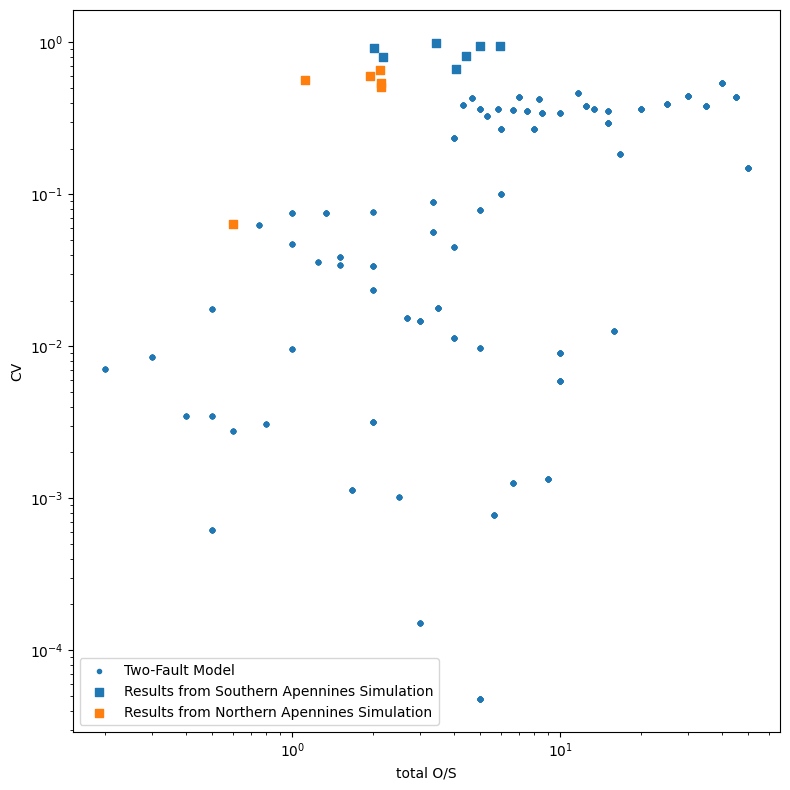

In [37]:
fig, ax = plt.subplots(ncols=1,figsize=(8,8))

for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]  
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['location'].apply(lambda loc: loc[1] == dy_value[1])].dropna()
        
        ax.scatter(((5000 - np.array(filtered_df['location'].apply(lambda loc: loc[0]))) / np.array(filtered_df['location'].apply(lambda loc: loc[1]))), # normalised O/S / length / Linf
                   np.array(filtered_df['cv']),
                   color='C0',marker = '.')


ax.scatter(-10000000,-10000000,color='C0',marker = '.', label='Two-Fault Model')

ax.scatter([4.081,
4.458,
2.18,
2.008,
5.008,
3.428,
5.974],
           [0.670184452,
0.810290793,
0.799380529,
0.912415622,
0.946072512,
0.994215029,
0.940834967],marker='s', label='Results from Southern Apennines Simulation')

ax.scatter([1.941322457,
0.598725264,
2.124953785,
2.144481178,
2.144481178,
1.112369593],
              [0.60584481,
0.063944385,
0.655640913,
0.542187559,
0.507790461,
0.564821182],marker='s', label='Results from Northern Apennines Simulation')


#ax[0].set_xlim(0.0,0.0015)
# ax[1].set_xlim(0,5.5e-6)

#ax[0].set_xticks([0,0.0005,0.001,0.0015],[0,0.0005,0.001,0.0015])

ax.set_xlabel(r"total O/S")

ax.set_ylabel(r"CV")
#ax[1].set_ylabel(r"CV / length / L$_{\infty}$")
#ax[2].set_ylabel(r"CV / length / L$_{\infty}$")

#ax[0].set_xlim(0,)
#ax[1].set_xlim(0,)
#ax[2].set_xlim(0,)

ax.legend()

ax.set_xscale("log")

ax.set_yscale("log")

fig.tight_layout()

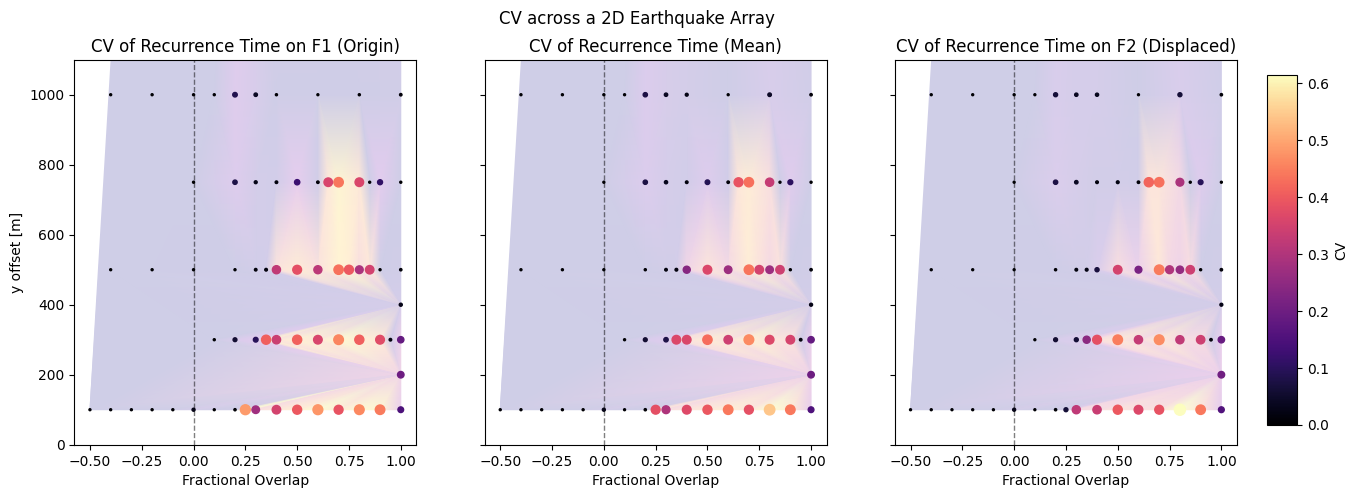

In [38]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)


from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax0c = ax0.tripcolor((5000 - np.array(df_p1['location'].apply(lambda loc: loc[0]))) / 5000,
               np.array(df_p1['location'].apply(lambda loc: loc[1])),
               np.array(df_p1['cv']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none')
ax1c = ax1.tripcolor((5000 - np.array(df_p['location'].apply(lambda loc: loc[0]))) / 5000,
               np.array(df_p['location'].apply(lambda loc: loc[1])),
               np.array(df_p['cv']), cmap=cmap, antialiased=True, shading='gouraud' , edgecolors='none')
ax2c = ax2.tripcolor((5000 - np.array(df_p2['location'].apply(lambda loc: loc[0]))) / 5000,
               np.array(df_p2['location'].apply(lambda loc: loc[1])),
               np.array(df_p2['cv']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none')

ax0.scatter((5000 - np.array(df_p1['location'].apply(lambda loc: loc[0]))) / 5000,
           np.array(df_p1['location'].apply(lambda loc: loc[1])),
           s=df_p1['cv']*100 + 2,c=df_p1['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax0.set_xlabel("Fractional Overlap")
ax0.set_ylabel("y offset [m]")

ax1.scatter((5000 - np.array(df_p['location'].apply(lambda loc: loc[0]))) / 5000,
           np.array(df_p['location'].apply(lambda loc: loc[1])),
           s=df_p['cv']*100 + 2,c=df_p['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax1.set_xlabel("Fractional Overlap")

sc = ax2.scatter((5000 - np.array(df_p2['location'].apply(lambda loc: loc[0]))) / 5000,
           np.array(df_p2['location'].apply(lambda loc: loc[1])),
           s=df_p2['cv']*100 + 2,c=df_p2['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax2.set_xlabel("Fractional Overlap")

ax0.set_title("CV of Recurrence Time on F1 (Origin)")
ax1.set_title("CV of Recurrence Time (Mean)")
ax2.set_title("CV of Recurrence Time on F2 (Displaced)")

ax0.set_ylim([0,1100])
ax1.set_ylim([0,1100])
ax2.set_ylim([0,1100])

# ax0.set_xlim([-500,8000])
# ax1.set_xlim([-500,8000])
# ax2.set_xlim([-500,8000])

ax1.set_yticks([0,200,400,600,800,1000],[])
ax2.set_yticks([0,200,400,600,800,1000],[])

ax0.axvline(0,color='k',ls='--',alpha=0.5,linewidth=1)
ax1.axvline(0,color='k',ls='--',alpha=0.5,linewidth=1)
ax2.axvline(0,color='k',ls='--',alpha=0.5,linewidth=1)

from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mcolors.Normalize(vmin=0, vmax=cvmax)
cmap = plt.get_cmap('magma')

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('CV')

plt.suptitle("CV across a 2D Earthquake Array")

plt.show()

/work/e820/e820/willpizii/QENV/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/work/e820/e820/willpizii/QENV/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/work/e820/e820/willpizii/QENV/lib/python3.9/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


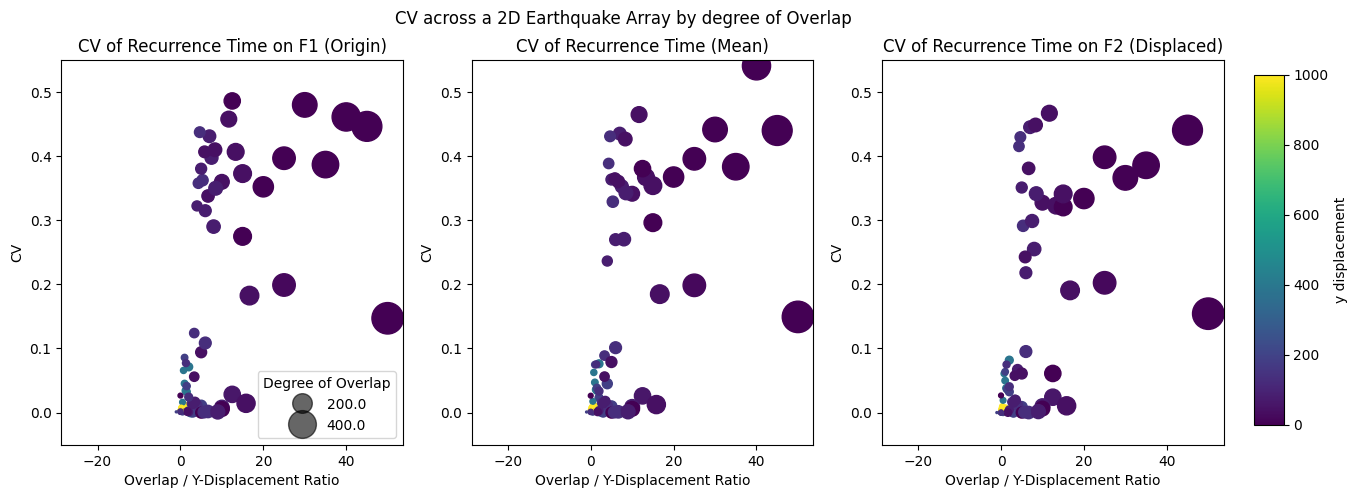

In [39]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)


from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

df_p1['xyratio'] = (5000 - np.array(df_p1['location'].apply(lambda loc: loc[0]))) / np.array(df_p1['location'].apply(lambda loc: loc[1]))

ax0.scatter(df_p1['xyratio'],
           df_p1['cv'], c=np.array(df_p1['location'].apply(lambda loc: loc[1])),s=np.array(df_p1['xyratio'])*10+12)

ax0.set_xlabel("Overlap / Y-Displacement Ratio")
ax0.set_ylabel("CV")

df_p['xyratio'] = (5000 - np.array(df_p['location'].apply(lambda loc: loc[0]))) / np.array(df_p['location'].apply(lambda loc: loc[1]))

ax1.scatter(df_p['xyratio'],
           df_p['cv'], c=np.array(df_p['location'].apply(lambda loc: loc[1])),s=np.array(df_p['xyratio'])*10+12)

ax1.set_xlabel("Overlap / Y-Displacement Ratio")
ax1.set_ylabel("CV")

df_p2['xyratio'] = (5000 - np.array(df_p2['location'].apply(lambda loc: loc[0]))) / np.array(df_p2['location'].apply(lambda loc: loc[1]))

sc = ax2.scatter(df_p2['xyratio'],
           df_p2['cv'], c=np.array(df_p2['location'].apply(lambda loc: loc[1])),s=np.maximum(np.array(df_p2['location'].apply(lambda loc: loc[2])),np.array(df_p2['xyratio'])*10+12))

ax2.set_xlabel("Overlap / Y-Displacement Ratio")
ax2.set_ylabel("CV")



ax0.set_title("CV of Recurrence Time on F1 (Origin)")
ax1.set_title("CV of Recurrence Time (Mean)")
ax2.set_title("CV of Recurrence Time on F2 (Displaced)")

ax0.set_ylim([-0.05,0.55])
ax1.set_ylim([-0.05,0.55])
ax2.set_ylim([-0.05,0.55])


# ax1.set_xlim([-500,8000])
# ax2.set_xlim([-500,8000])

# ax1.set_yticks([0,200,400,600,800,1000],[])
# ax2.set_yticks([0,200,400,600,800,1000],[])

norm = mcolors.Normalize(vmin=0, vmax=1000)
cmap = plt.get_cmap('viridis')

from mpl_toolkits.axes_grid1 import make_axes_locatable

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('y displacement')

plt.suptitle("CV across a 2D Earthquake Array by degree of Overlap")

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=4)
labels = [float(label.split('{')[1].split('}')[0]) for label in labels]  # Extract numeric part
labels = [label for label in labels]  # Adjust labels
legend = ax0.legend(handles, labels, loc="lower right", title="Degree of Overlap")

plt.show()

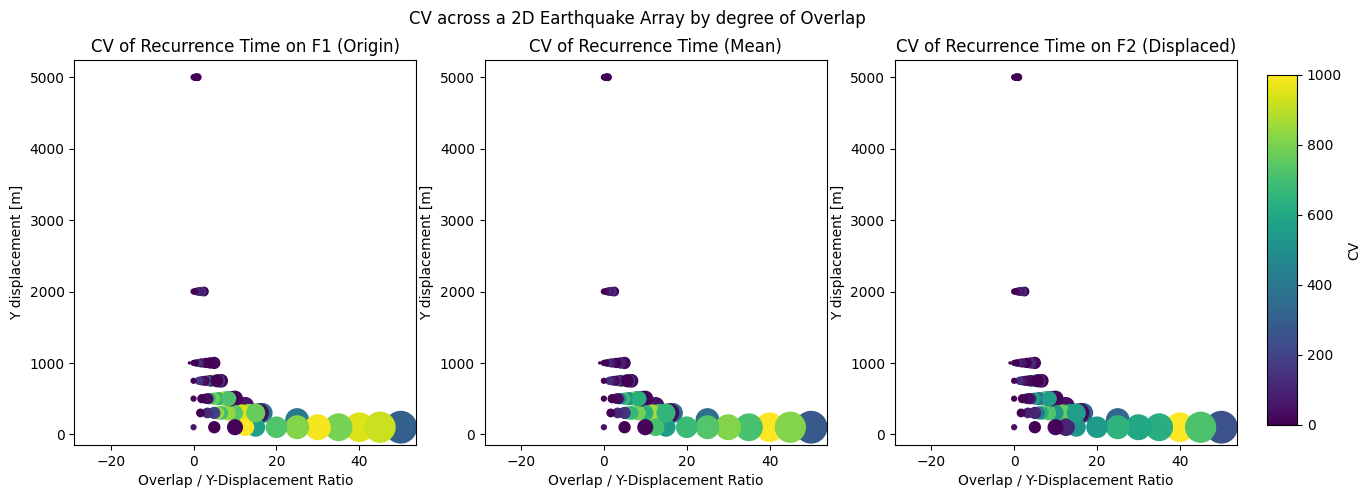

In [40]:
fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133)

from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax0.scatter((df_p1['xyratio']),
           np.array(df_p1['location'].apply(lambda loc: loc[1])), c=df_p1['cv'],s=np.array(df_p['xyratio'])*10+12)

ax0.set_xlabel("Overlap / Y-Displacement Ratio")
ax0.set_ylabel("Y displacement [m]")

ax1.scatter((df_p['xyratio']),
           np.array(df_p['location'].apply(lambda loc: loc[1])), c=df_p['cv'],s=np.array(df_p['xyratio'])*10+12)

ax1.set_xlabel("Overlap / Y-Displacement Ratio")
ax1.set_ylabel("Y displacement [m]")

sc = ax2.scatter((df_p2['xyratio']),
           np.array(df_p2['location'].apply(lambda loc: loc[1])), c=df_p2['cv'],s=np.array(df_p['xyratio'])*10+12)

ax2.set_xlabel("Overlap / Y-Displacement Ratio")
ax2.set_ylabel("Y displacement [m]")



ax0.set_title("CV of Recurrence Time on F1 (Origin)")
ax1.set_title("CV of Recurrence Time (Mean)")
ax2.set_title("CV of Recurrence Time on F2 (Displaced)")

# ax0.set_ylim([-0.05,0.55])
# ax1.set_ylim([-0.05,0.55])
# ax2.set_ylim([-0.05,0.55])


# ax1.set_xlim([-500,8000])
# ax2.set_xlim([-500,8000])

# ax1.set_yticks([0,200,400,600,800,1000],[])
# ax2.set_yticks([0,200,400,600,800,1000],[])

norm = mcolors.Normalize(vmin=0, vmax=1000)
cmap = plt.get_cmap('viridis')

from mpl_toolkits.axes_grid1 import make_axes_locatable

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('CV')

plt.suptitle("CV across a 2D Earthquake Array by degree of Overlap")

possy = np.linspace(100,1000,256)

plt.show()

In [41]:
df_p1 = df_periodicity1[:-2].copy()
df_p1['location'] = [[] for _ in range(len(df_p1))]
df_p1['location'] = df_p1.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = df_p1['location'].apply(lambda loc: loc[1] == 100 if len(loc) == 3 else False)

# Apply the mask to filter the DataFrame
df_p1 = df_p1[mask]

df_p2 = df_periodicity2[:-2].copy()
df_p2['location'] = [[] for _ in range(len(df_p2))]
df_p2['location'] = df_p2.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = df_p2['location'].apply(lambda loc: loc[1] == 100 if len(loc) == 3 else False)

# Apply the mask to filter the DataFrame
df_p2 = df_p2[mask]

df_p = df_periodicity[:-2].copy()
df_p['location'] = [[] for _ in range(len(df_p))]
df_p['location'] = df_p.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = df_p['location'].apply(lambda loc: loc[1] == 100 if len(loc) == 3 else False)
# Apply the mask to filter the DataFrame
df_p = df_p[mask]

cvmax = pd.concat([df_p2, df_p1, df_p], ignore_index=True)['cv'].max()

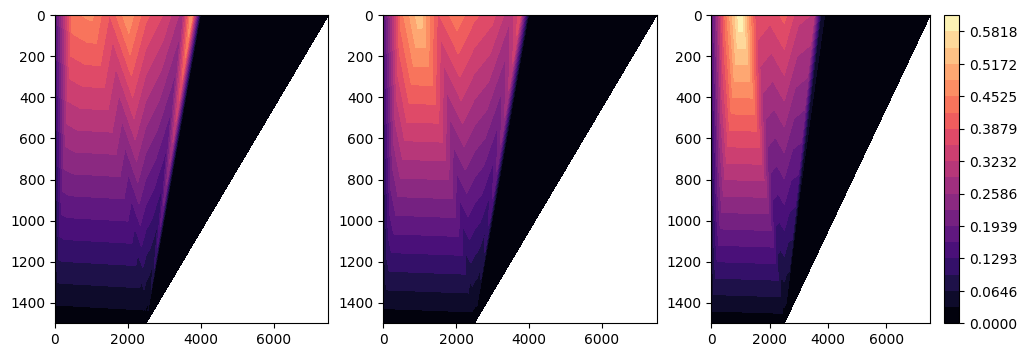

In [42]:
%matplotlib inline

fig, ax = plt.subplots(ncols = 3, figsize=(12,4))

# Create the plot
ax[0].tricontourf(np.array(df_p1['location'].apply(lambda loc: loc[0])), np.array(df_p1['location'].apply(lambda loc: loc[2])),
               np.array(df_p1['cv']),  levels=np.linspace(0, cvmax, 20), cmap='magma')
ax[1].tricontourf(np.array(df_p['location'].apply(lambda loc: loc[0])),  np.array(df_p['location'].apply(lambda loc: loc[2])),
               np.array(df_p['cv']),   levels=np.linspace(0, cvmax, 20), cmap='magma')
axs = ax[2].tricontourf(np.array(df_p2['location'].apply(lambda loc: loc[0])),  np.array(df_p2['location'].apply(lambda loc: loc[2])),
               np.array(df_p2['cv']),   levels=np.linspace(0, cvmax, 20), cmap='magma')

ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[2].invert_yaxis()

plt.colorbar(axs, ax=ax[2])

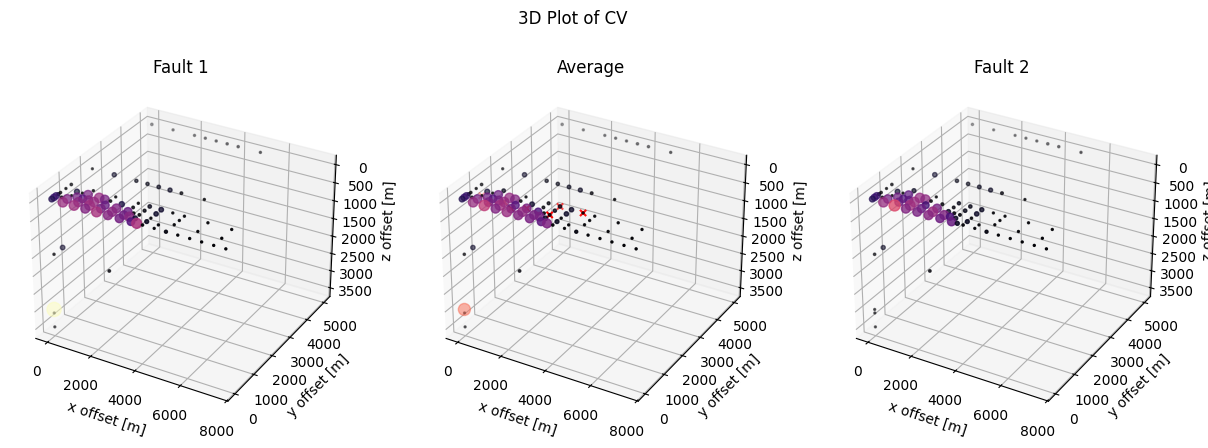

In [43]:
## Plot of the CV of fault recurrence time in a 3D space

df_p1 = df_periodicity1[:-2].copy()
df_p1['location'] = [[] for _ in range(len(df_p1))]
df_p1['location'] = df_p1.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])


df_p2 = df_periodicity2[:-2].copy()
df_p2['location'] = [[] for _ in range(len(df_p2))]
df_p2['location'] = df_p2.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])


df_p = df_periodicity[:-2].copy()
df_p['location'] = [[] for _ in range(len(df_p))]
df_p['location'] = df_p.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

cvmax = pd.concat([df_p2, df_p1, df_p], ignore_index=True)['cv'].max()

fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131, projection='3d')

ax0.scatter(np.array(df_p1['location'].apply(lambda loc: loc[0])),
           np.array(df_p1['location'].apply(lambda loc: loc[1])),
           np.array(df_p1['location'].apply(lambda loc: loc[2])),
           s=df_p1['cv']*100 + 2,c=df_p1['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")
ax0.set_zlabel("z offset [m]")

ax1 = fig.add_subplot(132, projection='3d')

ax1.scatter(np.array(df_p['location'].apply(lambda loc: loc[0])),
           np.array(df_p['location'].apply(lambda loc: loc[1])),
           np.array(df_p['location'].apply(lambda loc: loc[2])),
           s=df_p['cv']*100 + 2,c=df_p['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax1.set_xlabel("x offset [m]")
ax1.set_ylabel("y offset [m]")
ax1.set_zlabel("z offset [m]")

ax2 = fig.add_subplot(133, projection='3d')

ax2.scatter(np.array(df_p2['location'].apply(lambda loc: loc[0])),
           np.array(df_p2['location'].apply(lambda loc: loc[1])),
           np.array(df_p2['location'].apply(lambda loc: loc[2])),
           s=df_p2['cv']*100 + 2,c=df_p2['cv'], cmap='magma', vmin=0, vmax=cvmax)

ax2.set_xlabel("x offset [m]")
ax2.set_ylabel("y offset [m]")
ax2.set_zlabel("z offset [m]")

ax0.invert_zaxis()
ax1.invert_zaxis()
ax2.invert_zaxis()

ax0.set_title("Fault 1")
ax1.set_title("Average")
ax2.set_title("Fault 2")

plt.suptitle("3D Plot of CV")

ax1.scatter([500,1500,2500,3500,3500,4500,1000,2000],[500,500,500,500,1000,1000,300,300],[0,0,0,0,0,0,0,0],marker='x', color='red')

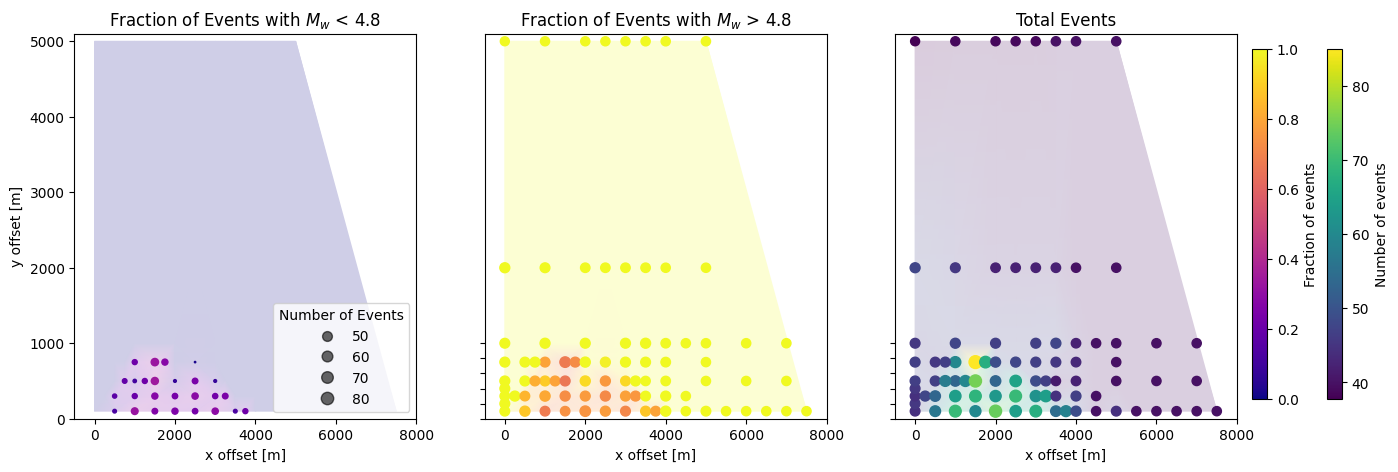

In [44]:
## Attempt to plot the amount of partial vs full ruptures - by using the Mw as a (valid) proxy
threshold = 4.8 # adjustable threshold for what is considered a 'full' rupture magnitude

grouped = df_seq.groupby("model_name")

def count_above_threshold(group, threshold):
    return (group['Mw'] > threshold).sum()
def count_below_threshold(group, threshold):
    return (group['Mw'] < threshold).sum()

above = grouped.apply(lambda x: count_above_threshold(x, threshold))
below = grouped.apply(lambda x: count_below_threshold(x, threshold))

# Apply the function to each group
high_mag = pd.DataFrame(above, columns=["count"])
low_mag = pd.DataFrame(below, columns=["count"])

# Compute sum_mag
sum_mag = pd.DataFrame(index=high_mag.index)
sum_mag['count'] = high_mag['count'] + low_mag['count']

hm = high_mag[:].copy()
hm['location'] = [[] for _ in range(len(hm))]
hm['location'] = df_p1.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = hm['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
hm = hm[mask]

lm = low_mag[:].copy()
lm['location'] = [[] for _ in range(len(lm))]
lm['location'] = lm.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = lm['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
lm = lm[mask]

sm = sum_mag[:].copy()
sm['location'] = [[] for _ in range(len(sm))]
sm['location'] = sm.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = sm['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
sm = sm[mask]

fig = plt.figure(figsize=(15,5))

ax0 = fig.add_subplot(131)

ax0.scatter(np.array(lm['location'].apply(lambda loc: loc[0])),
           np.array(lm['location'].apply(lambda loc: loc[1])),
           s=lm['count'],c=lm['count'] / sm['count'], cmap='plasma', vmin=0, vmax=1)

ax0.set_xlabel("x offset [m]")
ax0.set_ylabel("y offset [m]")

ax1 = fig.add_subplot(132)

ax1.scatter(np.array(hm['location'].apply(lambda loc: loc[0])),
           np.array(hm['location'].apply(lambda loc: loc[1])),
           s=hm['count'],c=hm['count'] / sm['count'], cmap='plasma', vmin=0, vmax=1)

ax1.set_xlabel("x offset [m]")
ax2 = fig.add_subplot(133)

sc = ax2.scatter(np.array(sm['location'].apply(lambda loc: loc[0])),
           np.array(sm['location'].apply(lambda loc: loc[1])),
           s=sm['count'],c=sm['count'], cmap='viridis')

ax2.set_xlabel("x offset [m]")


ax0.set_title(f"Fraction of Events with $M_w$ < {threshold}")
ax1.set_title(f"Fraction of Events with $M_w$ > {threshold}")
ax2.set_title("Total Events")

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('plasma')

cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('Fraction of events')

norm = mcolors.Normalize(vmin=sm['count'].max(), vmax=sm['count'].min())
cmap = plt.get_cmap('viridis')

cax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('Number of events')

plt.suptitle("")

from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

ax0c = ax0.tripcolor(np.array(lm['location'].apply(lambda loc: loc[0])),
               np.array(lm['location'].apply(lambda loc: loc[1])),
               np.array(lm['count'] / sm['count']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none', zorder=0.1, vmin=0, vmax=1)
ax1c = ax1.tripcolor(np.array(hm['location'].apply(lambda loc: loc[0])),
               np.array(hm['location'].apply(lambda loc: loc[1])),
               np.array(hm['count'] / sm['count']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none', zorder=0.1, vmin=0, vmax=1)

cls2 = plt.get_cmap('viridis')(np.linspace(0,1,256))
cls2 = (1-alpha) + alpha*cls2
cmap2 = ListedColormap(cls2)
ax2c = ax2.tripcolor(np.array(sm['location'].apply(lambda loc: loc[0])),
               np.array(sm['location'].apply(lambda loc: loc[1])),
               np.array(sm['count']), cmap=cmap2, antialiased=True, shading='gouraud', edgecolors='none', zorder=0.1)

ax0.set_ylim([0,5100])
ax1.set_ylim([0,5100])
ax2.set_ylim([0,5100])

ax0.set_xlim([-500,8000])
ax1.set_xlim([-500,8000])
ax2.set_xlim([-500,8000])

ax1.set_yticks([0,200,400,600,800,1000],[])
ax2.set_yticks([0,200,400,600,800,1000],[])

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=4)
labels = [int(label.split('{')[1].split('}')[0]) for label in labels]  # Extract numeric part
labels = [label for label in labels]  # Adjust labels
legend = ax0.legend(handles, labels, loc="lower right", title="Number of Events")

plt.show()

/work/e820/e820/willpizii/QENV/lib/python3.9/site-packages/matplotlib/tri/_triangulation.py:181: RuntimeWarning: invalid value encountered in cast
  triangles = np.asarray(triangles, dtype=np.int32)


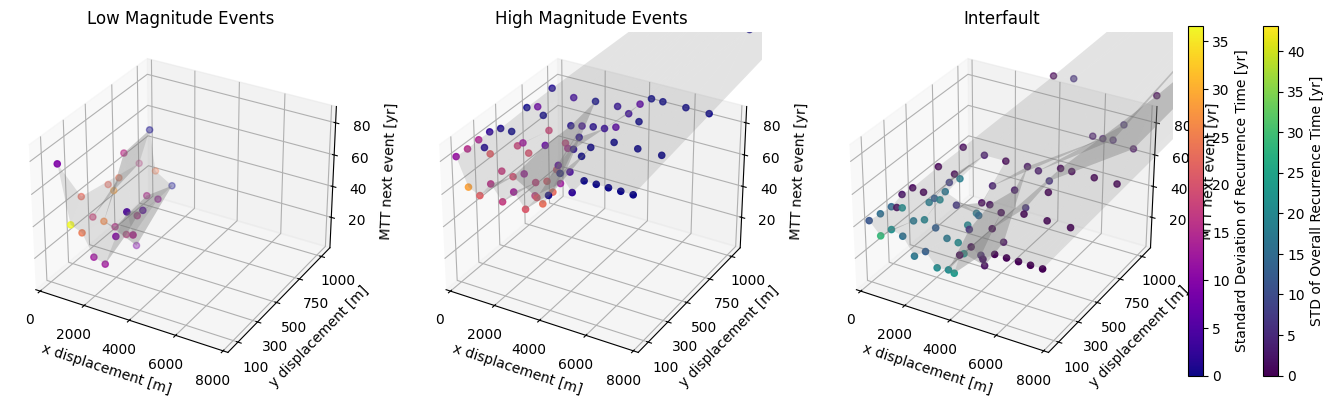

In [45]:
threshold = 4.8 # adjustable threshold for what is considered a 'full' rupture magnitude

df_mag = df_seq.copy()
df_mag['full'] = df_mag['Mw'] > threshold

df_hm = df_mag[df_mag['full'] == True].copy()
df_lm = df_mag[df_mag['full'] == False].copy()

def mean_and_std(group):
    return ([np.mean(group['t_interevent_intrafault']), np.std(group['t_interevent_intrafault']),
            np.mean(group['t_interevent_interfault']), np.std(group['t_interevent_interfault'])])

grouped = df_hm.groupby("model_name")
highmtstat = grouped.apply(lambda x: mean_and_std(x))

grouped = df_lm.groupby("model_name")
lowmtstat  = grouped.apply(lambda x: mean_and_std(x))

# Apply the function to each group
highmts = pd.DataFrame(highmtstat, columns=["stats"])
lowmts = pd.DataFrame(lowmtstat, columns=["stats"])

hmts = highmts[:].copy()
hmts['location'] = [[] for _ in range(len(highmts))]
hmts['location'] = highmts.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = hmts['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
hmts = hmts[mask]

lmts = lowmts[:].copy()
lmts['location'] = [[] for _ in range(len(lmts))]
lmts['location'] = lmts.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = lmts['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
lmts = lmts[mask]

fig = plt.figure(figsize=(15,5))

stdmax = pd.concat([lmts, hmts], ignore_index=True)['stats'].apply(lambda loc: loc[1]).max()
stdomax = hmts['stats'].apply(lambda loc: loc[3]).max()

ax0 = fig.add_subplot(131, projection='3d')
ax1 = fig.add_subplot(132, projection='3d')
ax2 = fig.add_subplot(133, projection='3d')

from matplotlib.colors import LightSource

ls = LightSource(azdeg=120, altdeg=50)

ax0.scatter(np.array(lmts['location'].apply(lambda loc: loc[0])),
           np.array(lmts['location'].apply(lambda loc: loc[1])),
           np.array(lmts['stats'].apply(lambda loc: loc[0])) / t_yr ,c=np.array(lmts['stats'].apply(lambda loc: loc[1])), cmap='plasma', vmin=0, vmax=stdmax)
ax0.plot_trisurf(np.array(lmts['location'].apply(lambda loc: loc[0])),
           np.array(lmts['location'].apply(lambda loc: loc[1])),
           np.array(lmts['stats'].apply(lambda loc: loc[0])) / t_yr,  color='grey', lightsource = ls, shade=True, alpha=0.2, zorder=0.0)

ax1.scatter(np.array(hmts['location'].apply(lambda loc: loc[0])),
           np.array(hmts['location'].apply(lambda loc: loc[1])),
           np.array(hmts['stats'].apply(lambda loc: loc[0])) / t_yr ,c=np.array(hmts['stats'].apply(lambda loc: loc[1])), cmap='plasma', vmin=0, vmax=stdmax)
ax1.plot_trisurf(np.array(hmts['location'].apply(lambda loc: loc[0])),
           np.array(hmts['location'].apply(lambda loc: loc[1])),
           np.array(hmts['stats'].apply(lambda loc: loc[0])) / t_yr,  color='grey', lightsource = ls, shade=True, alpha=0.2, zorder=0.0, vmin=0)
# for i in range(len(hmts)):
#     ax1.plot([np.array(hmts['location'][i][0]),np.array(hmts['location'][i][0])],
#              [np.array(hmts['location'][i][1]),np.array(hmts['location'][i][1])],
#              [np.array(hmts['stats'][i][0]).min(),np.array(hmts['stats'][i][0]).max()])
    
ax2.scatter(np.array(hmts['location'].apply(lambda loc: loc[0])),
           np.array(hmts['location'].apply(lambda loc: loc[1])),
           np.array(hmts['stats'].apply(lambda loc: loc[2])) / t_yr ,c=np.array(hmts['stats'].apply(lambda loc: loc[1])), cmap='viridis', vmin=0, vmax=stdomax)
ax2.plot_trisurf(np.array(hmts['location'].apply(lambda loc: loc[0])),
           np.array(hmts['location'].apply(lambda loc: loc[1])),
           np.array(hmts['stats'].apply(lambda loc: loc[2])) / t_yr, color='grey', lightsource = ls, shade=True, alpha=0.2, zorder=0.0, vmin=0)

norm = mcolors.Normalize(vmin=0, vmax=stdmax / t_yr)
cmap = plt.get_cmap('plasma')

cax = fig.add_axes([0.91, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('Standard Deviation of Recurrence Time [yr]')

norm = mcolors.Normalize(vmin=0, vmax=stdomax / t_yr)
cmap = plt.get_cmap('viridis')

cax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('STD of Overall Recurrence Time [yr]')

for ax in [ax0, ax1, ax2]:
    ax.set_xlim(-200,8200)
    ax.set_xticks([0,2000,4000,6000,8000],[0,2000,4000,6000,8000])
    ax.set_ylim(0,1100)
    ax.set_yticks([100, 300, 500, 750, 1000],[100, 300, 500, 750, 1000])
    ax.set_zlim(0,90)
    ax.set_zticks([20,40,60,80],[20,40,60,80])
    ax.set_xlabel("x displacement [m]")
    ax.set_ylabel("y displacement [m]")
    ax.set_zlabel("MTT next event [yr]")


ax0.set_title("Low Magnitude Events")
ax1.set_title("High Magnitude Events")
ax2.set_title("Interfault")

plt.show()

## 5.3 Violin plots recurrence time

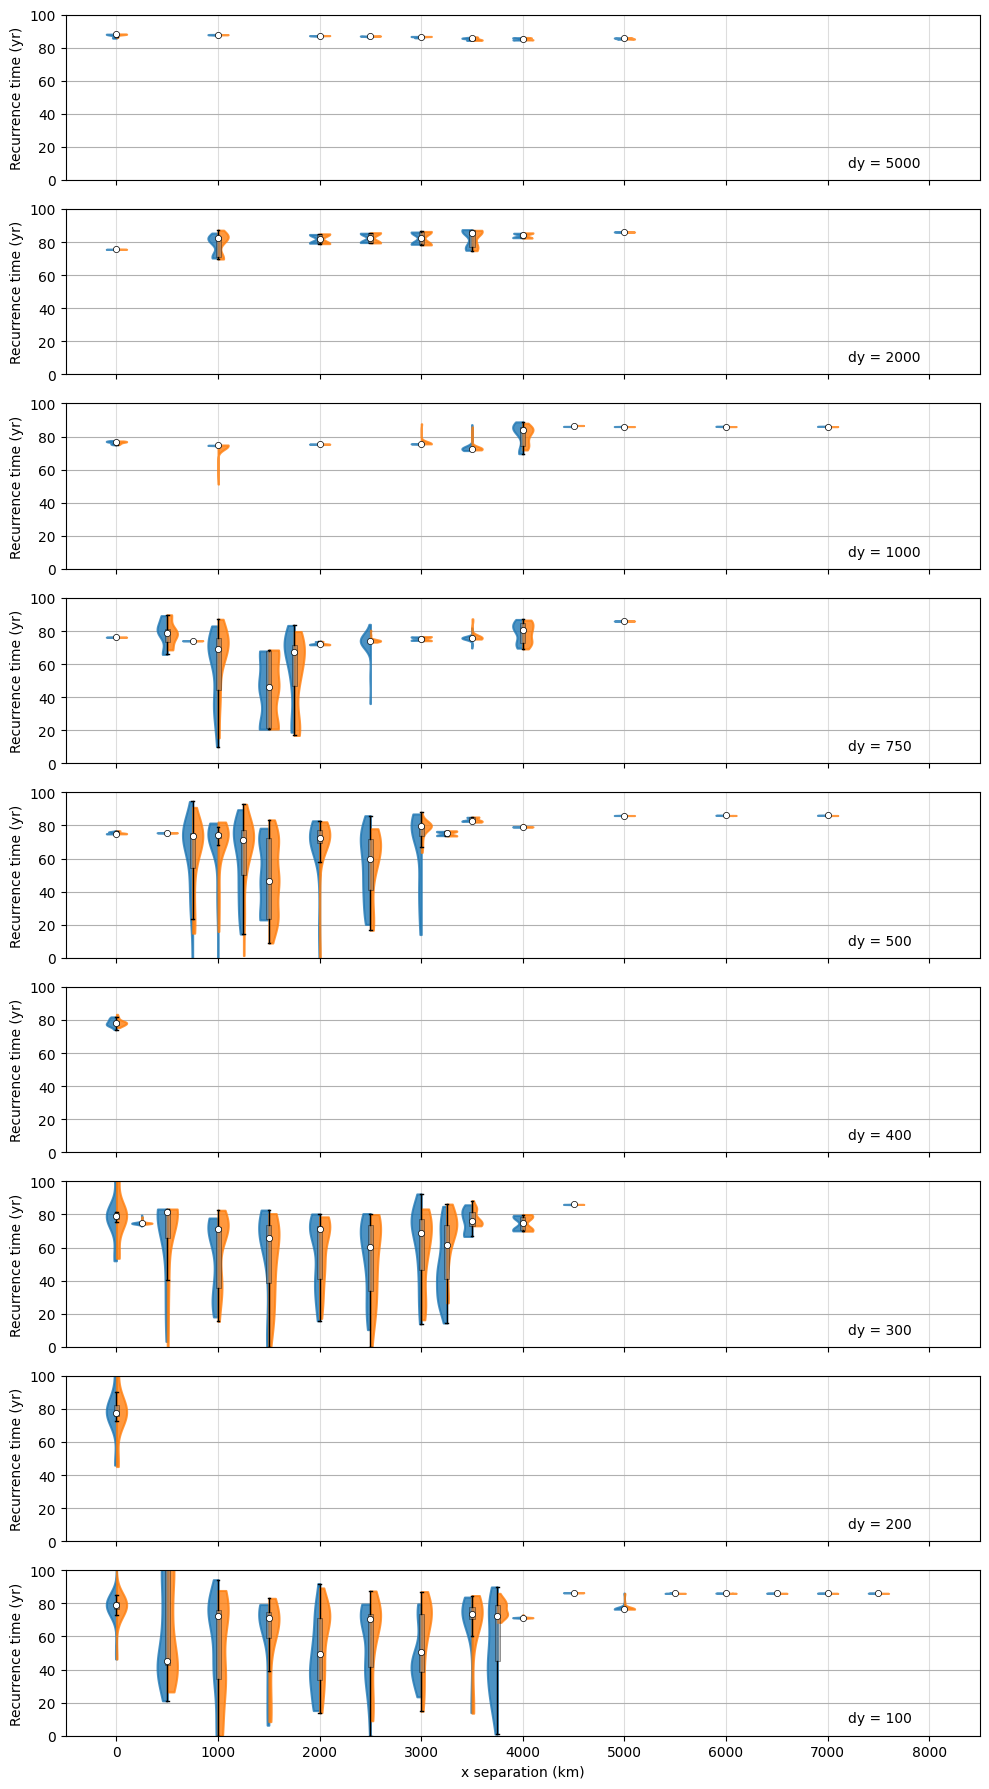

In [46]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

### VALUE of y-separation to plot!
ysep = 300

matplotlib.rcParams['pdf.fonttype'] = 42 

# save event dataframe again
df_ev_all.to_csv("events_dy_nb.txt", sep=" ", index=False)

# create canvas


dy_values_ =df_ev_all.copy()
dy_values = dy_values_.query("model_name != 'mod_def'").copy()
# print(dy_values)
dy_values['location'] = [[] for _ in range(len(dy_values))]
dy_values['location'] = dy_values['model_name'].apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

nplots = len(np.unique(dy_values['dy']))
ydff = (np.unique(dy_values['dy']))
fig, axs = plt.subplots(nrows=nplots, ncols=1, figsize=(10, 2*nplots))
axs = axs.flatten()


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
# Apply the function to the 'location' column
for j in range(len(ydff)):
    ax=axs[j]

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]

    # Custom color values for the last two colors
    custom_colors = ["mediumaquamarine", "lightskyblue"]
    
    # Define the number of colors in the palette (excluding the custom colors)
    num_colors = len(np.unique(dy_values['location'])) - len(custom_colors)
    
    # Create the palette using custom_colors and a subset of the seaborn palette
    palette = sns.color_palette("CMRmap", num_colors) + custom_colors
    
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['dx'] == dy_value[0]].dropna()
        # print(filtered_df)
        
        data1 = filtered_df[filtered_df['fault_label']==1]['t_interevent_intrafault'] / t_yr
        data2 = filtered_df[filtered_df['fault_label']==2]['t_interevent_intrafault'] / t_yr
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        width = 200
        
        parts = ax.violinplot(data1, 
                              positions=[dy_value[0]], 
                              widths=width, 
                              showextrema=False, side='low')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'C0')
            pc.set_edgecolor(f'C0')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)

        parts = ax.violinplot(data2, 
                              positions=[dy_value[0]], 
                              widths=width, 
                              showextrema=False, side='high')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'C1')
            pc.set_edgecolor(f'C1')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)
            
        # Box plot
        bp = ax.boxplot(data,
                        positions=[dy_value[0]],
                        widths=50,
                        showfliers=False,
                        patch_artist=True,
                        medianprops = dict(linestyle=None, linewidth=0))
        
        for box in bp['boxes']:
            box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
            
        # Median
        median = np.percentile(data, [50])
        ax.scatter([dy_value[0]], median, marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)
    
    # grey background
    # Create a background span for dy=1F (limits according to number of elements in dy)
    #ax.axvspan(1700, 3500, facecolor='lightgray', alpha=0.5) # not working
        
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ScalarFormatter())
        
    # Grid lines
    ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.grid(axis='y')
    ax.set_axisbelow(True)    
    
    # Set x-ticks and labels
    ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
    ax.set_xticks(ticks)
    ax.set_xlim(-500,8500)

    ax.set_ylim(0,100)
    
    # Label modifications
    # ax.set_xticklabels(new_labels)
    ax.annotate(f'dy = {ydff_back[j]}', xy=(7200,8))

    if j == len(ydff)-1:
        ax.set_xticklabels(ticks)
        ax.set_xlabel('x separation (km)')
    else:
        ax.set_xticklabels([])

    ax.set_ylabel('Recurrence time (yr)')



plt.tight_layout()

fig.savefig("violin_CV_small_dy_nb.pdf")

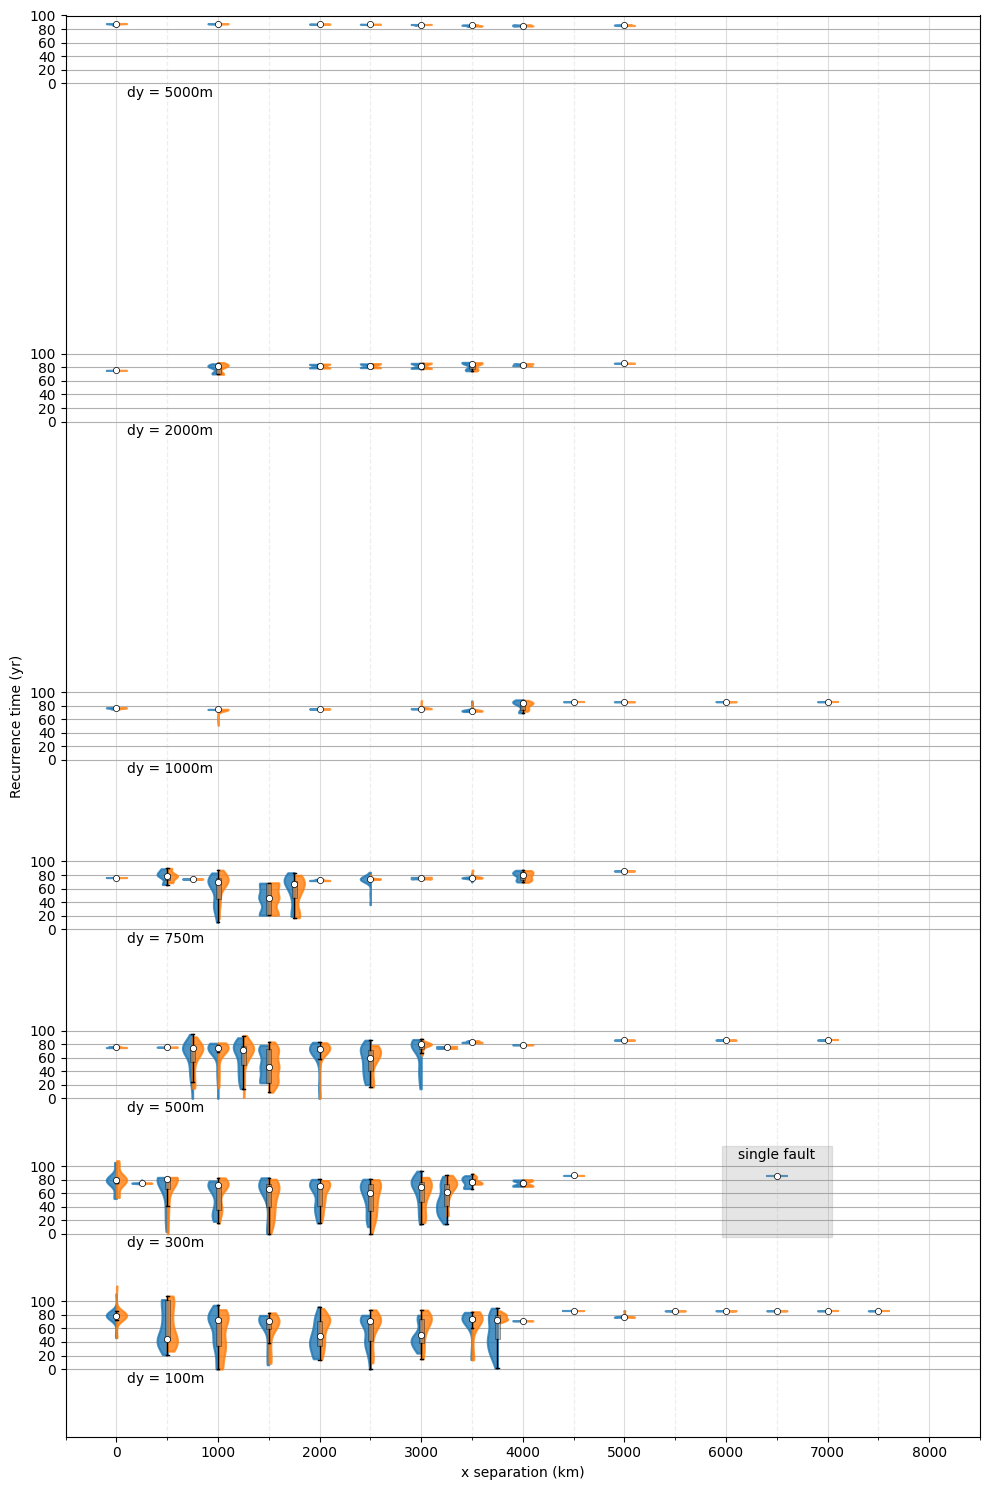

In [47]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

### VALUE of y-separation to plot!
ysep = 300

matplotlib.rcParams['pdf.fonttype'] = 42 

# save event dataframe again
df_ev_all.to_csv("events_dy_nb.txt", sep=" ", index=False)

# create canvas


dy_values_ =df_ev_all.copy()
dy_values = dy_values_.query("model_name != 'mod_def'").copy()
def_values = dy_values_.query("model_name == 'mod_def'").copy()
# print(dy_values)
dy_values['location'] = [[] for _ in range(len(dy_values))]
dy_values['location'] = dy_values['model_name'].apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

nplots = len(np.unique(dy_values['dy']))
ydff = (np.unique(dy_values['dy']))
ydff = [100, 300, 500, 750, 1000, 2000, 5000] # OVERRIDE to block out the one event rows
ydff_placement = [100, 300, 500, 750, 1000, 1500, 2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,15))


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
ydff_p_back = ydff_placement[::-1]

# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
# Apply the function to the 'location' column
for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]

    # Custom color values for the last two colors
    custom_colors = ["mediumaquamarine", "lightskyblue"]
    
    # Define the number of colors in the palette (excluding the custom colors)
    num_colors = len(np.unique(dy_values['location'])) - len(custom_colors)
    
    # Create the palette using custom_colors and a subset of the seaborn palette
    palette = sns.color_palette("CMRmap", num_colors) + custom_colors
    
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['dx'] == dy_value[0]].dropna()
        
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        data1 = filtered_df[filtered_df['fault_label']==1]['t_interevent_intrafault'] / t_yr
        data2 = filtered_df[filtered_df['fault_label']==2]['t_interevent_intrafault'] / t_yr
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        width = 200
        
        parts = ax.violinplot(data1 + ydff_p_back[j], 
                              positions=[dy_value[0]], 
                              widths=width, 
                              showextrema=False, side='low')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'C0')
            pc.set_edgecolor(f'C0')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)

        parts = ax.violinplot(data2 + ydff_p_back[j], 
                              positions=[dy_value[0]], 
                              widths=width, 
                              showextrema=False, side='high')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'C1')
            pc.set_edgecolor(f'C1')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)
            
        # Box plot
        bp = ax.boxplot(data + ydff_p_back[j],
                        positions=[dy_value[0]],
                        widths=50,
                        showfliers=False,
                        patch_artist=True,
                        medianprops = dict(linestyle=None, linewidth=0))
        
        for box in bp['boxes']:
            box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
            
        # Median
        median = np.percentile(data, [50])
        ax.scatter([dy_value[0]], median+ ydff_p_back[j], marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)
    
    # grey background
    # Create a background span for dy=1F (limits according to number of elements in dy)
    #ax.axvspan(1700, 3500, facecolor='lightgray', alpha=0.5) # not working
        
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ScalarFormatter())
        
    # Grid lines
    ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.grid(axis='y')
    ax.set_axisbelow(True)    

    # ax.set_ylim(0,100)
    
    # Label modifications
    # ax.set_xticklabels(new_labels)
    ax.annotate(f'dy = {ydff_back[j]}m', xy=(100,ydff_p_back[j]-20))

filtered_df = def_values.dropna()
data = filtered_df['t_interevent_intrafault'] / t_yr

parts = ax.violinplot(data + 300, 
                      positions=[6500], 
                      widths=width, 
                      showextrema=False)

# Formatting violins
for pc in parts['bodies']:
    pc.set_facecolor(f'C0')
    pc.set_edgecolor(f'C0')
    pc.set_alpha(0.8)
    pc.set_linewidth(1.5)
    
# Box plot
bp = ax.boxplot(data + 300,
                positions=[6500],
                widths=50,
                showfliers=False,
                patch_artist=True,
                medianprops = dict(linestyle=None, linewidth=0))

for box in bp['boxes']:
    box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
    
# Median
median = np.percentile(data, [50])
ax.scatter(6500, median+ 300, marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)

ax.annotate("single fault", xy=(6500,410), ha='center')

ax.fill([5960,7040,7040,5960],[295,295,430,430],color='grey', alpha=0.2)

ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
ax.set_xticks(ticks)
ax.set_xlim(-500,8500)
ax.set_xticklabels(ticks)
ax.set_xlabel('x separation (km)')
ax.set_ylabel('Recurrence time (yr)')

ax.set_ylim(0,1200) # 100,120,140,160,180,200,300,320,340,360,380,400,500,520,540,560,580,600,750,770,790,810,830,850,1000,1020,1040,1060,1080,1100

ax.set_yticks(np.array([[x,x+20,x+40,x+60,x+80,x+100] for x in ydff_placement]).flatten(),[0,20,40,60,80,100]*len(ydff_placement))
ax.xaxis.set_minor_locator(plt.MultipleLocator(500))  # Adjust the interval as needed

# Draw gridlines for minor ticks only with linestyle '--'
ax.grid(True, which='major', linestyle='-')  # Disable major gridlines
ax.grid(True, which='minor', linestyle='--', linewidth=0.9)
plt.tight_layout()

fig.savefig("violins-in-space.pdf")

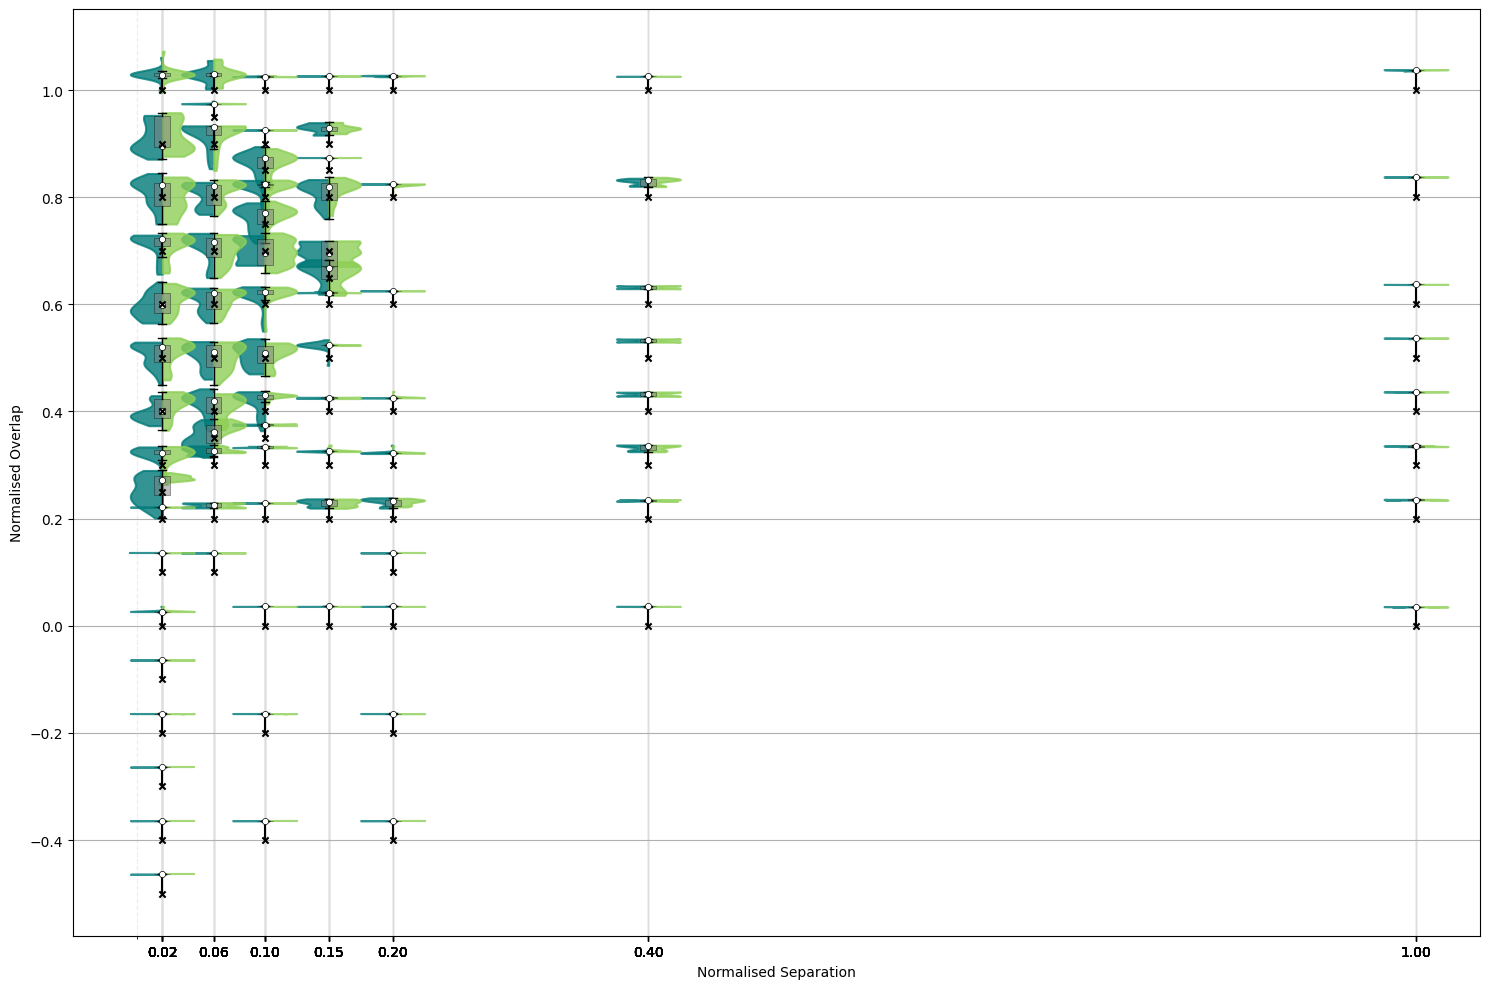

In [48]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

### VALUE of y-separation to plot!
ysep = 300

matplotlib.rcParams['pdf.fonttype'] = 42 

# save event dataframe again
df_ev_all.to_csv("events_dy_nb.txt", sep=" ", index=False)

# create canvas


dy_values_ =df_ev_all.copy()
dy_values = dy_values_.query("model_name != 'mod_def'").copy()
def_values = dy_values_.query("model_name == 'mod_def'").copy()
# print(dy_values)
dy_values['location'] = [[] for _ in range(len(dy_values))]
dy_values['location'] = dy_values['model_name'].apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

nplots = len(np.unique(dy_values['dy']))
ydff = (np.unique(dy_values['dy']))
ydff = [100, 300, 500, 750, 1000, 2000, 5000] # OVERRIDE to block out the one event rows
ydff_placement = [100, 300, 500, 750, 1000, 1500, 2000]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,10))


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
ydff_p_back = ydff_placement[::-1]

# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
# Apply the function to the 'location' column
for j in range(len(ydff)):

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]

    # Custom color values for the last two colors
    custom_colors = ["mediumaquamarine", "lightskyblue"]
    
    # Define the number of colors in the palette (excluding the custom colors)
    num_colors = len(np.unique(dy_values['location'])) - len(custom_colors)
    
    # Create the palette using custom_colors and a subset of the seaborn palette
    palette = sns.color_palette("CMRmap", num_colors) + custom_colors
    
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['dx'] == dy_value[0]].dropna()
        
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        data1 = filtered_df[filtered_df['fault_label']==1]['t_interevent_intrafault'] / t_yr
        data2 = filtered_df[filtered_df['fault_label']==2]['t_interevent_intrafault'] / t_yr
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        width = 0.05
        
        parts = ax.violinplot(data1 / 1000 + (5000 - np.array([dy_value[0]]))  / 5000- 0.05, 
                              positions=(np.array([dy_value[1]])) / 5000, 
                              widths=width, 
                              showextrema=False, side='low')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'#007a78')
            pc.set_edgecolor(f'#007a78')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)

        parts = ax.violinplot(data2 / 1000 + (5000 - np.array([dy_value[0]]))  / 5000- 0.05, 
                              positions=(np.array([dy_value[1]]))  / 5000, 
                              widths=width, 
                              showextrema=False, side='high')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'#8ecf56')
            pc.set_edgecolor(f'#8ecf56')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)
            
        # Box plot
        bp = ax.boxplot(data / 1000 + (5000 - np.array([dy_value[0]]))  / 5000- 0.05,
                        positions=(np.array([dy_value[1]]))  / 5000,
                        widths=width/4,
                        showfliers=False,
                        patch_artist=True,
                        medianprops = dict(linestyle=None, linewidth=0))
        
        for box in bp['boxes']:
            box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
            
        # Median
        median = np.percentile(data, [50])
        ax.scatter((np.array([dy_value[1]])) / 5000, median / 1000 + (5000 - np.array([dy_value[0]]))  / 5000- 0.05, marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)
        ax.scatter((np.array([dy_value[1]])) / 5000,(5000 - np.array([dy_value[0]]))  / 5000, marker='x', color='k', s=20, zorder=3)
        ax.plot([(np.array([dy_value[1]])) / 5000,(np.array([dy_value[1]])) / 5000],
                [median / 1000 + (5000 - np.array([dy_value[0]]))  / 5000 - 0.05, (5000 - np.array([dy_value[0]]))  / 5000],color='k')
    
    # grey background
    # Create a background span for dy=1F (limits according to number of elements in dy)
    #ax.axvspan(1700, 3500, facecolor='lightgray', alpha=0.5) # not working
        
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ScalarFormatter())
        
    # Grid lines
    ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.grid(axis='y')
    ax.set_axisbelow(True)    

    # ax.set_ylim(0,100)
    
    # Label modifications
    # ax.set_xticklabels(new_labels)
    # ax.annotate(f'dy = {ydff_back[j]}m', xy=(100,ydff_p_back[j]-20))

filtered_df = def_values.dropna()
data = filtered_df['t_interevent_intrafault'] / t_yr

# parts = ax.violinplot(data + 300, 
#                       positions=[6500], 
#                       widths=width, 
#                       showextrema=False)

# # Formatting violins
# for pc in parts['bodies']:
#     pc.set_facecolor(f'C0')
#     pc.set_edgecolor(f'C0')
#     pc.set_alpha(0.8)
#     pc.set_linewidth(1.5)
    
# # Box plot
# bp = ax.boxplot(data + 300,
#                 positions=[6500],
#                 widths=50,
#                 showfliers=False,
#                 patch_artist=True,
#                 medianprops = dict(linestyle=None, linewidth=0))

# for box in bp['boxes']:
#     box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
    
# Median
#median = np.percentile(data, [50])
#ax.scatter(6500, median+ 300, marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)

#ax.annotate("single fault", xy=(6500,410), ha='center')

#ax.fill([5960,7040,7040,5960],[295,295,430,430],color='grey', alpha=0.2)

#ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
#ax.set_xticks(ticks)
ax.set_xlim(-0.05,1.05)
# ax.set_xticklabels(ticks)
ax.set_xlabel('Normalised Separation')
ax.set_ylabel('Normalised Overlap')

#ax.set_ylim(0,1200) # 100,120,140,160,180,200,300,320,340,360,380,400,500,520,540,560,580,600,750,770,790,810,830,850,1000,1020,1040,1060,1080,1100

#ax.set_yticks(np.array([[x,x+20,x+40,x+60,x+80,x+100] for x in ydff_placement]).flatten(),[0,20,40,60,80,100]*len(ydff_placement))
ax.xaxis.set_minor_locator(plt.MultipleLocator(500))  # Adjust the interval as needed

# Draw gridlines for minor ticks only with linestyle '--'
ax.grid(True, which='major', linestyle='-')  # Disable major gridlines
ax.grid(True, which='minor', linestyle='--', linewidth=0.9)
plt.tight_layout()

fig.savefig("violins-in-space.pdf")

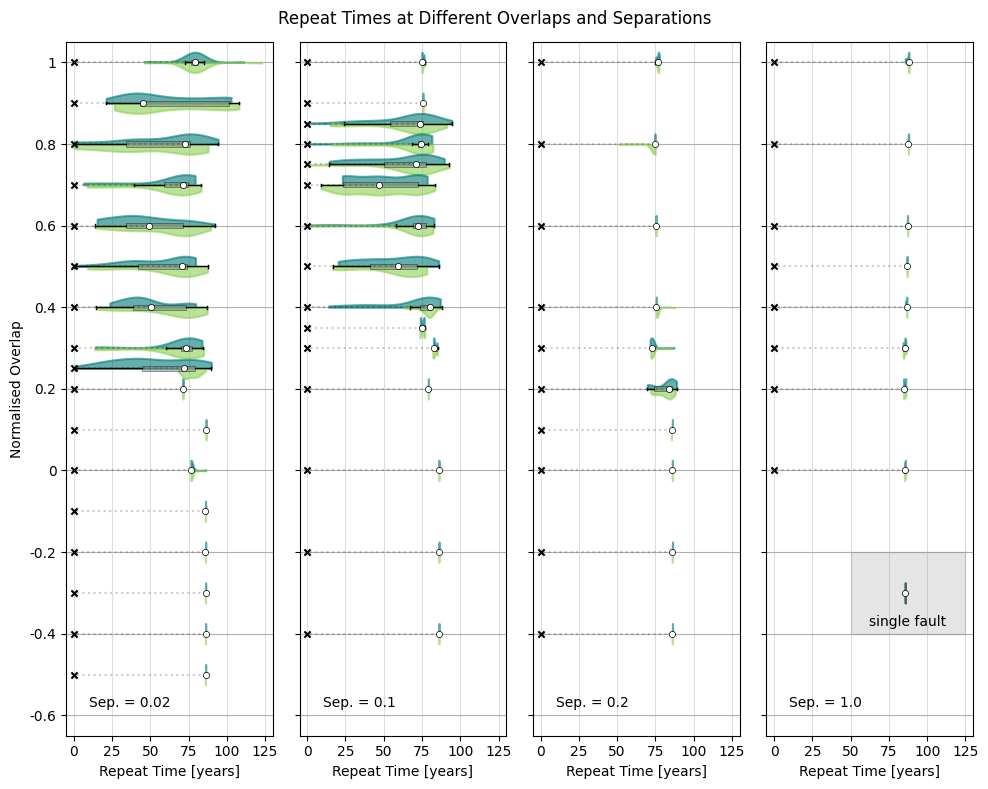

In [49]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

### VALUE of y-separation to plot!
ysep = 300

matplotlib.rcParams['pdf.fonttype'] = 42 

# save event dataframe again
df_ev_all.to_csv("events_dy_nb.txt", sep=" ", index=False)

# create canvas


dy_values_ =df_ev_all.copy()
dy_values = dy_values_.query("model_name != 'mod_def'").copy()
def_values = dy_values_.query("model_name == 'mod_def'").copy()
# print(dy_values)
dy_values['location'] = [[] for _ in range(len(dy_values))]
dy_values['location'] = dy_values['model_name'].apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

nplots = len(np.unique(dy_values['dy']))
ydff = (np.unique(dy_values['dy']))
ydff = [100, 500, 1000,  5000] # OVERRIDE to block out the one event rows
ydff_placement = [100]

nplots = len(ydff)

fig, axs = plt.subplots(nrows=1, ncols=nplots, figsize=(10, 2*nplots))
axs = axs.flatten()


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
ydff_p_back = ydff_placement[::-1]

# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff
# Apply the function to the 'location' column
for j in range(len(ydff)):
    ax = axs[j]

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]

    # Custom color values for the last two colors
    custom_colors = ["mediumaquamarine", "lightskyblue"]
    
    # Define the number of colors in the palette (excluding the custom colors)
    num_colors = len(np.unique(dy_values['location'])) - len(custom_colors)
    
    # Create the palette using custom_colors and a subset of the seaborn palette
    palette = sns.color_palette("CMRmap", num_colors) + custom_colors
    
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['dx'] == dy_value[0]].dropna()
        
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        data1 = filtered_df[filtered_df['fault_label']==1]['t_interevent_intrafault'] / t_yr
        data2 = filtered_df[filtered_df['fault_label']==2]['t_interevent_intrafault'] / t_yr
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        width = 0.05
        
        parts = ax.violinplot( data1 + (np.array([dy_value[1]]))*0 / 5000,
                              positions=(5000 - np.array([dy_value[0]]))  / 5000, 
                              widths=width, 
                              showextrema=False, side='high', vert=False)
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'#007a78')
            pc.set_edgecolor(f'#007a78')
            pc.set_alpha(0.6)
            pc.set_linewidth(1.5)

        parts = ax.violinplot( data2  +(np.array([dy_value[1]]))*0 / 5000,
                              positions= (5000 - np.array([dy_value[0]]))  / 5000,
                              widths=width, 
                              showextrema=False, side='low', vert=False)
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'#8ecf56')
            pc.set_edgecolor(f'#8ecf56')
            pc.set_alpha(0.6)
            pc.set_linewidth(1.5)
            
        # Box plot
        bp = ax.boxplot( data +(np.array([dy_value[1]]))*0 / 5000,
                        positions= (5000 - np.array([dy_value[0]]))  / 5000,
                        widths=width/4,
                        showfliers=False,
                        patch_artist=True,
                        medianprops = dict(linestyle=None, linewidth=0), vert=False)
        
        for box in bp['boxes']:
            box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
            
        # Median
        median = np.percentile(data, [50])
        ax.scatter(median  + (5000 - np.array([dy_value[1]]))*0  / 5000, (5000 - np.array([dy_value[0]]))  / 5000,  marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)
        ax.scatter((5000 - np.array([dy_value[1]]))*0  / 5000, (5000 - np.array([dy_value[0]]))  / 5000, marker='x', color='k', s=20, zorder=3)
        ax.plot([median + (5000 - np.array([dy_value[1]]))*0  / 5000, (5000 - np.array([dy_value[1]]))*0  / 5000],
                [ (5000 - np.array([dy_value[0]]))  / 5000, (5000 - np.array([dy_value[0]]))  / 5000],color='k',ls=':',alpha=0.2)
    
    # grey background
    # Create a background span for dy=1F (limits according to number of elements in dy)
    #ax.axvspan(1700, 3500, facecolor='lightgray', alpha=0.5) # not working
        
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ScalarFormatter())
        
    # Grid lines
    ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.grid(axis='y')
    ax.set_axisbelow(True)    

    # ax.set_ylim(0,100)
    
    # Label modifications
    # ax.set_xticklabels(new_labels)
    ax.annotate(f'Sep. = {ydff_back[j] / 5000}', xy=(10,-0.58))

filtered_df = def_values.dropna()
data = filtered_df['t_interevent_intrafault'] / t_yr

parts = axs[3].violinplot(data, 
                       positions=[-0.3], 
                       widths=width, 
                       showextrema=False, vert=False)

# # Formatting violins
for pc in parts['bodies']:
     pc.set_facecolor(f'#023947')
     pc.set_edgecolor(f'#023947')
     pc.set_alpha(0.8)
     pc.set_linewidth(1.5)
    
# # Box plot
bp = axs[3].boxplot(data,
                 positions=[-0.3],
                 widths=width / 4,
                 showfliers=False,
                 patch_artist=True,
                 medianprops = dict(linestyle=None, linewidth=0), vert=False)

for box in bp['boxes']:
     box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
    
# Median
median = np.percentile(data, [50])
axs[3].scatter( median,-0.3, marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)

axs[3].annotate("single fault", xy=(87.5,-0.38), ha='center')

axs[3].fill([125,125,50,50],[-0.4,-0.2,-0.2,-0.4],color='grey', alpha=0.2)

ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
ax.set_xticks(ticks)
for ax in axs:
     ax.set_ylim(-0.65,1.05)
     # ax.set_xticklabels(ticks)
     ax.set_yticks([1,0.8,0.6,0.4,0.2,0,-.2,-.4,-.6],[])
     ax.set_xticks([0,25,50,75,100,125],[0,25,50,75,100,125])
     ax.set_xlim(-5,130)
    


# #ax.set_ylim(0,1200) # 100,120,140,160,180,200,300,320,340,360,380,400,500,520,540,560,580,600,750,770,790,810,830,850,1000,1020,1040,1060,1080,1100

# #ax.set_yticks(np.array([[x,x+20,x+40,x+60,x+80,x+100] for x in ydff_placement]).flatten(),[0,20,40,60,80,100]*len(ydff_placement))
     ax.yaxis.set_minor_locator(plt.MultipleLocator(500))  # Adjust the interval as needed
    
    # Draw gridlines for minor ticks only with linestyle '--'
     ax.grid(True, which='major', linestyle='-')  # Disable major gridlines
     ax.grid(True, which='minor', linestyle='--', linewidth=0.9)

     ax.set_xlabel('Repeat Time [years]')

    
axs[0].set_ylabel('Normalised Overlap')
axs[0].set_yticks([1,0.8,0.6,0.4,0.2,0,-.2,-.4,-.6],[1,0.8,0.6,0.4,0.2,0,-.2,-.4,-.6])

fig.suptitle("Repeat Times at Different Overlaps and Separations")
plt.tight_layout()

fig.savefig("violins-in-space.pdf")

                min_t         max_t  cum_slip  cum_potency    peak_v  \
n_event                                                                
1        3.946989e+09  3.946989e+09  0.059223    1539309.0  1.747498   
2        5.409775e+09  5.409775e+09  0.064052    1664834.0  1.506440   
3        7.829378e+09  7.829378e+09  0.059534    1547400.0  1.730296   
4        1.133381e+10  1.133381e+10  0.058895    1530780.0  1.775573   
5        1.380081e+10  1.380081e+10  0.058957    1532410.0  1.730147   
...               ...           ...       ...          ...       ...   
17       4.983588e+10  4.983588e+10  0.066297    1723190.0  1.670247   
18       5.258087e+10  5.258087e+10  0.066228    1721400.0  1.688842   
19       5.532887e+10  5.532887e+10  0.066199    1720630.0  1.671217   
20       5.807386e+10  5.807386e+10  0.066270    1722490.0  1.689047   
21       6.082187e+10  6.082187e+10  0.066251    1722000.0  1.671546   

         dt_event       t_event  t_interevent_intrafault       

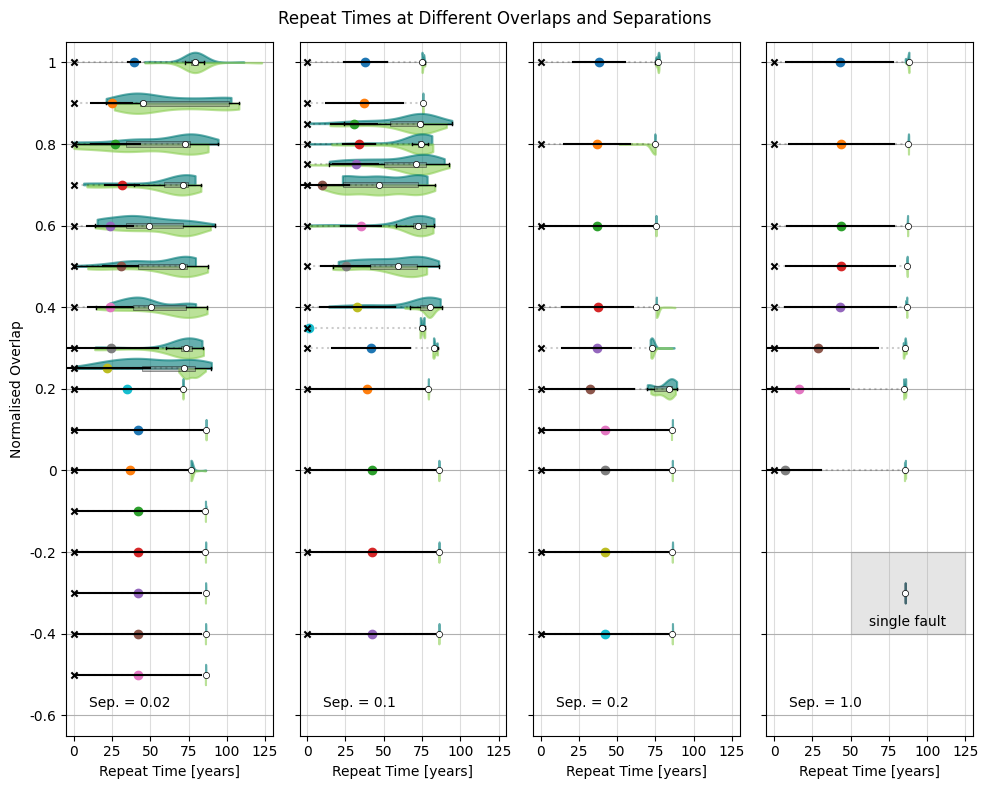

In [50]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 0.0 # adjustable threshold for what is considered a 'full' rupture magnitude

df_mag = df_seq.copy()
df_mag['full'] = df_mag['Mw'] > threshold

df_hm = df_mag[df_mag['full'] == True].copy()
df_lm = df_mag[df_mag['full'] == False].copy()

def mean_and_std(group):
    return ([np.mean(group['t_interevent_intrafault']), np.std(group['t_interevent_intrafault']),
            np.mean(group['t_interevent_interfault']), np.std(group['t_interevent_interfault'])])

grouped = df_hm.groupby("model_name")
highmtstat = grouped.apply(lambda x: mean_and_std(x))

grouped = df_lm.groupby("model_name")
lowmtstat  = grouped.apply(lambda x: mean_and_std(x))

# Apply the function to each group
highmts = pd.DataFrame(highmtstat, columns=["stats"])
lowmts = pd.DataFrame(lowmtstat, columns=["stats"])

hmts = highmts[:].copy()
hmts['location'] = [[] for _ in range(len(highmts))]
hmts['location'] = highmts.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = hmts['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
hmts = hmts[mask]


### VALUE of y-separation to plot!
ysep = 300

matplotlib.rcParams['pdf.fonttype'] = 42 

# save event dataframe again
df_ev_all.to_csv("events_dy_nb.txt", sep=" ", index=False)

# create canvas


dy_values_ =df_ev_all.copy()
dy_values = dy_values_.query("model_name != 'mod_def'").copy()
def_values = dy_values_.query("model_name == 'mod_def'").copy()
print(dy_values)
dy_values['location'] = [[] for _ in range(len(dy_values))]
dy_values['location'] = dy_values['model_name'].apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

nplots = len(np.unique(dy_values['dy']))
ydff = (np.unique(dy_values['dy']))
ydff = [100, 500, 1000,  5000] # OVERRIDE to block out the one event rows
ydff_placement = [100]

nplots = len(ydff)

fig, axs = plt.subplots(nrows=1, ncols=nplots, figsize=(10, 2*nplots))
axs = axs.flatten()


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
ydff_p_back = ydff_placement[::-1]

# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff
# Apply the function to the 'location' column
for j in range(len(ydff)):
    ax = axs[j]

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]

    # Custom color values for the last two colors
    custom_colors = ["mediumaquamarine", "lightskyblue"]
    
    # Define the number of colors in the palette (excluding the custom colors)
    num_colors = len(np.unique(dy_values['location'])) - len(custom_colors)
    
    # Create the palette using custom_colors and a subset of the seaborn palette
    palette = sns.color_palette("CMRmap", num_colors) + custom_colors
    
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['dx'] == dy_value[0]].dropna()

        FILT_ST = hmts[(hmts['location'].apply(lambda loc: loc[0]) == dy_value[0]) & (hmts['location'].apply(lambda loc: loc[1]) == dy_value[1])]

        #print(filtered_df)
        
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        data1 = filtered_df[filtered_df['fault_label']==1]['t_interevent_intrafault'] / t_yr
        data2 = filtered_df[filtered_df['fault_label']==2]['t_interevent_intrafault'] / t_yr
        data = filtered_df['t_interevent_intrafault'] / t_yr
        
        # Width of the violins
        width = 0.05
        
        parts = ax.violinplot( data1 + (np.array([dy_value[1]]))*0 / 5000,
                              positions=(5000 - np.array([dy_value[0]]))  / 5000, 
                              widths=width, 
                              showextrema=False, side='high', vert=False)
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'#007a78')
            pc.set_edgecolor(f'#007a78')
            pc.set_alpha(0.6)
            pc.set_linewidth(1.5)

        parts = ax.violinplot( data2  +(np.array([dy_value[1]]))*0 / 5000,
                              positions= (5000 - np.array([dy_value[0]]))  / 5000,
                              widths=width, 
                              showextrema=False, side='low', vert=False)
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'#8ecf56')
            pc.set_edgecolor(f'#8ecf56')
            pc.set_alpha(0.6)
            pc.set_linewidth(1.5)
            
        # Box plot
        bp = ax.boxplot( data +(np.array([dy_value[1]]))*0 / 5000,
                        positions= (5000 - np.array([dy_value[0]]))  / 5000,
                        widths=width/4,
                        showfliers=False,
                        patch_artist=True,
                        medianprops = dict(linestyle=None, linewidth=0), vert=False)
        
        for box in bp['boxes']:
            box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
            
        # Median
        median = np.percentile(data, [50])
        ax.scatter(median  + (5000 - np.array([dy_value[1]]))*0  / 5000, (5000 - np.array([dy_value[0]]))  / 5000,  marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)
        ax.scatter((5000 - np.array([dy_value[1]]))*0  / 5000, (5000 - np.array([dy_value[0]]))  / 5000, marker='x', color='k', s=20, zorder=3)

        ax.scatter(np.array(FILT_ST['stats'].apply(lambda loc: loc[2])) / t_yr, (5000 - np.array(FILT_ST['location'].apply(lambda loc: loc[0]))) / 5000)
        ax.plot([np.array(FILT_ST['stats'].apply(lambda loc: loc[2])) / t_yr - np.array(FILT_ST['stats'].apply(lambda loc: loc[3])) / t_yr,
                np.array(FILT_ST['stats'].apply(lambda loc: loc[2])) / t_yr + np.array(FILT_ST['stats'].apply(lambda loc: loc[3])) / t_yr],
                [(5000 - np.array(FILT_ST['location'].apply(lambda loc: loc[0]))) / 5000,
                (5000 - np.array(FILT_ST['location'].apply(lambda loc: loc[0]))) / 5000],color='k')
        ax.plot([median + (5000 - np.array([dy_value[1]]))*0  / 5000, (5000 - np.array([dy_value[1]]))*0  / 5000],
                [ (5000 - np.array([dy_value[0]]))  / 5000, (5000 - np.array([dy_value[0]]))  / 5000],color='k',ls=':',alpha=0.2)
    
    # grey background
    # Create a background span for dy=1F (limits according to number of elements in dy)
    #ax.axvspan(1700, 3500, facecolor='lightgray', alpha=0.5) # not working
        
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ScalarFormatter())
        
    # Grid lines
    ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.grid(axis='y')
    ax.set_axisbelow(True)    

    # ax.set_ylim(0,100)
    
    # Label modifications
    # ax.set_xticklabels(new_labels)
    ax.annotate(f'Sep. = {ydff_back[j] / 5000}', xy=(10,-0.58))

filtered_df = def_values.dropna()
data = filtered_df['t_interevent_intrafault'] / t_yr

parts = axs[3].violinplot(data, 
                       positions=[-0.3], 
                       widths=width, 
                       showextrema=False, vert=False)

# # Formatting violins
for pc in parts['bodies']:
     pc.set_facecolor(f'#023947')
     pc.set_edgecolor(f'#023947')
     pc.set_alpha(0.8)
     pc.set_linewidth(1.5)
    
# # Box plot
bp = axs[3].boxplot(data,
                 positions=[-0.3],
                 widths=width / 4,
                 showfliers=False,
                 patch_artist=True,
                 medianprops = dict(linestyle=None, linewidth=0), vert=False)

for box in bp['boxes']:
     box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
    
# Median
median = np.percentile(data, [50])
axs[3].scatter( median,-0.3, marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)

axs[3].annotate("single fault", xy=(87.5,-0.38), ha='center')

axs[3].fill([125,125,50,50],[-0.4,-0.2,-0.2,-0.4],color='grey', alpha=0.2)

ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
ax.set_xticks(ticks)
for ax in axs:
     ax.set_ylim(-0.65,1.05)
     # ax.set_xticklabels(ticks)
     ax.set_yticks([1,0.8,0.6,0.4,0.2,0,-.2,-.4,-.6],[])
     ax.set_xticks([0,25,50,75,100,125],[0,25,50,75,100,125])
     ax.set_xlim(-5,130)
    


# #ax.set_ylim(0,1200) # 100,120,140,160,180,200,300,320,340,360,380,400,500,520,540,560,580,600,750,770,790,810,830,850,1000,1020,1040,1060,1080,1100

# #ax.set_yticks(np.array([[x,x+20,x+40,x+60,x+80,x+100] for x in ydff_placement]).flatten(),[0,20,40,60,80,100]*len(ydff_placement))
     ax.yaxis.set_minor_locator(plt.MultipleLocator(500))  # Adjust the interval as needed
    
    # Draw gridlines for minor ticks only with linestyle '--'
     ax.grid(True, which='major', linestyle='-')  # Disable major gridlines
     ax.grid(True, which='minor', linestyle='--', linewidth=0.9)

     ax.set_xlabel('Repeat Time [years]')

    
axs[0].set_ylabel('Normalised Overlap')
axs[0].set_yticks([1,0.8,0.6,0.4,0.2,0,-.2,-.4,-.6],[1,0.8,0.6,0.4,0.2,0,-.2,-.4,-.6])

fig.suptitle("Repeat Times at Different Overlaps and Separations")
plt.tight_layout()

fig.savefig("violins-in-space.pdf")

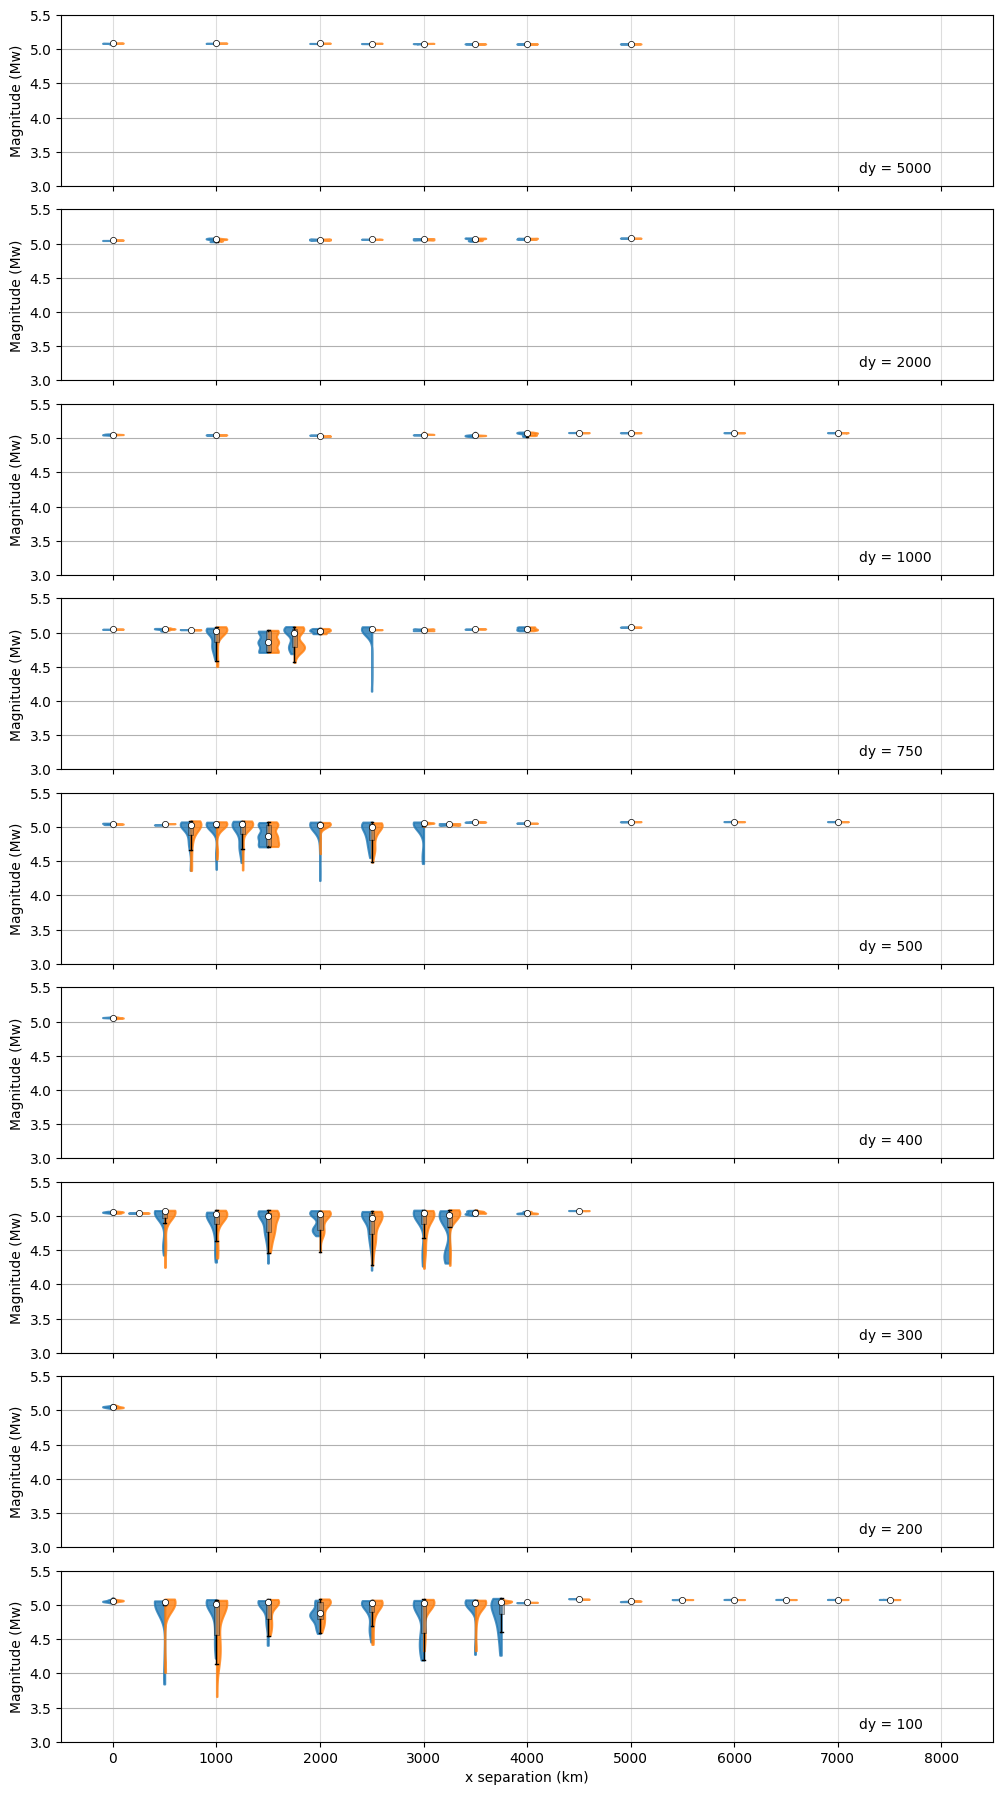

In [51]:
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt

### VALUE of y-separation to plot!
ysep = 300

matplotlib.rcParams['pdf.fonttype'] = 42 

# save event dataframe again
df_ev_all.to_csv("events_dy_nb.txt", sep=" ", index=False)

# create canvas


dy_values_ =df_ev_all.copy()
dy_values = dy_values_.query("model_name != 'mod_def'").copy()
# print(dy_values)
dy_values['location'] = [[] for _ in range(len(dy_values))]
dy_values['location'] = dy_values['model_name'].apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])
mask = dy_values['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
dy_values = dy_values[mask]

dyv = dy_values.copy()

nplots = len(np.unique(dy_values['dy']))
ydff = (np.unique(dy_values['dy']))
fig, axs = plt.subplots(nrows=nplots, ncols=1, figsize=(10, 2*nplots))
axs = axs.flatten()


# Transform positions using a logarithmic scale
def safe_log10(x):
    return np.log10(x) if x > 0 else -1.

ydff_back = ydff[::-1]
# Apply the function to the 'location' column
for j in range(len(ydff)):
    ax=axs[j]

    dy_values=dyv.copy()
    mask = dy_values['location'].apply(lambda loc: loc[1] == ydff_back[j] if len(loc) == 3 else False)
    dy_values = dy_values[mask]

    # Custom color values for the last two colors
    custom_colors = ["mediumaquamarine", "lightskyblue"]
    
    # Define the number of colors in the palette (excluding the custom colors)
    num_colors = len(np.unique(dy_values['location'])) - len(custom_colors)
    
    # Create the palette using custom_colors and a subset of the seaborn palette
    palette = sns.color_palette("CMRmap", num_colors) + custom_colors
    
        
    positions = [safe_log10(loc[0]) for loc in dy_values['location']]
        
    for i, dy_value in enumerate(np.unique(dy_values['location'])):
        
        filtered_df = dy_values[dy_values['dx'] == dy_value[0]].dropna()
        # print(filtered_df)
        
        data1 = filtered_df[filtered_df['fault_label']==1]['Mw']
        data2 = filtered_df[filtered_df['fault_label']==2]['Mw']
        data = filtered_df['Mw']
        
        # Width of the violins
        width = 200
        
        parts = ax.violinplot(data1, 
                              positions=[dy_value[0]], 
                              widths=width, 
                              showextrema=False, side='low')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'C0')
            pc.set_edgecolor(f'C0')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)

        parts = ax.violinplot(data2, 
                              positions=[dy_value[0]], 
                              widths=width, 
                              showextrema=False, side='high')
        
        # Formatting violins
        for pc in parts['bodies']:
            pc.set_facecolor(f'C1')
            pc.set_edgecolor(f'C1')
            pc.set_alpha(0.8)
            pc.set_linewidth(1.5)
            
        # Box plot
        bp = ax.boxplot(data,
                        positions=[dy_value[0]],
                        widths=50,
                        showfliers=False,
                        patch_artist=True,
                        medianprops = dict(linestyle=None, linewidth=0))
        
        for box in bp['boxes']:
            box.set(facecolor='grey', alpha=0.5, linewidth=0.5)
            
        # Median
        median = np.percentile(data, [50])
        ax.scatter([dy_value[0]], median, marker='o', color='white', s=20, edgecolor='black', lw=0.5, zorder=3)
    
    # grey background
    # Create a background span for dy=1F (limits according to number of elements in dy)
    #ax.axvspan(1700, 3500, facecolor='lightgray', alpha=0.5) # not working
        
    from matplotlib.ticker import ScalarFormatter
    for axis in [ax.xaxis]:
        axis.set_major_formatter(ScalarFormatter())
        
    # Grid lines
    ax.grid(axis='x', which='major', color='#DDDDDD', linewidth=0.8)
    ax.grid(axis='x', which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    ax.grid(axis='y')
    ax.set_axisbelow(True)    
    
    # Set x-ticks and labels
    ticks = [0,1000,2000,3000,4000,5000,6000,7000,8000]
    ax.set_xticks(ticks)
    ax.set_xlim(-500,8500)

    ax.set_ylim(3,5.5)
    
    # Label modifications
    # ax.set_xticklabels(new_labels)
    ax.annotate(f'dy = {ydff_back[j]}', xy=(7200,3.2))

    if j == len(ydff)-1:
        ax.set_xticklabels(ticks)
        ax.set_xlabel('x separation (km)')
    else:
        ax.set_xticklabels([])

    ax.set_ylabel('Magnitude (Mw)')



plt.tight_layout()

fig.savefig("violin_MW_small_dy_nb.pdf")

ev not found
location


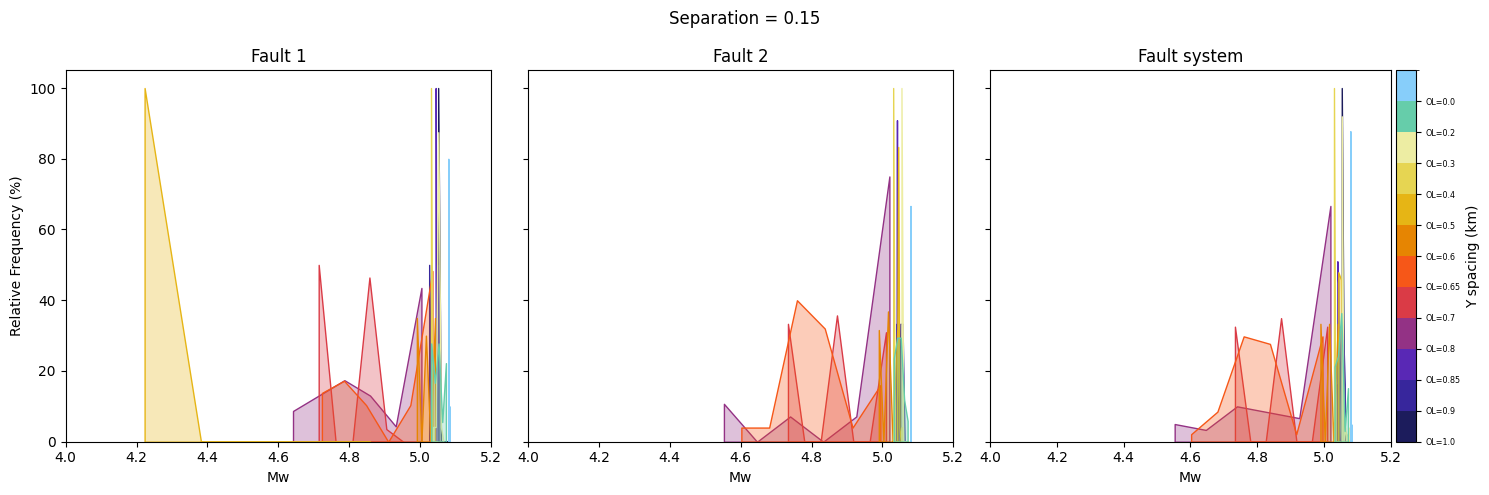

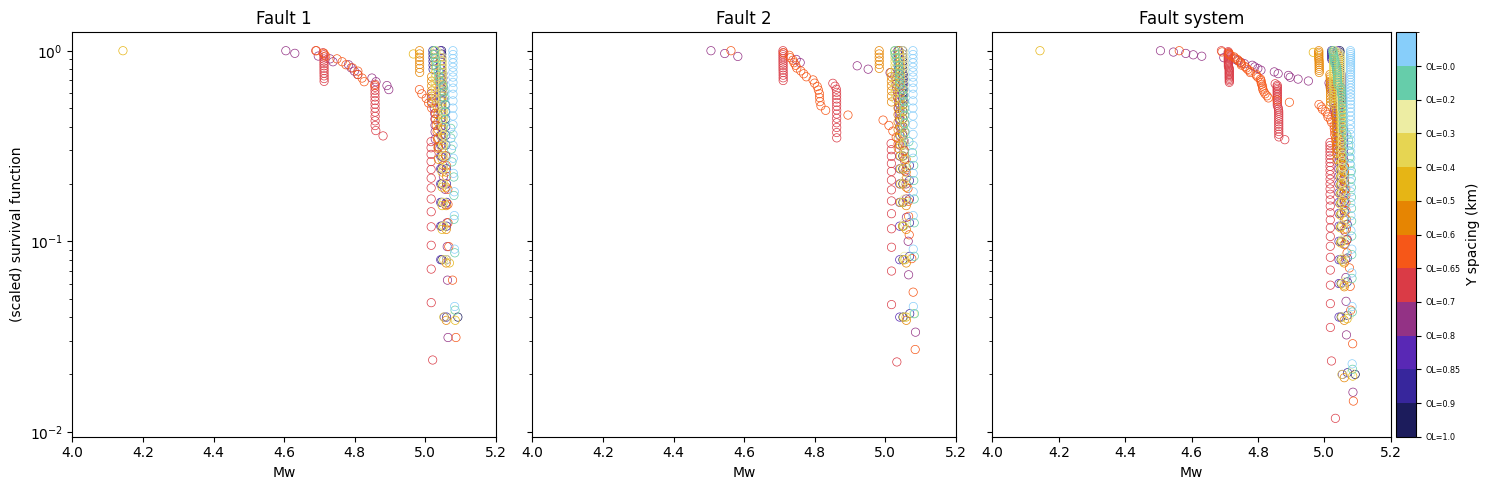

In [52]:
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib

plt.close("all")
matplotlib.rcParams['pdf.fonttype'] = 42 

# Create canvas
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5), squeeze=False,sharey=True)


# when plotting lines for F1, F2 and system
fig2, ax2 = plt.subplots(nrows=1, ncols=3, figsize=(15,5), squeeze=False, sharey=True)


# Set dy offset



# Labels
lbl1 = "F1"
lbl2 = "F2"
lbl = "System"

dy_values_ =models_dict.copy()
# print(models_dict['mod_1000x_1000y_0z'])

dy_values = {k: v for k, v in models_dict.items() if k != 'mod_def'}

# Extract locations and filter out keys without a complete match
valid_keys = []
locations = []

for key in dy_values.keys():
    match_x = re.search(r'_(\d+)x_', key)
    match_y = re.search(r'_(\d+)y_', key)
    match_z = re.search(r'_(\d+)z', key)

    if match_x and match_y and match_z:
        valid_keys.append(key)
        locations.append([
            int(match_x.group(1)),
            int(match_y.group(1)),
            int(match_z.group(1))
        ])

# Create a mask to filter based on the third element (z-value) being 0
mask = [loc[2] == 0 for loc in locations]

# Filter dy_values based on the mask
dy_values_filtered = {k: dy_values[k] for i, k in enumerate(valid_keys) if mask[i]}

# Also include the filtered locations
dy_values_filtered['location'] = [locations[i] for i in range(len(mask)) if mask[i]]

dy_values = dy_values_filtered



# Assuming `selecty` is the value you want to filter by
selecty = 750  # Replace with your actual value

# Filter dy_values based on the second element (y-value) matching `selecty`
dyvv = {}
filtered_locations = []

for i, (k, v) in enumerate(dy_values.items()):
    if k == 'location':
        continue  # Skip 'location' key in the main filtering loop
    
    # Check if the y-value in the corresponding location matches `selecty`
    if dy_values['location'][i][1] == selecty:
        dyvv[k] = v
        filtered_locations.append(dy_values['location'][i])

# Add the filtered locations to the new dictionary
dyvv['location'] = filtered_locations

valid_keys = []
locations = []

for key in dyvv.keys():
    match_x = re.search(r'_(\d+)x_', key)
    match_y = re.search(r'_(\d+)y_', key)
    match_z = re.search(r'_(\d+)z', key)

    if match_x and match_y and match_z:
        valid_keys.append(key)
        locations.append([
            int(match_x.group(1)),
            int(match_y.group(1)),
            int(match_z.group(1))
        ])

# Create a mask to filter based on the third element (z-value) being 0
dy = [loc[0] for loc in locations]

custom_colors = ["mediumaquamarine", "lightskyblue"]

# Define the number of colors in the palette (excluding the custom colors)
num_colors = len(dy) - len(custom_colors)

# Create the palette using custom_colors and a subset of the seaborn palette
palette = sns.color_palette("CMRmap", num_colors) + custom_colors

#labels
label_list = ["OL=" + str((5000-i)/5000) for i in dy] 

for i, model_name in enumerate(dyvv):
    model_dict = dyvv[model_name]

    # print(model_dict)

    # Assign events to DataFrames
    if 'ev' in model_dict:
        df_ev = model_dict["ev"]
    else:
        print("ev not found")
        print(model_name)
        continue
    
    if i==18:
        df_ev1 = df_ev[1]
        df_ev_system = df_ev1

    if i==19:
        df_ev2 = df_ev[1]
        df_ev_system = df_ev2
    
    if i!=18 and i!=19:
        df_ev1 = df_ev[1]
        df_ev2 = df_ev[2]
        df_ev_system = pd.concat([df_ev1, df_ev2]).reset_index()

    #### Histograms #####
    
    # bins1
    if i == 18:
        max1 = max(df_ev1["Mw"])
        min1 = min(df_ev1["Mw"])
        range1 = max1-min1
        n1 = len(df_ev1)
        bar_width1 = range1/(2*n1**(1/3))
        bins1 = np.arange(min1, max1, bar_width1)

        # histogram 1
        sns.histplot(data=df_ev1, x='Mw', bins=bins1, ax=ax[0,0], fill=True, element="poly",
                     color = palette[i], edgecolor=palette[i], alpha=.3, stat="percent")

    # for fault 2
    if i == 19:
        # bins2
        max2 = max(df_ev2["Mw"])
        min2 = min(df_ev2["Mw"])
        range2 = max2-min2
        n2 = len(df_ev2)
        bar_width2 = range2/(2*n2**(1/3))
        bins2 = np.arange(min2, max2, bar_width2)
        
        # histogram 2
        sns.histplot(data=df_ev2, x='Mw', bins=bins2, ax=ax[0,1], fill=True, element="poly",
                 color = palette[i], edgecolor=palette[i], alpha=.3, stat="percent")
        
    # for 2 faults    
    if i != 18 and  i != 19:
        # f1
        max1 = max(df_ev1["Mw"])
        min1 = min(df_ev1["Mw"])
        range1 = max1-min1
        n1 = len(df_ev1)
        bar_width1 = range1/(2*n1**(1/3))
        bins1 = np.arange(min1, max1, bar_width1)

        # histogram 1
        sns.histplot(data=df_ev1, x='Mw', bins=bins1, ax=ax[0,0], fill=True, element="poly",
                     color = palette[i], edgecolor=palette[i], alpha=.3, stat="percent")
        
        # f2
        max2 = max(df_ev2["Mw"])
        min2 = min(df_ev2["Mw"])
        range2 = max2-min2
        n2 = len(df_ev2)
        bar_width2 = range2/(2*n2**(1/3))
        bins2 = np.arange(min2, max2, bar_width2)
        
        # histogram 2
        sns.histplot(data=df_ev2, x='Mw', bins=bins2, ax=ax[0,1], fill=True, element="poly",
                 color = palette[i], edgecolor=palette[i], alpha=.3, stat="percent")
        
        
         # bins system
        max_sys = max(df_ev_system["Mw"])
        min_sys  = min(df_ev_system[df_ev_system["fault_label"]==2]["Mw"])
        range_sys  = max_sys -min_sys 
        n_sys  = len(df_ev_system[df_ev_system["fault_label"]==2])
        bar_width_sys = range_sys /(2*n_sys**(1/3))
        bins_sys  = np.arange(min_sys, max_sys, bar_width_sys)
        
        # histogram system
        sns.histplot(data=df_ev_system, x='Mw', bins=bins_sys, ax=ax[0,2], fill=True, element="poly",
                 color = palette[i], edgecolor=palette[i], alpha=.3, stat="percent")


    #### MFD plots  (survival functions) ####
    # Discrete survival function:
    # For each increment in the observed magnitude, the
    # number of events larger than that magnitude goes
    # down by 1. Divide by N to get a scaled distribution
    # In other words, it's the cumulative distribution normalized by one
    
    b = 1.2    # b-value
    
    # for fault F1
    if i==18:
        obs1 = df_ev1["Mw"] # filter magnitudes
        
        N1 = len(obs1) # length of observations
        
        # discrete survival function
        obs_sort1 = np.sort(obs1)
        cdf_discrete1 = (np.arange(N1)[::-1] + 1) / N1
        
        # Plot results
        # # plot the functions for each fault separately
        sns.scatterplot(x=obs_sort1, y=cdf_discrete1, ax=ax2[0,0], edgecolor=palette[i], facecolor='none', linewidth = 0.5)
        
    # for fault F2
    if i ==19:
        obs2 = df_ev2["Mw"]
        N2 = len(obs2)
        
        # discrete survival function
        obs_sort2 = np.sort(obs2)
        cdf_discrete2 = (np.arange(N2)[::-1] + 1) / N2
        
        # Plot results
        # # plot the functions for each fault separately
        sns.scatterplot(x=obs_sort2, y=cdf_discrete2, ax=ax2[0,1], edgecolor=palette[i], facecolor='none', linewidth = 0.5)
    
    # for two faults
    if i!=18 and i!=19:
        obs1 = df_ev1["Mw"]
        obs2 = df_ev2["Mw"]
        obs_system = df_ev_system["Mw"]
        
        N1 = len(obs1)
        N2 = len(obs2)
        N_system = len(obs_system)
        
        # discrete survival function
        obs_sort1 = np.sort(obs1)
        cdf_discrete1 = (np.arange(N1)[::-1] + 1) / N1
        # discrete survival function
        obs_sort2 = np.sort(obs2)
        cdf_discrete2 = (np.arange(N2)[::-1] + 1) / N2    
        # discrete survival function
        obs_sort_system = np.sort(obs_system)
        cdf_discrete_system = (np.arange(N_system)[::-1] + 1) / N_system    

        # Plot results
        # # plot the functions for each fault separately
        sns.scatterplot(x=obs_sort1, y=cdf_discrete1, ax=ax2[0,0], edgecolor=palette[i], facecolor='none', linewidth = 0.5)
        sns.scatterplot(x=obs_sort2, y=cdf_discrete2, ax=ax2[0,1], edgecolor=palette[i], facecolor='none', linewidth = 0.5)
        sns.scatterplot(x=obs_sort_system, y=cdf_discrete_system, ax=ax2[0,2], edgecolor=palette[i], facecolor='none', linewidth = 0.5)

        
# Create a range of x-values (Mw) in log space
x_values = np.logspace(4, 5, 100)  # Adjust the range and number of points as needed

# Compute the corresponding y-values (scaled survival function) using the slope (b)
y_values = np.exp(-b * np.log(x_values))

# for all axes of fig 2
for axi in ax2.reshape(-1):
    # axi.plot(x_values, y_values, ls=":", c="k", zorder=-1, linewidth=1, label="slope = -b")
    # axi.legend()
    # axi.set_xscale("log")
    axi.set_yscale("log")
    axi.set_xlabel("Mw")
    axi.set_ylabel("(scaled) survival function")
    axi.set_xlim(4,5)
    
    
    
    

    
####
# Colorbar
####

## Option 2: Create a custom discrete colormap with a separate color for each label
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

num_labels = len(label_list)
# cmap = sns.color_palette("CMRmap", num_labels)
cmap = palette

# Create a colorbar using a ScalarMappable object with the discrete colormap
norm = mpl.colors.BoundaryNorm(np.arange(num_labels + 1), num_labels)
sm = cm.ScalarMappable(cmap=ListedColormap(cmap), norm=norm)
sm.set_array([])

# Create a colorbar with custom ticks and labels for fig 1

# Create a new subplot for the colorbar
divider = make_axes_locatable(ax[0, 2])
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(sm, cax=cax, ticks=np.arange(num_labels))
cbar.set_label('Y spacing (km)')
cbar.ax.set_yticklabels(label_list, fontsize='xx-small')

# Adjust the colorbar position
fig.subplots_adjust(right=0.85)

# Create a colorbar with custom ticks and labels for fig 2
divider2 = make_axes_locatable(ax2[0, 2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

cbar2 = plt.colorbar(sm, cax=cax2, ticks=np.arange(num_labels))
cbar2.set_label('Y spacing (km)')
cbar2.ax.set_yticklabels(label_list, fontsize='xx-small')

# Adjust the colorbar position
fig2.subplots_adjust(right=0.85)

# Set axes properties
ax[0, 0].set_xlabel('Mw')
ax[0, 0].set_ylabel('Relative Frequency (%)')
ax[0, 0].set_xlim(4.0, 5.2)
ax[0, 0].set_title("Fault 1")

ax[0, 1].set_xlabel('Mw')
ax[0, 1].set_ylabel('Relative Frequency (%)')
ax[0, 1].set_xlim(4.0, 5.2)
ax[0, 1].set_title("Fault 2")

ax[0, 2].set_xlabel('Mw')
ax[0, 2].set_ylabel('Relative Frequency (%)')
ax[0, 2].set_xlim(4.0, 5.2)
ax[0, 2].set_title("Fault system")

# Set axes properties for fig 2
ax2[0, 0].set_xlim(4.0, 5.2)
ax2[0, 0].set_title("Fault 1")


ax2[0, 1].set_xlim(4.0, 5.2)
ax2[0, 1].set_title("Fault 2")


ax2[0, 2].set_xlim(4.0, 5.2)
ax2[0, 2].set_title("Fault system")

# # Set axes properties for fig 2

ax2[0, 0].set_xlim(4.0, 5.2)
ax2[0, 1].set_xlim(4.0, 5.2)

fig.suptitle(f"Separation = {selecty / 5000}")

fig.tight_layout()
fig2.tight_layout()



fig.savefig("GRD_histogram_small_dy_nb.pdf")
fig2.savefig("GRD_scatter_small_dy_nb.pdf")

ev not found
location


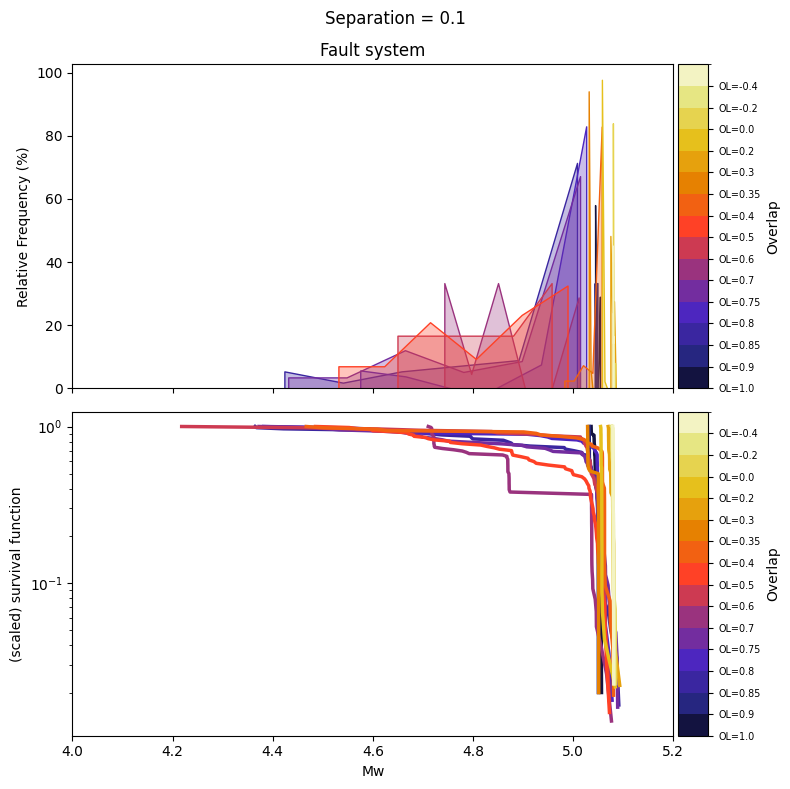

In [53]:
%matplotlib inline
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib

plt.close("all")
matplotlib.rcParams['pdf.fonttype'] = 42 

# Create canvas
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8), squeeze=False,sharey=False, sharex=True)



# Set dy offset



# Labels
lbl1 = "F1"
lbl2 = "F2"
lbl = "System"

dy_values_ =models_dict.copy()
# print(models_dict['mod_1000x_1000y_0z'])

dy_values = {k: v for k, v in models_dict.items() if k != 'mod_def'}

# Extract locations and filter out keys without a complete match
valid_keys = []
locations = []

for key in dy_values.keys():
    match_x = re.search(r'_(\d+)x_', key)
    match_y = re.search(r'_(\d+)y_', key)
    match_z = re.search(r'_(\d+)z', key)

    if match_x and match_y and match_z:
        valid_keys.append(key)
        locations.append([
            int(match_x.group(1)),
            int(match_y.group(1)),
            int(match_z.group(1))
        ])

# Create a mask to filter based on the third element (z-value) being 0
mask = [loc[2] == 0 for loc in locations]

# Filter dy_values based on the mask
dy_values_filtered = {k: dy_values[k] for i, k in enumerate(valid_keys) if mask[i]}

# Also include the filtered locations
dy_values_filtered['location'] = [locations[i] for i in range(len(mask)) if mask[i]]

dy_values = dy_values_filtered



# Assuming `selecty` is the value you want to filter by
selecty = 500  # Replace with your actual value

# Filter dy_values based on the second element (y-value) matching `selecty`
dyvv = {}
filtered_locations = []

for i, (k, v) in enumerate(dy_values.items()):
    if k == 'location':
        continue  # Skip 'location' key in the main filtering loop
    
    # Check if the y-value in the corresponding location matches `selecty`
    if dy_values['location'][i][1] == selecty:
        dyvv[k] = v
        filtered_locations.append(dy_values['location'][i])

# Add the filtered locations to the new dictionary
dyvv['location'] = filtered_locations

valid_keys = []
locations = []

for key in dyvv.keys():
    match_x = re.search(r'_(\d+)x_', key)
    match_y = re.search(r'_(\d+)y_', key)
    match_z = re.search(r'_(\d+)z', key)

    if match_x and match_y and match_z:
        valid_keys.append(key)
        locations.append([
            int(match_x.group(1)),
            int(match_y.group(1)),
            int(match_z.group(1))
        ])

# Create a mask to filter based on the third element (z-value) being 0
dy = [loc[0] for loc in locations]

# Define the number of colors in the palette (excluding the custom colors)
num_colors = len(dy)

# Create the palette using custom_colors and a subset of the seaborn palette
palette = sns.color_palette("CMRmap", num_colors)

#labels
label_list = ["OL=" + str((5000-i)/5000) for i in dy] 

for i, model_name in enumerate(dyvv):
    model_dict = dyvv[model_name]

    # print(model_dict)

    # Assign events to DataFrames
    if 'ev' in model_dict:
        df_ev = model_dict["ev"]
    else:
        print("ev not found")
        print(model_name)
        continue
    
    if i==18:
        df_ev1 = df_ev[1]
        df_ev_system = df_ev1

    if i==19:
        df_ev2 = df_ev[1]
        df_ev_system = df_ev2
    
    if i!=18 and i!=19:
        df_ev1 = df_ev[1]
        df_ev2 = df_ev[2]
        df_ev_system = pd.concat([df_ev1, df_ev2]).reset_index()

    #### Histograms #####
    
        
    # for 2 faults    

    # bins system
    max_sys = max(df_ev_system["Mw"])
    min_sys  = min(df_ev_system[df_ev_system["fault_label"]==2]["Mw"])
    range_sys  = max_sys -min_sys 
    n_sys  = len(df_ev_system[df_ev_system["fault_label"]==2])
    bar_width_sys = range_sys /(2*n_sys**(1/3))
    bins_sys  = np.arange(min_sys, max_sys, bar_width_sys)
    
    # histogram system
    sns.histplot(data=df_ev_system, x='Mw', bins=bins_sys, ax=ax[0,0], fill=True, element="poly",
             color = palette[i], edgecolor=palette[i], alpha=.3, stat="percent")


    #### MFD plots  (survival functions) ####
    # Discrete survival function:
    # For each increment in the observed magnitude, the
    # number of events larger than that magnitude goes
    # down by 1. Divide by N to get a scaled distribution
    # In other words, it's the cumulative distribution normalized by one
    
    b = 1.2    # b-value
    
    
    # for two faults
    obs1 = df_ev1["Mw"]
    obs2 = df_ev2["Mw"]
    obs_system = df_ev_system["Mw"]
    
    N1 = len(obs1)
    N2 = len(obs2)
    N_system = len(obs_system)
    
    # discrete survival function
    obs_sort1 = np.sort(obs1)
    cdf_discrete1 = (np.arange(N1)[::-1] + 1) / N1
    # discrete survival function
    obs_sort2 = np.sort(obs2)
    cdf_discrete2 = (np.arange(N2)[::-1] + 1) / N2    
    # discrete survival function
    obs_sort_system = np.sort(obs_system)
    cdf_discrete_system = (np.arange(N_system)[::-1] + 1) / N_system    

    # Plot results
    # # plot the functions for each fault separately
    sns.lineplot(x=obs_sort_system, y=cdf_discrete_system, ax=ax[1,0], color=palette[i], linewidth = 2.5)

        
# Create a range of x-values (Mw) in log space
x_values = np.logspace(4, 5, 100)  # Adjust the range and number of points as needed

# Compute the corresponding y-values (scaled survival function) using the slope (b)
y_values = np.exp(-b * np.log(x_values))

# for all axes of fig 2
# axi.plot(x_values, y_values, ls=":", c="k", zorder=-1, linewidth=1, label="slope = -b")
# axi.legend()
# axi.set_xscale("log")
ax[1,0].set_yscale("log")
ax[1,0].set_xlabel("Mw")
ax[1,0].set_ylabel("(scaled) survival function")
 
####
# Colorbar
####

## Option 2: Create a custom discrete colormap with a separate color for each label
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

num_labels = len(label_list)
# cmap = sns.color_palette("CMRmap", num_labels)
cmap = palette

# Create a colorbar using a ScalarMappable object with the discrete colormap
norm = mpl.colors.BoundaryNorm(np.arange(num_labels + 1), num_labels)
sm = cm.ScalarMappable(cmap=ListedColormap(cmap), norm=norm)
sm.set_array([])

# Create a colorbar with custom ticks and labels for fig 1

# Create a new subplot for the colorbar
divider = make_axes_locatable(ax[0, 0])
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(sm, cax=cax, ticks=np.arange(num_labels))
cbar.set_label('Overlap')
cbar.ax.set_yticklabels(label_list, fontsize='x-small')

# Adjust the colorbar position
fig.subplots_adjust(right=0.85)

# Create a colorbar with custom ticks and labels for fig 2
divider2 = make_axes_locatable(ax[1,0])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)

cbar2 = plt.colorbar(sm, cax=cax2, ticks=np.arange(num_labels))
cbar2.set_label('Overlap')
cbar2.ax.set_yticklabels(label_list, fontsize='x-small')

# Adjust the colorbar position
fig2.subplots_adjust(right=0.85)

# Set axes properties
ax[0, 0].set_xlabel('Mw')
ax[0, 0].set_ylabel('Relative Frequency (%)')
ax[0, 0].set_xlim(4.0, 5.2)
ax[0, 0].set_title("Fault system")
ax[0, 0].set_yscale("linear") 
# Set axes properties for fig 2
ax[1, 0].set_xlim(4.0, 5.2)

# # Set axes properties for fig 2



fig.suptitle(f"Separation = {selecty / 5000}")

fig.tight_layout()


plt.show()

fig.savefig("GRD_histogram_small_dy_nb.pdf")
fig2.savefig("GRD_scatter_small_dy_nb.pdf")

In [54]:
print(df_p1.columns)
print(df_p1[df_p1.index.isin(['mod_0x_100y_0z','mod_0x_200y_0z','mod_0x_300y_0z','mod_0x_500y_0z'])]['location'],
      df_p1[df_p1.index.isin(['mod_0x_100y_0z','mod_0x_200y_0z','mod_0x_300y_0z','mod_0x_500y_0z'])]['cv'])
print(df_p[df_p.index.isin(['mod_0x_100y_0z','mod_0x_200y_0z','mod_0x_300y_0z','mod_0x_500y_0z'])]['location'],
      df_p[df_p.index.isin(['mod_0x_100y_0z','mod_0x_200y_0z','mod_0x_300y_0z','mod_0x_500y_0z'])]['cv'])
print(df_p2[df_p2.index.isin(['mod_0x_100y_0z','mod_0x_200y_0z','mod_0x_300y_0z','mod_0x_500y_0z'])]['location'],
      df_p2[df_p2.index.isin(['mod_0x_100y_0z','mod_0x_200y_0z','mod_0x_300y_0z','mod_0x_500y_0z'])]['cv'])

Index(['cv', 'location'], dtype='object')
model_name
mod_0x_100y_0z    [0, 100, 0]
mod_0x_200y_0z    [0, 200, 0]
mod_0x_300y_0z    [0, 300, 0]
mod_0x_500y_0z    [0, 500, 0]
Name: location, dtype: object model_name
mod_0x_100y_0z    0.147036
mod_0x_200y_0z    0.198928
mod_0x_300y_0z    0.182387
mod_0x_500y_0z    0.007880
Name: cv, dtype: float64
model_name
mod_0x_100y_0z    [0, 100, 0]
mod_0x_200y_0z    [0, 200, 0]
mod_0x_300y_0z    [0, 300, 0]
mod_0x_500y_0z    [0, 500, 0]
Name: location, dtype: object model_name
mod_0x_100y_0z    0.149209
mod_0x_200y_0z    0.198415
mod_0x_300y_0z    0.184674
mod_0x_500y_0z    0.008974
Name: cv, dtype: float64
model_name
mod_0x_100y_0z    [0, 100, 0]
mod_0x_200y_0z    [0, 200, 0]
mod_0x_300y_0z    [0, 300, 0]
mod_0x_500y_0z    [0, 500, 0]
Name: location, dtype: object model_name
mod_0x_100y_0z    0.154227
mod_0x_200y_0z    0.202344
mod_0x_300y_0z    0.190538
mod_0x_500y_0z    0.010120
Name: cv, dtype: float64


# 8. Nucleation points

## 8.1. Get nucleation points

In [55]:
import numpy as np
import pandas as pd
import os
import sys
import pickle

def nucleation_point(mesh_dict, events_dict, save_output=True):    
    model_dict = events_dict
    
    # create empty dictionary to store nucleation points
    model_dict["np"] = {}
    
    # create an empty dictionary where point frequency and coordinates of nucleation points will be stored
    model_dict["count_np"] = {}
    
    # fault labels
    
    fault_labels = np.unique(mesh_dict["FAULT_LABEL"])
    
    #########################
    #### FOR EACH FAULT #####
    #########################
    for i_f, fault_label in enumerate(fault_labels):

        df_ev_f = model_dict["ev"][fault_label]
        ot_ev_f = model_dict["vmax_ev"][fault_label]
    
        # Create empty data frame where info of nucleation points will be stored
        df_np_f = pd.DataFrame(columns=ot_ev_f.columns)
    
        # number of events in Fault 1
        events_f = df_ev_f.index
    
        # Loop over number of events
        for n_event in events_f:
    
            #Snapshots of one event 
            df_event_f = ot_ev_f[ot_ev_f["n_event"]==n_event]
            df_event_f=df_event_f.reset_index(drop=True) # reset indices to start counting from 0.
    
            # indices of rows with tmin in event
            i_tmin_f = df_event_f.index[df_event_f["t"]==df_event_f["t"].min()]
    
            # row with v max in snapshot with tmin (1st snapshot of the event)
            df_vmax_f = df_event_f.iloc[i_tmin_f][df_event_f.iloc[i_tmin_f]["vmax_fault"] == df_event_f.iloc[i_tmin_f]["vmax_fault"].max()].copy()    
            df_np_f = pd.concat([df_np_f, df_vmax_f])
    
        # reset indices to real event numbers
        df_np_f = df_np_f.reset_index(drop=True)
        df_np_f.index = range(1, len(events_f) + 1)
        df_np_f = df_np_f.rename_axis("n_event")
    
        ## Coordinates of nucleation points 
        # (uses the ivmax from the fault output to search for the coordinates in the mesh_dict array. We have to substract 1 to the index because python starts counting at 0, while fortran starts counting at 1.
        if len(df_np_f)!=0:
            # if the catalog is not empty
            df_np_f["x"] = mesh_dict["X"][(df_np_f["ivmax_fault"].values - 1).astype(int)]
            df_np_f["y"] = mesh_dict["Y"][(df_np_f["ivmax_fault"].values - 1).astype(int)]
            df_np_f["z"] = mesh_dict["Z"][(df_np_f["ivmax_fault"].values - 1).astype(int)]
        else:
            # if catalog is empty
            df_np_f["x"] = np.nan
            df_np_f["y"] = np.nan
            df_np_f["z"] = np.nan
        
        
        ## assign Mw to DataFrame df_np_f
        df_np_f["Mw"] = model_dict["ev"][fault_label]["Mw"]
        
        ## assign Mw to DataFrame df_np_f
        df_np_f["fault_label"] = model_dict["ev"][fault_label]["fault_label"]

        # save nucleation points to dictionary
        model_dict["np"][fault_label] = df_np_f
        
    
        """
        Calculate nucleation point frequency
        """
        
        # series with element coordinates from mesh_dict
        x_coord = mesh_dict["X"]
        y_coord = mesh_dict["Y"]
        z_coord = mesh_dict["Z"]
    
        # Pandas data Frame with coordinates
        coords = pd.DataFrame(list(zip(x_coord, y_coord, z_coord)), columns = ["x", "y", "z"])
        coords["fault_label"] = mesh_dict["FAULT_LABEL"]
        
        # Count of nucleation points fault
        if len(df_np_f)!=0:
            df_count_np_f = df_np_f.value_counts(["x", "y", "z"]).to_frame()
            df_count_np_f = df_count_np_f.reset_index() # convert indices of coordinates x, y and z to columns
            if 'count' in df_count_np_f:
                df_count_np_f.rename({'count':"count_np"}, axis=1, inplace=True) # rename column with frequency of np
            else:
                df_count_np_f.rename({0:"count_np"}, axis=1, inplace=True) # rename column with frequency of np
        else:
            df_count_np_f = pd.DataFrame(columns = ["x", "y", "z", "count_np"])
            df_count_np_f["x"] = np.nan
            df_count_np_f["y"] = np.nan
            df_count_np_f["z"] = np.nan
            df_count_np_f["count_np"] = np.nan

        # row with frequency
        #coords["count_np"] = np.nan
        df_count_np_f["i_np"] = np.nan
    
    
        # Find indices of nucleation points of F1 in the coordinate mesh
        list_i_np_f = [] # empty list where nucleation points of F1 will be stored
        for row in np.arange(0,len(df_count_np_f)):
            i_np_f = coords.index[(coords['x'] == df_count_np_f["x"][row]) & (coords['y'] == df_count_np_f["y"][row]) & (coords['z'] == df_count_np_f["z"][row])].tolist()[0]
            list_i_np_f.append(i_np_f)
            df_count_np_f.loc[row, "i_np"] = int(i_np_f)
    
        # Set indices of nucleation points as index of the DataFrame for F1
        df_count_np_f.index = list_i_np_f
        df_count_np_f.index.name = "i_np"
        
        # create a column with count_np in the DataFrame with coordinates
        coords["count_np"] = pd.Series(dtype=float)
        coords.loc[coords["fault_label"] == fault_label, "count_np"] = df_count_np_f["count_np"]
        
        # DataFrame with coordinates of one individual fault
        coords_f = coords[coords["fault_label"]==fault_label].copy().reset_index(drop=True)
    
        # save DataFrame in dictionary
        
        model_dict["count_np"][fault_label] = coords_f
        

        if save_output:
            output_dict = model_dict
            # create a binary pickle file (output file)
            f = open("count_np.pkl","wb")
            # write the python object (dict) to pickle file
            pickle.dump(output_dict,f)
            
             # close file
            f.close()
    
    return model_dict

In [56]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

"""
Calculate nucleation point of each event as location where the highest slip rate occurs in the first timestep of each event
"""
%reload_ext autoreload
%autoreload 2

# from qdyn.utils.post_processing.nucleation_point import nucleation_point as nucleation_point


for model_name in models_dict:

    events = compute_events(models_dict[model_name]["set_dict"], 
                                   models_dict[model_name]["mesh_dict"], 
                                   models_dict[model_name]["ot_fault"], 
                                   vmax=0.01,tmin=100,tmax=2000, 
                                   save_output=False)

    # get nucleation points

    mesh = models_dict[model_name]["mesh_dict"]
    model_dict_np = nucleation_point(mesh,
                                     events, 
                                     save_output=False)
    # store results in dictionary
    models_dict[model_name]["np"] = model_dict_np["np"]
    models_dict[model_name]["count_np"] = model_dict_np["count_np"]

## 8.2. Plot nucleation points in 2D

-4285.695614639835 -4924.5668141529295


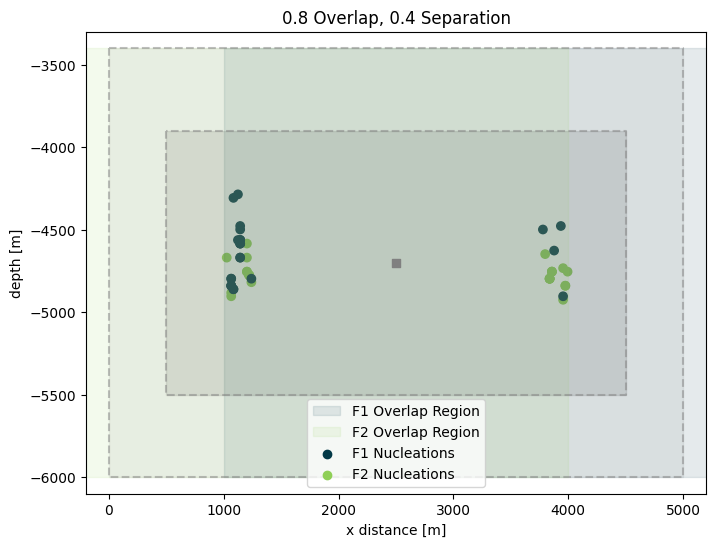

In [67]:
np_dict = models_dict.copy()

for model_name in np_dict:
    if model_name != 'mod_def':
        np_dict[model_name]['FX'] = int(re.search(r'_(\d+)x_', model_name).group(1))
        np_dict[model_name]['FY'] = int(re.search(r'_(\d+)y_', model_name).group(1))
        np_dict[model_name]['FZ'] = int(re.search(r'_(\d+)z', model_name).group(1))

selection = 'mod_1000x_2000y_0z'
xoffset = np_dict[selection]['FX']
yoffset = np_dict[selection]['FY']

fig, ax = plt.subplots(figsize=(8,6))

for model_name in np_dict:
    if model_name == selection: 
        data = np_dict[model_name]
        if data['FZ'] == 0:
            ax.scatter(2500, -4700, color="grey",zorder=5,marker='s')
            
            npdata = pd.concat([data["np"][1], data["np"][2]])
            np1data = data["np"][1]
            np2data = data["np"][2]

            npdata["x"] = np.where(npdata["fault_label"] == 2, npdata["x"] - data['FX'],
                                   npdata["x"])
            npdata["z"] = np.where(npdata["fault_label"] == 2, npdata["z"] - data['FZ'],
                                   npdata["z"])

            print(npdata["z"].max(), npdata["z"].min())
            
            colors = np.where(npdata["fault_label"] == 2, "#023947", "#8ecf56")
            
            ax.scatter(npdata["x"] , npdata["z"] , c=colors)
            
            # sns.kdeplot(x= npdata[npdata["fault_label"] == 1]["x"] / 10 + data['FX'] - 250,y= npdata[npdata["fault_label"] == 1]["y"] / 10 + data['FY'] - 75,ax=ax,
            #             color=f'C0',fill=True,alpha=0.3, warn_singular=False)
            # sns.kdeplot(x= npdata[npdata["fault_label"] == 2]["x"] / 10 + data['FX'] - 250,y= npdata[npdata["fault_label"] == 2]["y"] / 10 + data['FY'] - 75,ax=ax,
            #             color=f'C1',fill=True,alpha=0.3, warn_singular=False)
            sizex = 200
            sizey = 30
            ax.plot([0,0,5000,5000,0],
                    [-3400,-6000,-6000,-3400,-3400],
                    ls='--',alpha=0.5,color='grey')

            ax.plot([500,500,4500,4500,500],
                    [-3900,-5500,-5500,-3900,-3900],
                    ls='--',alpha=0.5,color='grey')

            ax.fill([0,0,5000,5000,0],
                    [-3400,-6000,-6000,-3400,-3400],
                    alpha=0.1,color='grey')

            ax.fill([500,500,4500,4500,500],
                    [-3900,-5500,-5500,-3900,-3900],
                    alpha=0.2,color='grey')
            
            # for i in range(len(npdata)):
            #     ax.plot([2500, npdata["x"].iloc[i]],
            #             [-4700, npdata["z"].iloc[i]],
            #             color=colors[i],zorder=0.9)

ax.fill_between([xoffset,6500],[-3400,-3400],[-6000,-6000],color="#023947",alpha=0.1, label='F1 Overlap Region')
ax.fill_between([-500,5000-xoffset],[-3400,-3400],[-6000,-6000],color="#8ecf56",alpha=0.1, label='F2 Overlap Region')


ax.scatter(10000,10000,c='#023947',label='F1 Nucleations')
ax.scatter(10000,10000,c='#8ecf56',label='F2 Nucleations')


ax.set_ylim(-6100, -3300)
ax.set_xlim(-200,5200)

ax.set_title(f"{(5000 - xoffset)/5000} Overlap, {yoffset/5000} Separation")

ax.legend(loc='lower center')

# ax.set_xticks([])
# ax.set_yticks([])

ax.set_xlabel("x distance [m]")
ax.set_ylabel("depth [m]")

plt.show()

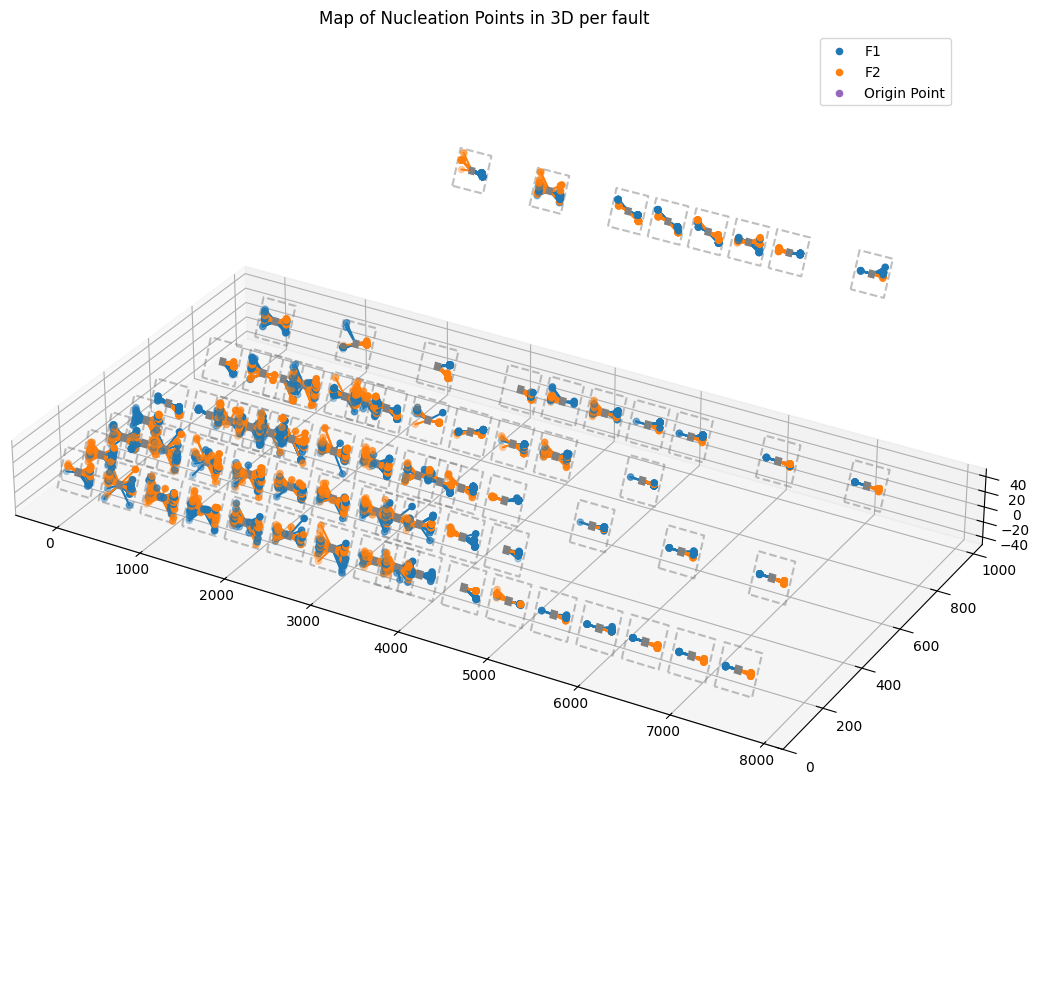

In [58]:
# the same but in 3D? worth a shot!
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import seaborn as sns

np_dict = models_dict.copy()

for model_name in np_dict:
    if model_name != 'mod_def':
        np_dict[model_name]['FX'] = int(re.search(r'_(\d+)x_', model_name).group(1))
        np_dict[model_name]['FY'] = int(re.search(r'_(\d+)y_', model_name).group(1))
        np_dict[model_name]['FZ'] = int(re.search(r'_(\d+)z', model_name).group(1))

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect((10,5,1))

for model_name in np_dict:
    if model_name != "mod_def": 
        data = np_dict[model_name]
        if data['FZ'] == 0:
            npdata = pd.concat([data["np"][1], data["np"][2]])
            np1data = data["np"][1]
            np2data = data["np"][2]

            npdata["x"] = np.where(npdata["fault_label"] == 2, npdata["x"] - data['FX'],
                                   npdata["x"])
            npdata["y"] = np.where(npdata["fault_label"] == 2, npdata["y"] - data['FY'],
                                   npdata["y"])
            npdata["z"] = np.where(npdata["fault_label"] == 2, npdata["z"] - data['FZ'],
                                   npdata["z"])
            
            colors = np.where(npdata["fault_label"] == 2, "C1", "C0")
            
            ax.scatter(npdata["x"] / 10 + data['FX'] - 250, (npdata["y"] / 10)/2 + data['FY'] - 37.5, (npdata["z"] / 10 + data['FZ']+470) / 2, c=colors)
            
            # sns.kdeplot(x= npdata[npdata["fault_label"] == 1]["x"] / 10 + data['FX'] - 250,y= npdata[npdata["fault_label"] == 1]["y"] / 10 + data['FY'] - 75,ax=ax,
            #             color=f'C0',fill=True,alpha=0.3, warn_singular=False)
            # sns.kdeplot(x= npdata[npdata["fault_label"] == 2]["x"] / 10 + data['FX'] - 250,y= npdata[npdata["fault_label"] == 2]["y"] / 10 + data['FY'] - 75,ax=ax,
            #             color=f'C1',fill=True,alpha=0.3, warn_singular=False)
            sizex = 200
            sizey = 22.5
            sizez = 22.5
            ax.plot([data['FX'] - sizex, data['FX'] - sizex, data['FX'] + sizex, data['FX'] + sizex,data['FX'] - sizex],
                    [data['FY'] - sizey, data['FY'] + sizey, data['FY'] + sizey, data['FY'] - sizey,data['FY'] - sizey],
                    [data['FZ'] - sizez, data['FZ'] + sizez, data['FZ'] + sizez, data['FZ'] - sizez,data['FZ'] - sizez],
                    ls='--',alpha=0.5,color='grey')
            
            for i in range(len(npdata)):
                ax.plot([data['FX'], npdata["x"].iloc[i] / 10 + data['FX'] - 250],
                        [data['FY'], (npdata["y"].iloc[i] / 10)/2 + data['FY'] - 37.5],
                        [data['FZ'],  (npdata["z"].iloc[i] / 10 + data['FZ']+470) / 2],
                        color=colors[i])

            FX = data['FX']
            FY = data['FY']
            FZ = data['FZ']
            
            vertices = [
                        [FX - sizex / 5, FY - sizey / 5, FZ - sizez / 5],
                        [FX - sizex / 5, FY + sizey / 5, FZ + sizez / 5],
                        [FX + sizex / 5, FY + sizey / 5, FZ + sizez / 5],
                        [FX + sizex / 5, FY - sizey / 5, FZ - sizez / 5]
            ]
            
            # Create the polygon and add it to the plot
            polygon = Poly3DCollection([vertices], alpha=1.0, facecolor='grey', edgecolor='none')
            ax.add_collection3d(polygon)

ax.set_title("Map of Nucleation Points in 3D per fault")

ax.scatter([10000],[10000],[10000],label="F1",color=f"C0")
ax.scatter([10000],[10000],[10000],label="F2",color=f"C1")
ax.scatter([10000],[10000],[10000],label="Origin Point",color=f"C4")

ax.legend()

ax.set_xlim(-500,8200)
ax.set_ylim(0,1050)
ax.set_zlim(-50,50)

# ax.view_init(elev=0, azim=0, roll=0)
fig.tight_layout()
plt.show()

In [59]:
raise SystemExit("Stop here")

SystemExit: Stop here

/work/e820/e820/willpizii/QENV/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
def compute_slow_events(set_dict, mesh_dict, ot_fault, vmax=0.01,vmin=1e-6,vmin_stop=1e-8,tmin=0,tmax=None, save_output=False):
   
    """
    INITIAL PARAMETERS
    """

    # Predefine parameters
    t_yr = 3600 * 24 * 365.0    # Seconds per year

    # # Instantiate the QDYN class object
    # p = qdyn()


    """
    OPEN OUTPUTS
    """

    # Create empty dictionary where DataFrames of outputs will be stored
    model_dict={}

    #  assign dictionary with settings of meshdict to dictionary storing models
    model_dict["mesh_dict"] = mesh_dict

    #  assign dictionary with settings of meshdict to dictionary storing models
    model_dict["set_dict"] = set_dict

    """
    COMPUTE EVENT QUANTITIES
    To compute the quantities per events we will work with the output output_fault. 
    First we have to extract the time-steps with seismic events for each fault. 
    To do so, we use the output file output_fault to identify the time-steps 
    where the element with highest slip rate exceeds a given threshold, in this case 0.01m/s.
    This way we obtain the initial and final times of each event.
    Then we use the output_fault to calculate the slip and potency per event
    the interevent time within each fault, and the Mw.
    We also extract the peak velocity and its corresponding time and the time interval of the event
    Finally, if working with multiple faults we calculate the interevent time between faults
    (called t_interevent_interfault)
    """

    # empty dictionary to store events    
    model_dict["ev"] = {} # store information events
    model_dict["seq"] = {} # store information of sequences of events
    model_dict["vmax_ev"] = {} # store information of vmax of events

    # fault labels
    fault_labels = np.unique(model_dict["mesh_dict"]["FAULT_LABEL"])

    #########################
    #### FOR EACH FAULT #####
    #########################
    ### Events have to be calculated separately for each fault ###

    for i_f, fault_label in enumerate(fault_labels):

        # filter timesteps with velocity and time threshold in DataFrame output ot_fault
        def filter_n_shape_segments(df, vmin, vmax, tmin, tmax=None, t_yr=t_yr):
            # Convert time bounds to the appropriate units
            tmin *= t_yr
            if tmax is not None:
                tmax *= t_yr
        
            # Filter based on vmax_fault and t
            filtered_df = df[
                (df["t"] >= tmin) & 
                (df["t"] <= (tmax if tmax is not None else df["t"].max()))
            ]
        
            # Ensure data is sorted by time
            filtered_df = filtered_df.sort_values(by="t")
        
            # Identify segments where data stays between vmin and vmax
            valid_segments = []
            segment_start = None
            exceeded_vmax = False
            vmax_lat = False
            last_row = filtered_df.iloc[0]
            
            for i, row in filtered_df.iterrows():
                if row["vmax_fault"] >= vmax:
                    exceeded_vmax=True

                if row["vmax_fault"] <= vmin_stop:
                    exceeded_vmax=False
                
                if segment_start is None and exceeded_vmax == False:
                    # Check if the segment can start
                    if vmin <= row["vmax_fault"] <= vmax:
                        segment_start = i
                else:
                    # Check if the segment should end
                    if exceeded_vmax:
                        segment_start = None  # Invalid segment, reset start
                    elif row["vmax_fault"] < vmin_stop:
                        # Segment ends because it dropped below vmin
                        if not exceeded_vmax:
                            # Capture segment if it didn't exceed vmax
                            segment = filtered_df.loc[segment_start:i].copy()
                            segment['dt'] = segment['t'].iloc[-1] - segment['t'].iloc[0]
                            valid_segments.append(segment)
                        segment_start = None  # Reset start after capturing segment
                
        
            # Add the last segment if it was valid
            if segment_start is not None:
                segment = filtered_df.loc[segment_start:]
                if not segment["vmax_fault"].gt(vmax).any():
                    valid_segments.append(segment)
        
            # print([segment["vmax_fault"].max() for segment in valid_segments])
            # Combine all valid segments
            if valid_segments:
                result_df = pd.concat(valid_segments)
                return result_df
            else:
                return pd.DataFrame(columns=filtered_df.columns)  # Return an empty DataFrame if no valid segments

        ot_ev_f = filter_n_shape_segments(ot_fault[i_f], vmin, vmax, tmin, tmax=tmax, t_yr=t_yr)
        # Number of elements individual Fault
        n_f = len(model_dict["mesh_dict"]["FAULT_LABEL"][model_dict["mesh_dict"]["FAULT_LABEL"]==fault_label])

        # Calculate the time difference between previous and following time-step
        ot_ev_f["deltat"] = ot_ev_f['t'].diff()

        # calculate the number of event for each row (one event is considered independent if it occurs >1yr after the previous time-step)
        ot_ev_f["n_event"] = (ot_ev_f["deltat"] >=1).cumsum() + 3600 * 24 * 365

        # Group rows of vmax DataFrame by event number
        vmax_ev_f = ot_ev_f.groupby("n_event")

        # approach 1: Filter time-steps of fault outputs where there are seismic events

        ### calculate CUMULATIVE SLIP per fault per timestep ###

        ## 1st calculate fault area
        # get fault labels
        fault_lbl = model_dict["mesh_dict"]["FAULT_LABEL"]

        # Create a boolean mask to identify the positions where fault_labels == fault_label
        mask = fault_lbl == fault_label

        # Use the mask to select the corresponding Z values
        z_values = model_dict["mesh_dict"]["Z"][mask]

        # calculate fault distance along z
        Dz = max(z_values) - min(z_values)

        # extract dip
        dip = model_dict["mesh_dict"]["DIP_W"][0]

        # calculate width along dip (without half lengths first)
        Dw = Dz / np.cos(np.radians(dip))

        # Access the "DW" values from the mesh_dict for the specified model_name to get the half length of top and bottom elements
        dw_values = model_dict["mesh_dict"]["DW"][mask]

        # calculate half length of top and bottom elements
        half_dw_bottom  = dw_values[0]/2
        half_dw_top  = dw_values[-1]/2

        # calculate width along dip
        Dw = Dw + half_dw_bottom + half_dw_top

        # # Use the mask to select the corresponding X values
        x_values = model_dict["mesh_dict"]["X"][mask]

        # calculate fault distance along z
        Dx = max(x_values) - min(x_values)

        # array with unique x coordinates
        x_unique = np.unique(x_values)

        # calculate half length of right and left elements
        half_dx_right = x_unique[1] - x_unique[0]
        half_dx_left = x_unique[-1] - x_unique[-2]

        # calculate length along strike
        Dx = Dx + half_dx_right + half_dx_left

        # calculate area
        area1 = Dx*Dw

        ## calculate cumulative slip per fault (this is slip since t0)
        ot_ev_f["cum_slip_fault"] = ot_ev_f["potcy_fault"] / area1

        ### end calculation cumulative slip per fault ###

        # calculate the time difference between previous and following time-step
        ot_ev_f["deltat"] = ot_ev_f['t'].diff()

        # calculate the number of event for each row (one event is considered independent if it occurs >1yr(!) after the previous time-step)
        ot_ev_f["n_event"] = (ot_ev_f["deltat"] >=1).cumsum() + 1

        # group rows of fault DataFrame by number of event
        ev_f = ot_ev_f.groupby("n_event")

        # Calculate start and end time of each event
        df_ev_f = ev_f["t"].agg(["min", "max"]) # calculate start and end time of event and create DataFrame with values
        df_ev_f = df_ev_f.rename(columns={"min": "min_t", "max": "max_t"}) # rename columns
        df_ev_f = df_ev_f.reindex(columns=['min_t', 'max_t']) # reorder columns

        ## Calculate cumulative slip of each event
        #df_ev1["cum_slip"] = ev1["slip_dt_fault"].sum()/n_f1 # old wrapper
        # extract the index corresponding to the max and min time of each event
        idx_t_max_f = ev_f["t"].idxmax()
        idx_t_min_f = ev_f["t"].idxmin()

        # Calculate cumulative slip of each event (as the substraction between time-step at tmax and tmin)
        df_ev_f["cum_slip"] = (ot_ev_f.loc[idx_t_max_f, 'cum_slip_fault'].reset_index(drop=True) - ot_ev_f.loc[idx_t_min_f, 'cum_slip_fault'].reset_index(drop=True)).values

        # Calculate cumulative potency of each event
        # df_ev1["cum_potency"] = ev1["potcy_fault"].sum() # old wrapper
        df_ev_f["cum_potency"] = (ot_ev_f.loc[idx_t_max_f, 'potcy_fault'].reset_index(drop=True) - ot_ev_f.loc[idx_t_min_f, 'potcy_fault'].reset_index(drop=True)).values

        # Calculate peak velocity for each event
        v_event_f = ot_ev_f["vmax_fault"].loc[ot_ev_f.groupby("n_event").vmax_fault.idxmax()]
        v_event_f.index = df_ev_f.index.to_list()
        df_ev_f["peak_v"] = v_event_f

        # Calculate duration of each event
        df_ev_f["dt_event"] = df_ev_f["max_t"] - df_ev_f["min_t"]

        # Calculate time of event based on the time of occurence of the max peak velocity
        t_event_f = ot_ev_f["t"].loc[ot_ev_f.groupby("n_event").vmax_fault.idxmax()] # find the time-step where the peak velocity occurs for each event
        t_event_f.index = df_ev_f.index.to_list() # rename the indices so they match the number of event
        df_ev_f["t_event"] = t_event_f # add the column to the DataFrame storing the information about the events

        # Calculate interevent-time within fault (recurrence time)
        df_ev_f["t_interevent_intrafault"] = df_ev_f['max_t'] - df_ev_f['min_t'].shift(1)

        """
        MAGNITUDE
        """

        """
        Calculate seismic moment and moment magnitude for each event
        """
        G = model_dict["set_dict"]["MU"] # shear modulus

        # Calculate seismic moment Mo of each event in the fault as P*G
        Mo_f = df_ev_f["cum_potency"]*G
        Mo_f=Mo_f.rename("Mo") # rename Series

        # Calculate moment magnitude Mw as 2/3*np.log10(Mo1) - 6.06

        # Assign Mw to column in event DataFrame 
        df_ev_f["Mw"] = Mo_f

        ## end magnitude calculation ##

        # assign fault label to Dataframe with events
        df_ev_f["fault_label"] = fault_label

        # save events information in a DataFrame that can be accessed through the fault label
        model_dict["ev"][fault_label] = df_ev_f
        model_dict["vmax_ev"][fault_label] = ot_ev_f

    #########################################
    #### INTEREVENT TIME BETWEEN FAULTS #####
    #########################################
    # Get the list of keys in model_dict["ev"]
    keys = list(model_dict["ev"].keys())

    # Do not consider the simulation case with only 1 fault

    if (len(keys) != 1):    
        # Iterate over each pair of entries
        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                # Concatenate DataFrames of events
                df_ev = pd.concat([model_dict["ev"][keys[i]], model_dict["ev"][keys[j]]], axis=0)

                # Reorder dataframe according to min_t of events
                df_ev = df_ev.sort_values(by="min_t")

                # Define "sequences" that group consecutive events corresponding to one fault
                df_ev["seq"] = (df_ev["fault_label"] != df_ev["fault_label"].shift(1)).cumsum()
                seq = df_ev.groupby("seq") # group events by the sequences

                df_seq = seq["t_event"].agg(["min", "max"]) # calculate start and end time of each sequence and create DataFrame with values
                df_seq = df_seq.rename(columns={"min": "min_t", "max": "max_t"}) # rename columns
                df_seq = df_seq.reindex(columns=['min_t', 'max_t']) # reorder columns
                df_seq["t_interevent_interfault"] = df_seq['min_t'] - df_seq['min_t'].shift(1) # calculate interevent time between faults

                # Save the result in the model_dict["seq"] dictionary with appropriate key
                model_dict["seq"][f"{keys[i]}_{keys[j]}"] = df_seq

    ######################
    #### SAVE OUTPUT #####
    ######################
    # save relevant entries to binary pkl file
    # Get the relevant keys and values from p.model_dict
    if (len(keys) != 1): 
        output_keys = ["ev", "vmax_ev", "seq"]
    else:
        output_keys = ["ev", "vmax_ev"]

    output_dict = {key: model_dict[key] for key in output_keys}

    if save_output:
        # create a binary pickle file (output file)
            f = open("events.pkl","wb")
            # write the python object (dict) to pickle file
            pickle.dump(output_dict,f)
        
            # close file
            f.close()
    return model_dict

In [ ]:
# from qdyn.utils.post_processing.compute_events import compute_events

print("This is slow!")

key_list = list(models_dict)

for i, model_name in enumerate(key_list):
    # empty dictionary to store events    
    models_dict[model_name]["slow_ev"] = {} 
    models_dict[model_name]["slow_seq"] = {} 
    models_dict[model_name]["slow_vmax_ev"] = {}
    
    # get catalog
    model_dict_ev = compute_slow_events(models_dict[model_name]["set_dict"], 
                                   models_dict[model_name]["mesh_dict"], 
                                   models_dict[model_name]["ot_fault"], 
                                   vmax=1e-3, vmin=1e-6, vmin_stop=1e-9,tmin=100,tmax=2000, 
                                   save_output=False)
    
    # save quantities in dictionary
    models_dict[model_name]["slow_ev"] = model_dict_ev["ev"]
    models_dict[model_name]["slow_vmax_ev"] = model_dict_ev["vmax_ev"]
    
    if os.path.basename(model_name)!="mod_def" and os.path.basename(model_name)!="mod_cone":
        # Exclude seq in models with individual faults F1 and F2
        models_dict[model_name]["slow_seq"] = model_dict_ev["seq"]
    
    # remove events where cum_potency = 0
    models_dict[model_name]["slow_ev"][1] =  models_dict[model_name]["slow_ev"][1].drop(
        models_dict[model_name]["slow_ev"][1][models_dict[model_name]["slow_ev"][1]["cum_potency"] <= 0].index)
    
    if os.path.basename(model_name)!="mod_def" and os.path.basename(model_name)!="mod_cone":
        models_dict[model_name]["slow_ev"][2] =  models_dict[model_name]["slow_ev"][2].drop(
            models_dict[model_name]["slow_ev"][2][models_dict[model_name]["slow_ev"][2]["cum_potency"] <= 0].index)

    print(f"finished computing {model_name}")



In [ ]:
# ###########
# #For events
# ###########

### Add columns with dy offset to the event DataFrames

# array of y offsets (the value of 1 fault was set to 10000 and the value of  fault 2 was set to 1000000)
dvar = [[int(re.search(r'_(\d+)x_', name).group(1)),int(re.search(r'_(\d+)y_', name).group(1)),int(re.search(r'_(\d+)z', name).group(1))]
      for name in models_dict if name != 'mod_def'] + [[100000, 100000, 100000]]

for i, model_dict in enumerate(models_dict.values()):
    
    # Get the "ev" DataFrame from the current model_dict
    ev_df = model_dict["slow_ev"]

    print(dvar[i])
    # Add a new column "dy" to the "ev" DataFrame with the corresponding value from dy
    ev_df[1]["dx"] = dvar[i][0] # for Fault 1
    ev_df[1]["dy"] = dvar[i][1]
    ev_df[1]["dz"] = dvar[i][2]
    
    # apply to all models except model with 1 fault (model n19 and n20, index i starts at 0)
    if 2 in ev_df:
        ev_df[2]["dx"] = dvar[i][0] # for Fault 1
        ev_df[2]["dy"] = dvar[i][1]
        ev_df[2]["dz"] = dvar[i][2]
    
    # Update the "ev" DataFrame in the current model_dict with the new "dy" column
    model_dict["slow_ev"] = ev_df
    
# Combine the data from all the DataFrames into a single DataFrame
n = len(models_dict)

df1 = pd.concat([model_dict["slow_ev"][1].assign(model_name=model_name) for model_name, model_dict in list(models_dict.items())])
# For fault 2, exclude the penultimate item (model 1 fault F1) from the dictionary
df2 = pd.concat([model_dict["slow_ev"][2].assign(model_name=model_name)
                 for model_name, model_dict in list(models_dict.items())
                 if 2 in model_dict["slow_ev"]])

# # Join DataFrames
slow_df_ev_all = pd.concat([df1,df2])

slow_df_ev_all.to_csv("slow_events.txt", sep=" ", index=False)
    
###############
# For sequences
###############

# array of yx offsets
dx_seq = [int(re.search(r'_(\d+)x_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dy_seq = [int(re.search(r'_(\d+)y_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dz_seq = [int(re.search(r'_(\d+)z', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]

for i, model_dict in enumerate(models_dict.values()):
    if 'slow_seq' in model_dict:
        # Get the "seq" DataFrame from the current model_dict
        seq_df = model_dict["slow_seq"]

        # Add a new column "dy" to the "seq" DataFrame with the corresponding value from dy
        if '1_2' in seq_df:
            seq_df['1_2']["dx"] = dvar[i][0] # for Fault 1
            seq_df['1_2']["dy"] = dvar[i][1]
            seq_df['1_2']["dz"] = dvar[i][2]

        # Update the "seq" DataFrame in the current model_dict with the new "dy" column
        model_dict["slow_seq"] = seq_df

slow_df_seq = pd.concat([model_dict["slow_seq"]["1_2"].assign(model_name=model_name) for model_name, model_dict in list(models_dict.items())
                    if '1_2' in model_dict['slow_seq']])

slow_df_seq.to_csv("slow_sequences.txt", sep=" ", index=False)

In [ ]:
## Attempt to plot the amount of partial vs full ruptures - by using the Mw as a (valid) proxy
threshold = 0. # adjustable threshold for what is considered a 'full' rupture magnitude

grouped = slow_df_seq.groupby("model_name")

display(slow_df_seq.head())

def count_above_threshold(group, threshold):
    return (group['dy'] > threshold).sum()
def count_below_threshold(group, threshold):
    return (group['dy'] < threshold).sum()

above = grouped.apply(lambda x: count_above_threshold(x, threshold))
below = grouped.apply(lambda x: count_below_threshold(x, threshold))

# Apply the function to each group
high_mag = pd.DataFrame(above, columns=["count"])
low_mag = pd.DataFrame(below, columns=["count"])

# Compute sum_mag
sum_mag = pd.DataFrame(index=high_mag.index)
sum_mag['count'] = high_mag['count'] + low_mag['count']

sm = sum_mag[:].copy()
sm['location'] = [[] for _ in range(len(sm))]
sm['location'] = sm.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = sm['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
sm = sm[mask]

print(sm)

fig = plt.figure(figsize=(5,5))

ax2 = fig.add_subplot(111)

sc = ax2.scatter(np.array(sm['location'].apply(lambda loc: loc[0])),
           np.array(sm['location'].apply(lambda loc: loc[1])),
           s=sm['count'],c=sm['count'], cmap='viridis')

ax2.set_xlabel("x offset [m]")

ax2.set_title("Slow Events")

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('plasma')

norm = mcolors.Normalize(vmin=sm['count'].max(), vmax=sm['count'].min())
cmap = plt.get_cmap('viridis')

cax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='vertical')
cbar.set_label('Number of events')

plt.suptitle("")

from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap('plasma')(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

cls2 = plt.get_cmap('viridis')(np.linspace(0,1,256))
cls2 = (1-alpha) + alpha*cls2
cmap2 = ListedColormap(cls2)
ax2c = ax2.tripcolor(np.array(sm['location'].apply(lambda loc: loc[0])),
               np.array(sm['location'].apply(lambda loc: loc[1])),
               np.array(sm['count']), cmap=cmap2, antialiased=True, shading='gouraud', edgecolors='none', zorder=0.1)


ax2.set_ylim([0,2100])


ax2.set_xlim([-500,8000])

ax2.set_yticks([0,200,400,600,800,1000],[])

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=4)
labels = [int(label.split('{')[1].split('}')[0]) for label in labels]  # Extract numeric part
labels = [label for label in labels]  # Adjust labels
legend = ax0.legend(handles, labels, loc="lower right", title="Number of Events")

plt.show()

In [ ]:
# ###########
# #For events
# ###########

### Add columns with dy offset to the event DataFrames

# array of y offsets (the value of 1 fault was set to 10000 and the value of  fault 2 was set to 1000000)
dvar = [[int(re.search(r'_(\d+)x_', name).group(1)),int(re.search(r'_(\d+)y_', name).group(1)),int(re.search(r'_(\d+)z', name).group(1))]
      for name in models_dict if name != 'mod_def'] + [[100000, 100000, 100000]]

for i, model_dict in enumerate(models_dict.values()):
    
    # Get the "ev" DataFrame from the current model_dict
    ev_df = model_dict["slow_vmax_ev"]

    print(dvar[i])
    # Add a new column "dy" to the "ev" DataFrame with the corresponding value from dy
    ev_df[1]["dx"] = dvar[i][0] # for Fault 1
    ev_df[1]["dy"] = dvar[i][1]
    ev_df[1]["dz"] = dvar[i][2]
    
    # apply to all models except model with 1 fault (model n19 and n20, index i starts at 0)
    if 2 in ev_df:
        ev_df[2]["dx"] = dvar[i][0] # for Fault 1
        ev_df[2]["dy"] = dvar[i][1]
        ev_df[2]["dz"] = dvar[i][2]
    
    # Update the "ev" DataFrame in the current model_dict with the new "dy" column
    model_dict["slow_vmax_ev"] = ev_df
    
# Combine the data from all the DataFrames into a single DataFrame
n = len(models_dict)

df1 = pd.concat([model_dict["slow_vmax_ev"][1].assign(model_name=model_name) for model_name, model_dict in list(models_dict.items())])
# For fault 2, exclude the penultimate item (model 1 fault F1) from the dictionary
df2 = pd.concat([model_dict["slow_vmax_ev"][2].assign(model_name=model_name)
                 for model_name, model_dict in list(models_dict.items())
                 if 2 in model_dict["slow_vmax_ev"]])

# # Join DataFrames
slow_df_ev_all = pd.concat([df1,df2])

slow_df_ev_all.to_csv("slow_vmax_events.txt", sep=" ", index=False)
    
###############
# For sequences
###############

# array of yx offsets
dx_seq = [int(re.search(r'_(\d+)x_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dy_seq = [int(re.search(r'_(\d+)y_', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]
dz_seq = [int(re.search(r'_(\d+)z', name).group(1))
          for name in models_dict if name != 'mod_def'] + [100000]

for i, model_dict in enumerate(models_dict.values()):
    if 'slow_seq' in model_dict:
        # Get the "seq" DataFrame from the current model_dict
        seq_df = model_dict["slow_seq"]

        # Add a new column "dy" to the "seq" DataFrame with the corresponding value from dy
        if '1_2' in seq_df:
            seq_df['1_2']["dx"] = dvar[i][0] # for Fault 1
            seq_df['1_2']["dy"] = dvar[i][1]
            seq_df['1_2']["dz"] = dvar[i][2]

        # Update the "seq" DataFrame in the current model_dict with the new "dy" column
        model_dict["slow_seq"] = seq_df

slow_df_seq = pd.concat([model_dict["slow_seq"]["1_2"].assign(model_name=model_name) for model_name, model_dict in list(models_dict.items())
                    if '1_2' in model_dict['slow_seq']])

slow_df_seq.to_csv("slow_sequences.txt", sep=" ", index=False)

min_t         max_t  t_interevent_interfault   dx   dy  dz  \
0  1.766518e+10  5.042962e+10                      NaN    0  100   0   
1  5.157340e+10  5.157535e+10             3.390822e+10    0  100   0   
2  5.975942e+09  7.409660e+09                      NaN  500  100   0   
3  9.932799e+09  9.951222e+09             3.956858e+09  500  100   0   
4  1.317391e+10  1.792003e+10             3.241112e+09  500  100   0   

         model_name  
0    mod_0x_100y_0z  
1    mod_0x_100y_0z  
2  mod_500x_100y_0z  
3  mod_500x_100y_0z  
4  mod_500x_100y_0z

                      count
model_name                 
mod_0x_100y_0z            5
mod_1000x_100y_0z        11
mod_1000x_300y_0z         4
mod_1000x_500y_0z         4
mod_1000x_750y_0z         1
mod_1250x_500y_0z         9
mod_1500x_100y_0z         8
mod_1500x_300y_0z         5
mod_1500x_500y_0z         1
mod_2000x_100y_0z        10
mod_2000x_300y_0z         4
mod_2000x_500y_0z         4
mod_2500x_100y_0z        12
mod_2500x_100y_1500z      2
mod_2500x_300y_0z         3
mod_3000x_100y_0z        18
mod_3000x_300y_0z         1
mod_3250x_300y_0z         2
mod_3500x_100y_0z        10
mod_3750x_100y_0z         3
mod_500x_100y_0z          9
mod_500x_300y_0z          6
mod_750x_500y_0z          5
                   count        location
model_name                              
mod_0x_100y_0z         5     [0, 100, 0]
mod_1000x_100y_0z     11  [1000, 100, 0]
mod_1000x_300y_0z      4  [1000, 300, 0]
mod_1000x_500y_0z      4  [1000, 500, 0]
mod_1000x_750y_0z      1  [1000, 750, 0]
mod_1250x_500

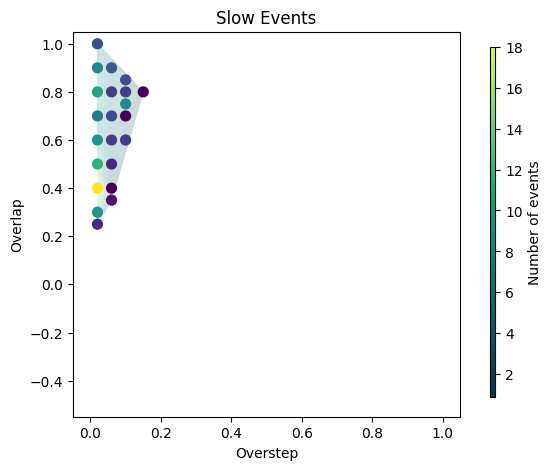

In [155]:
## Attempt to plot the amount of partial vs full ruptures - by using the Mw as a (valid) proxy
threshold = 0. # adjustable threshold for what is considered a 'full' rupture magnitude


slow_df_ev_all = pd.read_csv("slow_vmax_events.txt", sep=" ")
grouped = slow_df_ev_all.groupby("model_name")

slow_df_seq = pd.read_csv("slow_sequences.txt", sep=" ")

display(slow_df_seq.head())

def unique_dt(group):
    return len((group['dt']).unique())

unique = grouped.apply(lambda x: unique_dt(x))

# Apply the function to each group
sum_mag = pd.DataFrame(unique, columns=["count"])

print(sum_mag)

sm = sum_mag[:].copy()
sm['location'] = [[] for _ in range(len(sm))]
sm['location'] = sm.index.to_series().apply(lambda name: [
                                                                    int(re.search(r'_(\d+)x_', name).group(1)),
                                                                    int(re.search(r'_(\d+)y_', name).group(1)),
                                                                    int(re.search(r'_(\d+)z', name).group(1))
                                                                ])

mask = sm['location'].apply(lambda loc: loc[2] == 0 if len(loc) == 3 else False)
sm = sm[mask]

print(sm)

fig = plt.figure(figsize=(5,5))

ax2 = fig.add_subplot(111)

sc = ax2.scatter(np.array(sm['location'].apply(lambda loc: loc[1])) / 5000,(5000 - np.array(sm['location'].apply(lambda loc: loc[0]))) / 5000, 
           s=50,c=sm['count'], cmap='viridis')

ax2.set_xlabel("x offset [m]")

ax2.set_title("Slow Events")

norm = mcolors.Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('plasma')

norm = mcolors.Normalize(vmin=sm['count'].max(), vmax=sm['count'].min())
cmap = plt.get_cmap('viridis')

cax = fig.add_axes([0.96, 0.15, 0.01, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=aries_cmap), cax=cax, orientation='vertical')
cbar.set_label('Number of events')

plt.suptitle("")

from matplotlib.colors import ListedColormap

alpha=0.2
cls = plt.get_cmap(aries_cmap)(np.linspace(0,1,256))
cls = (1-alpha) + alpha*cls
cmap = ListedColormap(cls)

cls2 = plt.get_cmap('viridis')(np.linspace(0,1,256))
cls2 = (1-alpha) + alpha*cls2
cmap2 = ListedColormap(cls2)
ax2c = ax2.tripcolor(np.array(sm['location'].apply(lambda loc: loc[1])) / 5000,(5000 - np.array(sm['location'].apply(lambda loc: loc[0]))) / 5000,            
               np.array(sm['count']), cmap=cmap, antialiased=True, shading='gouraud', edgecolors='none', zorder=0.1)


ax2.set_ylim([-0.55,1.05])


ax2.set_xlim([-0.05,1.05])

ax2.set_xlabel("Overstep")
ax2.set_ylabel("Overlap")

# ax2.set_yticks([0,200,400,600,800,1000],[])

handles, labels = sc.legend_elements(prop="sizes", alpha=0.6, num=4)
labels = [int(label.split('{')[1].split('}')[0]) for label in labels]  # Extract numeric part
labels = [label for label in labels]  # Adjust labels
legend = ax0.legend(handles, labels, loc="lower right", title="Number of Events")

plt.show()